# Beyond the 3-Factor Model: Advanced Factor Investing

## Extensions, Anomalies, and the Cutting Edge of Asset Pricing Research

---

### Where This Fits

This is the fourth notebook in the series. The recommended reading order is:

1. **[Statistical Foundations](01_Statistical_Foundations.ipynb)** — CLT, hypothesis testing, OLS, sandwich estimators, Newey-West derivation
2. **[Time Series Foundations](02_Time_Series_Foundations.ipynb)** — Stationarity, autocorrelation, volatility clustering, ergodicity
3. **[Fama-French 3-Factor Model](03_Fama_French_3Factor.ipynb)** — Data, regression mechanics, diagnostics, robust SEs, interpretation
4. **Beyond the 3-Factor Model** — this notebook
5. **[Practical Factor Investing](05_Practical_Factor_Investing.ipynb)** — Dimensional and Avantis strategies, UCITS ETF analysis, portfolio construction

Each notebook builds on the previous ones. The 3-Factor tutorial ended by asking: *"can we do better with additional factors?"* This notebook answers that question. The [next notebook](05_Practical_Factor_Investing.ipynb) then applies these concepts to real-world factor ETFs from Dimensional and Avantis.

### What We'll Cover

1. **The Fama-French 5-Factor Model** — Adding profitability (RMW) and investment (CMA) factors, and the dividend discount model foundation
2. **The Carhart 4-Factor Model** — Momentum (UMD/WML), fundamental momentum, and what you actually get in a momentum fund
3. **Novy-Marx Gross Profitability** — Why gross profitability predicts returns, the quality vs. profitability distinction, and the danger of multi-signal overfitting
4. **Short-Term Reversals & Mean Reversion** — Contrarian effects at different horizons
5. **The Beta Anomaly & Betting Against Beta** — Why CAPM beta fails empirically, and decomposing the low volatility anomaly
6. **Recent Research** — Wei Dai, Andrew Chen & Zimmermann, Novy-Marx & Velikov, sunspots & premium timing, and more
7. **The Case Against Factor Investing** — Andrew Chen's meta-research on transaction costs, out-of-sample decay, and the Bogleheads vs. factor investing debate
8. **Rolling-Window Analysis** — Time-varying factor exposures and regime changes across market cycles
9. **Summary and Further Reading** — Key takeaways, the factor model hierarchy, and an annotated reading list

> **Practical Implications:** The discussion of Dimensional, Avantis, and how to implement factor investing with real ETFs has been moved to a dedicated notebook: **[Practical Factor Investing](05_Practical_Factor_Investing.ipynb)**.

### Prerequisites

- **[Statistical Foundations](01_Statistical_Foundations.ipynb)** — especially the Newey-West HAC derivation (Section 7) and the CLT-to-p-value argument (Section 9). We use Newey-West t-statistics throughout this notebook; that tutorial explains *why* they are the right tool for time-series factor regressions.
- **[Time Series Foundations](02_Time_Series_Foundations.ipynb)** — especially stationarity (Section 2) and volatility clustering (Section 4). The rolling-window analysis in Section 8 of this notebook is motivated by the possibility that factor exposures are not stationary — a concept developed in that tutorial.
- **[Fama-French 3-Factor Tutorial](03_Fama_French_3Factor.ipynb)** — the core applied tutorial. We assume you are comfortable with OLS regression on factor data, interpreting alpha and factor loadings, and reading Newey-West standard errors from `statsmodels` output.

### Quick Recap

In the earlier notebooks we built up a complete toolkit:

- **Notebook 1** gave us the statistical machinery — from the CLT through OLS to Newey-West standard errors — all verified on hand-checkable examples.
- **Notebook 2** showed why that machinery matters for *financial* data specifically: returns exhibit volatility clustering and weak autocorrelation, which is why HAC standard errors are the standard in empirical finance.
- **Notebook 3** applied the toolkit to real data, regressing SPY, IWN, and VTV excess returns on Mkt-RF, SMB, and HML. We found that the market factor dominates SPY's variation while SMB and HML capture IWN's small-cap value tilt.

That 3-factor regression is our **baseline** throughout this notebook. Here, we ask: **can additional factors — profitability, investment, momentum, reversals — improve on the 3-factor specification, and what does the answer tell us about the cross-section of expected returns?**

In [1]:
# ============================================================================
# Setup: Import Libraries
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.stattools import jarque_bera
import yfinance as yf
import urllib.request
import zipfile
import tempfile
import os
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('default')
sns.set_palette("husl")
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


## Setup: Load Factor and ETF Data

Before diving into the theory and analysis, we need to assemble our dataset. We download:

1. **Fama-French factor returns** (3-factor, 5-factor, momentum, short-term and long-term reversal) from Kenneth French's data library
2. **ETF price data** (SPY, IWN, VTV) from Yahoo Finance — the same three ETFs used in the [3-Factor Tutorial](03_Fama_French_3Factor.ipynb)

The combined dataset spans **2000–2023**, a longer sample than the introductory notebook. The additional years are deliberate: momentum crashes, value drawdowns, and other regime changes require a longer history to observe.

In [2]:
# ============================================================================
# Download Fama-French Factor Data (3-Factor, 5-Factor, Momentum)
# ============================================================================

def download_ff_csv(zip_filename):
    """Download and parse a CSV from Kenneth French's data library.
    
    Handles varying header formats across different French data files
    by reading the raw file and finding where the numeric data begins.
    
    NOTE: The header detection heuristic (reading one line before the first
    YYYYMM row) works for all standard FF files used in this notebook
    (3-factor, 5-factor, momentum, ST/LT reversal). If you use this for
    other French files with unusual header layouts, you may need to adjust
    the skip logic.
    """
    url = f"https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/{zip_filename}"
    with tempfile.TemporaryDirectory() as tmpdir:
        zip_path = f"{tmpdir}/data.zip"
        urllib.request.urlretrieve(url, zip_path)
        with zipfile.ZipFile(zip_path, 'r') as zf:
            zf.extractall(tmpdir)
        files = [f for f in os.listdir(tmpdir) if f.lower().endswith('.csv')]
        if not files:
            raise ValueError(f"No CSV found in {zip_filename}")
        csv_path = f"{tmpdir}/{files[0]}"
        
        # Read raw lines to find where the monthly data starts
        import re
        with open(csv_path, 'r') as f:
            lines = f.readlines()
        
        # Find the first line that starts with a 6-digit YYYYMM date
        skip = 0
        for i, line in enumerate(lines):
            stripped = line.strip()
            if re.match(r'^\d{6}', stripped):
                skip = i
                break
        
        # Now find the header line (one line before the data)
        # Read from one line before data start to get column names
        header_line = skip - 1 if skip > 0 else 0
        df = pd.read_csv(csv_path, skiprows=header_line, index_col=0)
    
    df.index = pd.Index(df.index.astype(str).str.strip())
    df = df[df.index.str.match(r'^\d{6}$')]
    df.index = pd.to_datetime(df.index, format='%Y%m')
    df = df.apply(pd.to_numeric, errors='coerce').dropna()
    df = df / 100  # Convert percentages to decimals
    return df

# --- 3-Factor data ---
print("Downloading Fama-French 3-Factor data...")
ff3 = download_ff_csv("F-F_Research_Data_Factors_CSV.zip")
ff3.columns = ['Mkt_RF', 'SMB', 'HML', 'RF']

# --- 5-Factor data ---
print("Downloading Fama-French 5-Factor data...")
ff5 = download_ff_csv("F-F_Research_Data_5_Factors_2x3_CSV.zip")
ff5.columns = ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']

# --- Momentum factor ---
print("Downloading Momentum factor (UMD)...")
mom = download_ff_csv("F-F_Momentum_Factor_CSV.zip")
mom.columns = ['UMD']

# --- Short-Term Reversal factor ---
print("Downloading Short-Term Reversal factor (ST_Rev)...")
st_rev = download_ff_csv("F-F_ST_Reversal_Factor_CSV.zip")
st_rev.columns = ['ST_Rev']

# --- Long-Term Reversal factor ---
print("Downloading Long-Term Reversal factor (LT_Rev)...")
lt_rev = download_ff_csv("F-F_LT_Reversal_Factor_CSV.zip")
lt_rev.columns = ['LT_Rev']

# Merge everything on the common date index
factors = ff5.copy()
factors = factors.join(mom, how='inner')
factors = factors.join(st_rev, how='inner')
factors = factors.join(lt_rev, how='inner')

# Filter to analysis period
factors = factors.loc['2000-01-01':'2023-12-31']

print(f"Combined factor dataset: {factors.shape[0]} months, {factors.shape[1]} columns")
print(f"Date range: {factors.index[0].date()} to {factors.index[-1].date()}")
print(f"Columns: {list(factors.columns)}")
print(f"\nFirst 5 rows:")
print(factors.head())

Combined factor dataset: 288 months, 9 columns
Date range: 2000-01-01 to 2023-12-01
Columns: ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'UMD', 'ST_Rev', 'LT_Rev']

First 5 rows:
            Mkt_RF     SMB     HML     RMW     CMA      RF     UMD  ST_Rev  \
2000-01-01 -0.0474  0.0421 -0.0112 -0.0615  0.0456  0.0041  0.0186  0.0262   
2000-02-01  0.0245  0.1846 -0.0977 -0.1895 -0.0113  0.0043  0.1802 -0.1340   
2000-03-01  0.0521 -0.1554  0.0850  0.1165 -0.0120  0.0047 -0.0685  0.1009   
2000-04-01 -0.0635 -0.0475  0.0645  0.0807  0.0563  0.0046 -0.0860 -0.0208   
2000-05-01 -0.0439 -0.0386  0.0459  0.0405  0.0147  0.0050 -0.0899 -0.0883   

            LT_Rev  
2000-01-01  0.0162  
2000-02-01  0.0742  
2000-03-01 -0.0475  
2000-04-01  0.0026  
2000-05-01 -0.0189  


In [3]:
# ============================================================================
# Download ETF Data (same three ETFs as the introductory notebook)
# ============================================================================

etf_tickers = {
    'SPY': 'SPY (S&P 500)',
    'IWN': 'IWN (Small Cap Value)',
    'VTV': 'VTV (Large Cap Value)',
}

print("Downloading ETF price data...\n")
etf_dataframes = {}

for ticker, label in etf_tickers.items():
    print(f"  Downloading {label}...")
    raw = yf.download(ticker, start='2000-01-01', end='2023-12-31', progress=False)

    if isinstance(raw.columns, pd.MultiIndex):
        try:
            close_price = raw[('Adj Close', ticker)]
        except KeyError:
            close_price = raw.iloc[:, 0]
    elif 'Adj Close' in raw.columns:
        close_price = raw['Adj Close']
    else:
        close_price = raw.iloc[:, 0]

    monthly = close_price.resample('MS').first()
    returns = monthly.pct_change().dropna()
    # Shift index back 1 month: pct_change at Feb 1 = Jan return,
    # but FF factors label Jan return at Jan 1
    returns.index = returns.index - pd.DateOffset(months=1)

    aligned = pd.Series(index=factors.index, dtype=float, data=np.nan)
    for date in returns.index:
        if date in aligned.index:
            aligned[date] = returns[date]
    aligned = aligned.dropna()

    rf = factors.loc[aligned.index, 'RF']
    excess = aligned - rf

    etf_df = factors.loc[aligned.index].copy()
    etf_df['Stock_Excess_Return'] = excess.values
    etf_dataframes[ticker] = etf_df
    print(f"    {len(etf_df)} months loaded")

# Find common period
common_idx = etf_dataframes['SPY'].index
for t in etf_tickers:
    common_idx = common_idx.intersection(etf_dataframes[t].index)
for t in etf_tickers:
    etf_dataframes[t] = etf_dataframes[t].loc[common_idx]

df = etf_dataframes['SPY'].copy()

print(f"\nCommon period: {common_idx[0].date()} to {common_idx[-1].date()}")
print(f"Months: {len(common_idx)}")
print(f"Primary analysis ETF: SPY")


    287 months loaded
    281 months loaded
    239 months loaded

Common period: 2004-01-01 to 2023-11-01
Months: 239
Primary analysis ETF: SPY


---

## Section 1: The Fama-French 5-Factor Model

### Key Definition: The Sharpe Ratio

Before we begin, one metric used frequently in this notebook is the **Sharpe ratio**, which measures risk-adjusted performance:

$$\text{Sharpe Ratio} = \frac{\bar{r}}{\sigma_r}$$

where $\bar{r}$ is the mean excess return (or factor return) and $\sigma_r$ is its standard deviation. A higher Sharpe ratio means better return per unit of risk. Typical values: 0.2–0.4 is moderate, >0.5 is strong, >1.0 is exceptional.

> **Note on inference:** The Sharpe ratio is a *descriptive* statistic — it is just the sample mean divided by the sample standard deviation (both concepts from [Section 1 of the Statistical Foundations notebook](01_Statistical_Foundations.ipynb)). A Sharpe ratio of 0.6 is not automatically "statistically significant." To test whether a Sharpe ratio differs from zero, you need a t-test on the mean excess return — which is exactly what the regression intercept (alpha) and its Newey-West p-value provide. We derived Newey-West standard errors from first principles in [Sections 7–9 of the Statistical Foundations notebook](01_Statistical_Foundations.ipynb); here, we simply apply them.

To annualize from monthly data: multiply the monthly Sharpe ratio by $\sqrt{12}$ (equivalently, use annualized mean and annualized volatility).

### A Note on the Sample Period

This notebook uses **2000–2023** data (vs. 2010–2023 in the introductory notebook). The longer sample is deliberate: the additional factors (especially momentum and reversals) exhibit dramatic regime changes (e.g., the 2009 momentum crash, value's 2018–2020 drawdown) that a shorter window would miss. As we saw in the [Time Series Foundations notebook](02_Time_Series_Foundations.ipynb), the properties of financial returns can vary across regimes — volatility clustering and structural breaks are real concerns. The longer sample lets us observe these dynamics directly.

### From 3 Factors to 5

In 2015, Fama and French extended their original model by adding two new factors motivated by a growing body of evidence that profitability and investment patterns predict stock returns independently of size and value.

$$R_i(t) - R_f(t) = \alpha_i + \beta_{MKT}(R_m - R_f) + \beta_{SMB} \cdot SMB + \beta_{HML} \cdot HML + \beta_{RMW} \cdot RMW + \beta_{CMA} \cdot CMA + \epsilon_i(t)$$

### The Two New Factors

**RMW — Robust Minus Weak (Profitability)**
- Long stocks with **robust** (high) operating profitability, short stocks with **weak** (low) operating profitability
- Operating profitability = (Revenue − COGS − SGA − Interest Expense) / Book Equity
- Captures the empirical finding that profitable firms earn higher returns than unprofitable firms, controlling for other characteristics
- Average annual premium: roughly 3–4% historically (US data)

**CMA — Conservative Minus Aggressive (Investment)**
- Long stocks with **conservative** (low) asset growth, short stocks with **aggressive** (high) asset growth
- Investment = Change in total assets / lagged total assets
- Captures the finding that firms that invest aggressively tend to earn lower subsequent returns
- Average annual premium: roughly 2–3% historically

### Why Add These Factors?

Fama and French (2015) presented three motivations for augmenting the original model:

1. **Anomaly resolution.** Many CAPM/3-factor anomalies (e.g., the profitability and asset-growth effects) disappear once you control for RMW and CMA.

2. **Theoretical backing.** A simple dividend discount model shows that — holding price constant — a stock's expected return rises with expected profitability and falls with expected investment. This provides *ex ante* economic reasoning, not just empirical pattern-matching. **We develop this derivation in full detail below** — it is the theoretical heart of the five-factor model.

3. **HML becomes redundant.** In the 5-factor model, HML is largely spanned by the other four factors: its intercept (alpha) is near zero and statistically insignificant. This is one of the most debated results in modern asset pricing (see below).

### The HML Redundancy Debate

A striking result from Fama-French (2015): when you include RMW and CMA alongside the market and size factors, the time-series variation in HML is almost fully explained, and HML's alpha is close to zero.

**Why?** Value stocks tend to be:
- More profitable (positive RMW exposure)
- More conservative in their investment (positive CMA exposure)

So a portfolio that tilts toward profitability and low investment already captures much of what HML captures — the *value premium* may be a composite of profitability and investment effects.

**This does NOT mean value investing is dead.** It means:
- The *economic channels* through which value delivers returns are better understood: high book-to-market proxies for high expected profitability and conservative investment.
- Whether HML captures a distinct risk, or is merely a noisy proxy for RMW + CMA, remains actively debated. See Fama and French (2017) and Hou, Xue, and Zhang (2015) for opposing views.

### The Dividend Discount Model Foundation of FF5

The theoretical cornerstone of the five-factor model — and what distinguishes it from a purely empirical exercise — is a **dividend discount model (DDM)** derivation presented in Section I of Fama & French (2015). This is worth developing carefully, because it provides the *ex ante* economic logic for why profitability, investment, and book-to-market should predict returns.

#### The Clean-Surplus Valuation Identity

Start from the standard present-value relation. The market value of a stock's equity at time $t$ equals the discounted sum of expected future dividends:

$$M_t = \sum_{\tau=1}^{\infty} \frac{E_t(d_{t+\tau})}{(1+r)^\tau}$$

where $M_t$ is the market value of equity, $d_{t+\tau}$ are dividends paid at $t+\tau$, $r$ is the long-run average expected return (the discount rate, assumed constant for simplicity), and $E_t(\cdot)$ denotes expectations at time $t$.

Now invoke the **clean surplus accounting identity**: all changes in book equity come either from earnings or dividends (and net share issuance, which we fold into dividends for simplicity):

$$B_{t+1} = B_t + Y_{t+1} - d_{t+1}$$

where $B_t$ is book equity and $Y_{t+1}$ is total equity earnings in period $t+1$. Rearranging: $d_{t+1} = Y_{t+1} - \Delta B_{t+1}$, where $\Delta B_{t+1} = B_{t+1} - B_t$ is net **investment** in book equity.

Substituting into the DDM:

$$M_t = \sum_{\tau=1}^{\infty} \frac{E_t(Y_{t+\tau} - \Delta B_{t+\tau})}{(1+r)^\tau}$$

#### Dividing by Book Equity

Divide both sides by current book equity $B_t$:

$$\frac{M_t}{B_t} = \sum_{\tau=1}^{\infty} \frac{E_t\!\left(\frac{Y_{t+\tau}}{B_t} - \frac{\Delta B_{t+\tau}}{B_t}\right)}{(1+r)^\tau}$$

This is the equation that generates the five-factor model. The left-hand side is the **market-to-book ratio** (the inverse of book-to-market). The right-hand side depends on three things: expected profitability ($Y/B$), expected investment ($\Delta B/B$), and the discount rate ($r$) — which *is* the expected return.

#### The Three Comparative Statics

Now hold different variables fixed and see what happens to $r$:

| Holding fixed... | If this rises... | Then $r$ must... | Factor motivated |
|---|---|---|---|
| $M_t/B_t$ and $\Delta B/B$ (investment) | $Y/B$ (profitability) ↑ | **Rise** (to keep equation balanced) | **RMW** (profitable → higher expected returns) |
| $M_t/B_t$ and $Y/B$ (profitability) | $\Delta B/B$ (investment) ↑ | **Fall** (higher investment reduces numerator, so $r$ must be lower) | **CMA** (conservative investment → higher expected returns) |
| $Y/B$ and $\Delta B/B$ | $B_t/M_t$ (book-to-market) ↑ | **Rise** (lower price for same cash flows → higher discount rate) | **HML** (value → higher expected returns) |

This is the key result. **All three cross-sectional patterns — the value effect, the profitability effect, and the investment effect — follow from a single valuation equation.** The DDM doesn't tell us *why* discount rates vary across stocks (risk? mispricing?), but it tells us that *if* discount rates vary, these are exactly the observable characteristics that should predict returns.

#### Why This Matters

1. **Theoretical coherence.** The CAPM derives expected returns from a single risk factor. FF3 was largely empirical — Fama and French acknowledged in 1993 that their factors "may or may not be risk factors." The DDM derivation gives FF5 a value-theoretic foundation: the factors are not arbitrary; they map onto the primitives of the valuation equation.

2. **HML redundancy explained.** The DDM shows that book-to-market captures a *combination* of profitability and investment information. Once you control for profitability (RMW) and investment (CMA) directly, book-to-market has little independent information left — explaining the famous HML redundancy result.

3. **It applies to *any* theory of discount rates.** Whether you think expected return variation is driven by rational risk compensation (efficient markets) or systematic mispricing (behavioral finance), the DDM comparative statics hold. The equation is an accounting identity combined with present-value logic — it's agnostic about *why* $r$ varies.

4. **Connection to the q-factor model.** Hou, Xue, and Zhang's (2015) q-factor model arrives at similar factors from **production-based** asset pricing (firms' investment Euler equations). The fact that two very different theoretical starting points — demand-side valuation (DDM) and supply-side production theory — both point to profitability and investment as key state variables is powerful evidence that these factors capture something fundamental.

> **Fama & French (2015), p. 2:** *"The motivation for the five-factor model is the dividend discount model... If the model's description of expected returns is complete, the intercept $a_i$ is zero for all assets."*

#### Limitations of the DDM Motivation

The derivation is not without caveats:

- **Constant discount rates.** The DDM derivation assumes a single constant $r$. In reality, discount rates are time-varying. Lettau and Wachter (2007) and others have explored how time-varying discount rates complicate the clean mapping from characteristics to expected returns.
- **Clean surplus violations.** In practice, accounting doesn't perfectly satisfy the clean surplus relation (e.g., comprehensive income items bypass the income statement). This adds noise but doesn't invalidate the qualitative predictions.
- **The model is silent on momentum.** The DDM naturally motivates value, profitability, and investment — but not momentum. This is one reason Fama and French excluded momentum from FF5: it lacks a clean valuation-theoretic justification, sitting uncomfortably between behavioral and risk-based explanations.
- **Expectations vs. realizations.** The DDM involves *expected* future profitability and investment. We observe only *realized* (past) values. The implicit assumption is that past profitability and investment are reasonable proxies for expectations — reasonable but imperfect.

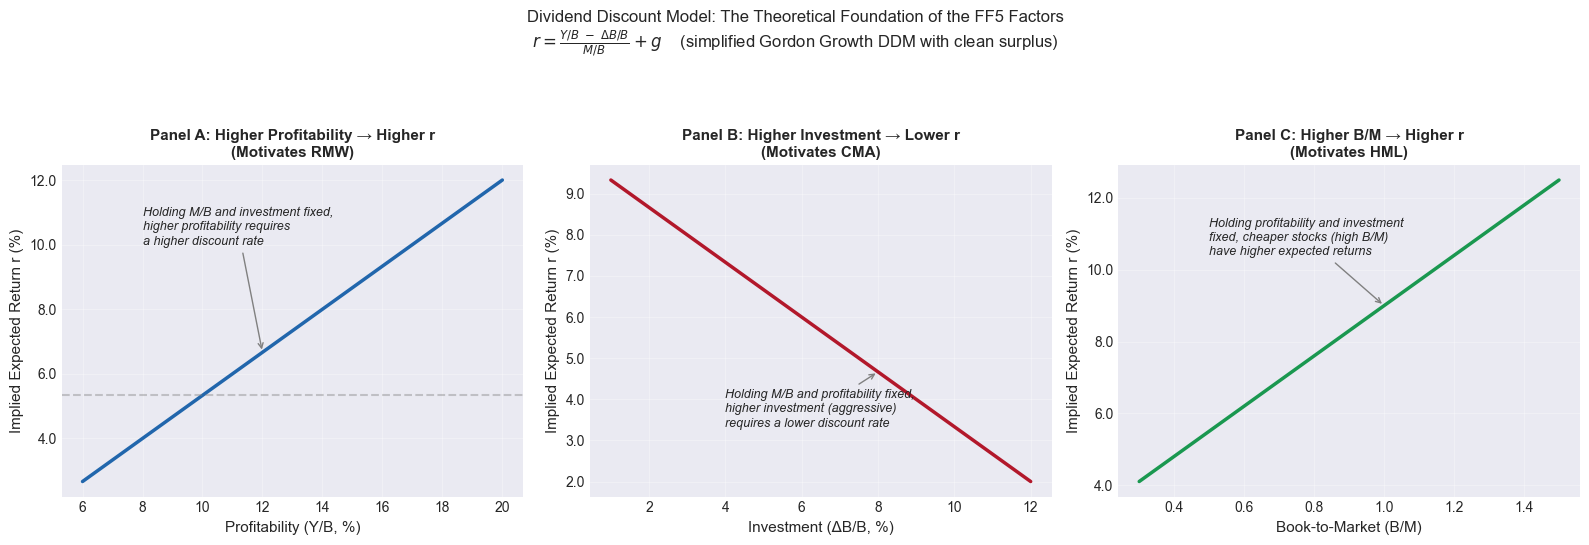

DDM COMPARATIVE STATICS — NUMERICAL EXAMPLE

Baseline: Y/B = 12%,  ΔB/B = 5%,  M/B = 1.5,  g = 2%
  → Implied expected return: 6.67%

Scenario                                  Y/B   ΔB/B    M/B        r
----------------------------------------------------------------------
High profitability (Y/B = 18%)           18%    5%    1.5  10.67% ↑ (+4.00%)
Low profitability  (Y/B = 6%)             6%    5%    1.5   2.67% ↓ (-4.00%)
Conservative inv.  (ΔB/B = 2%)           12%    2%    1.5   8.67% ↑ (+2.00%)
Aggressive inv.    (ΔB/B = 10%)          12%   10%    1.5   3.33% ↓ (-3.33%)
Deep value stock   (M/B = 0.8)           12%    5%    0.8  10.75% ↑ (+4.08%)
Growth stock       (M/B = 3.0)           12%    5%    3.0   4.33% ↓ (-2.33%)

→ These are exactly the cross-sectional patterns that RMW, CMA, and HML capture.
  The DDM shows they are not ad hoc — they follow from present-value logic.


In [4]:
# ============================================================================
# DDM Illustration: How Profitability, Investment, and B/M Map to Expected Returns
# ============================================================================
# This cell provides a numerical illustration of the Fama-French (2015) DDM
# comparative statics. We solve for the implied discount rate (expected return)
# under different assumptions about profitability and investment growth.
#
# The simplified DDM (Gordon Growth variant with clean surplus):
#   M = (Y - dB) / (r - g)   =>   r = (Y - dB)/M + g
# where Y = earnings, dB = net investment, M = market value, g = growth rate.
# Equivalently, dividing by book equity B:
#   M/B = (Y/B - dB/B) / (r - g)
# so:
#   r = (Y/B - dB/B) / (M/B) + g

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# --- Parameters ---
growth_rate = 0.02          # long-run nominal growth rate (g)
profitability_range = np.linspace(0.06, 0.20, 100)  # Y/B: ROE from 6% to 20%
investment_range = np.linspace(0.01, 0.12, 100)      # dB/B: reinvestment rate

# Fix one dimension and vary the other to show comparative statics

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# --- Panel A: Expected return vs. Profitability (Y/B) ---
# Fix: M/B = 1.5,  dB/B = 0.05
mb_fixed = 1.5
inv_fixed = 0.05
r_vs_prof = (profitability_range - inv_fixed) / mb_fixed + growth_rate

ax = axes[0]
ax.plot(profitability_range * 100, r_vs_prof * 100, color='#2166ac', linewidth=2.5)
ax.set_xlabel('Profitability (Y/B, %)', fontsize=11)
ax.set_ylabel('Implied Expected Return r (%)', fontsize=11)
ax.set_title('Panel A: Higher Profitability → Higher r\n(Motivates RMW)', fontsize=11, fontweight='bold')
ax.axhline(y=(0.10 - inv_fixed) / mb_fixed * 100 + growth_rate * 100, color='gray',
           linestyle='--', alpha=0.4)
ax.annotate('Holding M/B and investment fixed,\nhigher profitability requires\na higher discount rate',
            xy=(0.12 * 100, ((0.12 - inv_fixed) / mb_fixed + growth_rate) * 100),
            xytext=(0.08 * 100, ((0.17 - inv_fixed) / mb_fixed + growth_rate) * 100),
            fontsize=9, fontstyle='italic',
            arrowprops=dict(arrowstyle='->', color='gray'))
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
ax.grid(True, alpha=0.3)

# --- Panel B: Expected return vs. Investment (dB/B) ---
# Fix: M/B = 1.5,  Y/B = 0.12
prof_fixed = 0.12
r_vs_inv = (prof_fixed - investment_range) / mb_fixed + growth_rate

ax = axes[1]
ax.plot(investment_range * 100, r_vs_inv * 100, color='#b2182b', linewidth=2.5)
ax.set_xlabel('Investment (ΔB/B, %)', fontsize=11)
ax.set_ylabel('Implied Expected Return r (%)', fontsize=11)
ax.set_title('Panel B: Higher Investment → Lower r\n(Motivates CMA)', fontsize=11, fontweight='bold')
ax.annotate('Holding M/B and profitability fixed,\nhigher investment (aggressive)\nrequires a lower discount rate',
            xy=(0.08 * 100, ((prof_fixed - 0.08) / mb_fixed + growth_rate) * 100),
            xytext=(0.04 * 100, ((prof_fixed - 0.10) / mb_fixed + growth_rate) * 100),
            fontsize=9, fontstyle='italic',
            arrowprops=dict(arrowstyle='->', color='gray'))
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
ax.grid(True, alpha=0.3)

# --- Panel C: Expected return vs. B/M (inverse of M/B) ---
# Fix: Y/B = 0.12,  dB/B = 0.05
bm_range = np.linspace(0.3, 1.5, 100)   # B/M from 0.3 (growth) to 1.5 (deep value)
mb_range = 1.0 / bm_range
r_vs_bm = (prof_fixed - inv_fixed) / mb_range + growth_rate

ax = axes[2]
ax.plot(bm_range, r_vs_bm * 100, color='#1a9850', linewidth=2.5)
ax.set_xlabel('Book-to-Market (B/M)', fontsize=11)
ax.set_ylabel('Implied Expected Return r (%)', fontsize=11)
ax.set_title('Panel C: Higher B/M → Higher r\n(Motivates HML)', fontsize=11, fontweight='bold')
ax.annotate('Holding profitability and investment\nfixed, cheaper stocks (high B/M)\nhave higher expected returns',
            xy=(1.0, ((prof_fixed - inv_fixed) * 1.0 + growth_rate) * 100),
            xytext=(0.5, ((prof_fixed - inv_fixed) * 1.2 + growth_rate) * 100),
            fontsize=9, fontstyle='italic',
            arrowprops=dict(arrowstyle='->', color='gray'))
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
ax.grid(True, alpha=0.3)

plt.suptitle('Dividend Discount Model: The Theoretical Foundation of the FF5 Factors\n'
             r'$r = \frac{Y/B\ -\ \Delta B/B}{M/B} + g$' + '    (simplified Gordon Growth DDM with clean surplus)',
             fontsize=12, y=1.08)
plt.tight_layout()
plt.show()

# --- Summary table ---
print("=" * 70)
print("DDM COMPARATIVE STATICS — NUMERICAL EXAMPLE")
print("=" * 70)
print(f"\nBaseline: Y/B = 12%,  ΔB/B = 5%,  M/B = 1.5,  g = 2%")
baseline_r = (0.12 - 0.05) / 1.5 + 0.02
print(f"  → Implied expected return: {baseline_r:.2%}\n")

scenarios = [
    ("High profitability (Y/B = 18%)",  0.18, 0.05, 1.5),
    ("Low profitability  (Y/B = 6%)",   0.06, 0.05, 1.5),
    ("Conservative inv.  (ΔB/B = 2%)",  0.12, 0.02, 1.5),
    ("Aggressive inv.    (ΔB/B = 10%)", 0.12, 0.10, 1.5),
    ("Deep value stock   (M/B = 0.8)",  0.12, 0.05, 0.8),
    ("Growth stock       (M/B = 3.0)",  0.12, 0.05, 3.0),
]

print(f"{'Scenario':<38} {'Y/B':>6} {'ΔB/B':>6} {'M/B':>6} {'r':>8}")
print("-" * 70)
for label, yb, db, mb in scenarios:
    r = (yb - db) / mb + growth_rate
    delta = r - baseline_r
    arrow = "↑" if delta > 0 else "↓"
    print(f"{label:<38} {yb:>5.0%} {db:>5.0%} {mb:>6.1f} {r:>7.2%} {arrow} ({delta:+.2%})")

print("\n→ These are exactly the cross-sectional patterns that RMW, CMA, and HML capture.")
print("  The DDM shows they are not ad hoc — they follow from present-value logic.")

### Empirical Analysis: Factor Summary Statistics

With the theoretical foundation in place, let's examine the empirical properties of the five factors. We'll look at summary statistics, risk-return profiles, and the correlation structure — all of which inform how the factors interact in a regression.

In [5]:
# ============================================================================
# 5-Factor Model: Factor Summary Statistics
# ============================================================================

print("="*70)
print("FAMA-FRENCH 5-FACTOR SUMMARY STATISTICS (2000–2023)")
print("="*70)

factor_cols = ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_stats = factors[factor_cols].describe().T
factor_stats['Annualized Mean'] = factors[factor_cols].mean() * 12
factor_stats['Annualized Std'] = factors[factor_cols].std() * np.sqrt(12)
factor_stats['Sharpe Ratio'] = factor_stats['Annualized Mean'] / factor_stats['Annualized Std']
factor_stats['t-stat (mean=0)'] = (factors[factor_cols].mean() / 
                                    (factors[factor_cols].std() / np.sqrt(len(factors))))

print("\nMonthly Statistics:")
print(factors[factor_cols].describe().round(4))

print("\n\nAnnualized Performance:")
print(factor_stats[['Annualized Mean', 'Annualized Std', 'Sharpe Ratio', 't-stat (mean=0)']].round(4))

print("""
INTERPRETATION:
- Mkt_RF has the highest average premium but also the highest volatility
- RMW (profitability) has had a strong, relatively stable premium
- CMA (investment) has a positive but typically smaller premium
- HML (value) has had a mixed record since 2000 (value struggled 2018-2020)
- SMB (size) has been the weakest factor in this sample period
""")

FAMA-FRENCH 5-FACTOR SUMMARY STATISTICS (2000–2023)

Monthly Statistics:
         Mkt_RF       SMB       HML       RMW       CMA
count  288.0000  288.0000  288.0000  288.0000  288.0000
mean     0.0056    0.0024    0.0021    0.0045    0.0028
std      0.0463    0.0311    0.0348    0.0293    0.0223
min     -0.1720   -0.1554   -0.1383   -0.1895   -0.0708
25%     -0.0203   -0.0165   -0.0153   -0.0106   -0.0111
50%      0.0114    0.0014   -0.0007    0.0038    0.0002
75%      0.0327    0.0199    0.0175    0.0166    0.0142
max      0.1358    0.1846    0.1286    0.1305    0.0901


Annualized Performance:
        Annualized Mean  Annualized Std  Sharpe Ratio  t-stat (mean=0)
Mkt_RF           0.0669          0.1602        0.4173           2.0445
SMB              0.0285          0.1076        0.2652           1.2992
HML              0.0255          0.1206        0.2114           1.0355
RMW              0.0542          0.1015        0.5338           2.6149
CMA              0.0332          0.0772   

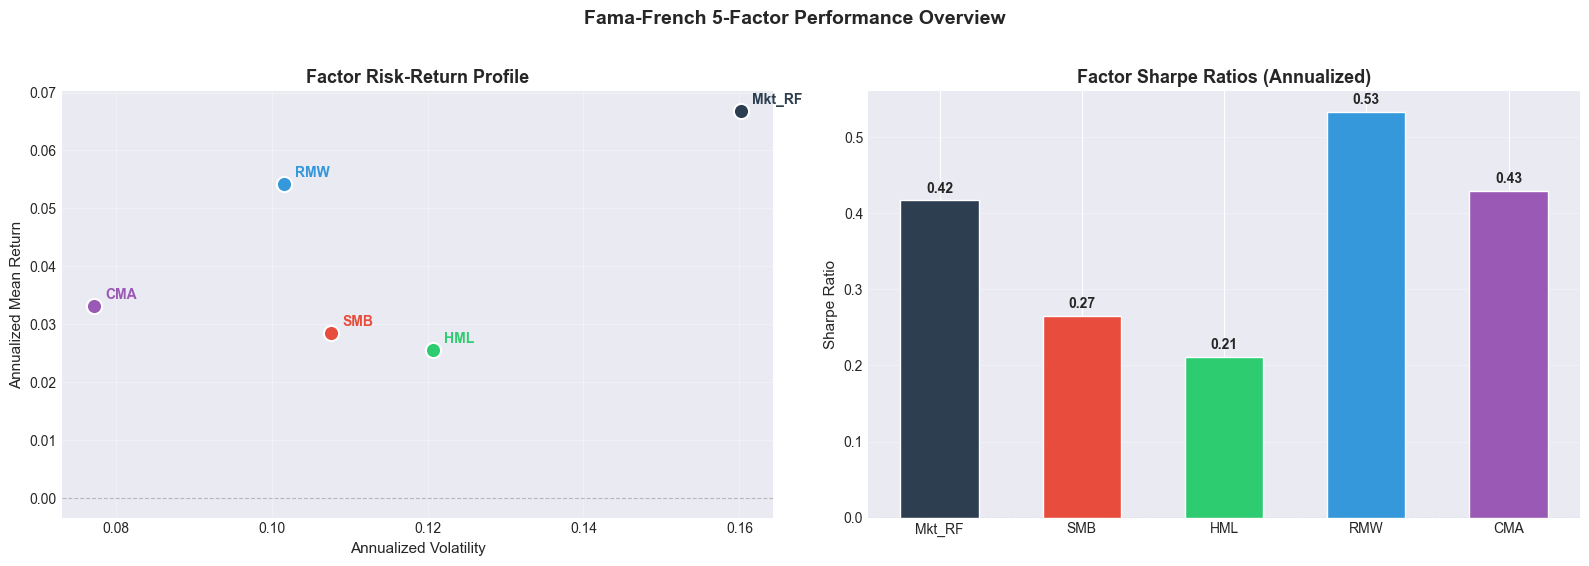

In [6]:
# ============================================================================
# Visualize: Factor risk-return profile
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 5.5))

factor_cols = ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA']
ann_means = factors[factor_cols].mean() * 12
ann_stds = factors[factor_cols].std() * np.sqrt(12)
sharpes = ann_means / ann_stds

colors = {'Mkt_RF': '#2c3e50', 'SMB': '#e74c3c', 'HML': '#2ecc71',
          'RMW': '#3498db', 'CMA': '#9b59b6'}

# --- Left: Risk-return scatter ---
ax = axes[0]
for col in factor_cols:
    ax.scatter(ann_stds[col], ann_means[col], s=120, color=colors[col],
               edgecolors='white', linewidth=1.5, zorder=3)
    ax.annotate(col, (ann_stds[col], ann_means[col]),
                textcoords="offset points", xytext=(8, 5), fontsize=10, fontweight='bold',
                color=colors[col])
ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
ax.set_xlabel('Annualized Volatility', fontsize=11)
ax.set_ylabel('Annualized Mean Return', fontsize=11)
ax.set_title('Factor Risk-Return Profile', fontweight='bold', fontsize=13)
ax.grid(True, alpha=0.3)

# --- Right: Sharpe ratio bar chart ---
ax2 = axes[1]
bar_colors = [colors[col] for col in factor_cols]
bars = ax2.bar(factor_cols, sharpes, color=bar_colors, edgecolor='white', width=0.55)
ax2.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
for bar, sr in zip(bars, sharpes):
    ax2.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + (0.01 if sr >= 0 else -0.04),
             f'{sr:.2f}', ha='center', fontsize=10, fontweight='bold')
ax2.set_ylabel('Sharpe Ratio', fontsize=11)
ax2.set_title('Factor Sharpe Ratios (Annualized)', fontweight='bold', fontsize=13)
ax2.grid(True, alpha=0.3, axis='y')

fig.suptitle('Fama-French 5-Factor Performance Overview', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

FACTOR CORRELATION MATRIX
        Mkt_RF    SMB    HML    RMW    CMA
Mkt_RF   1.000  0.269 -0.021 -0.344 -0.226
SMB      0.269  1.000  0.060 -0.495  0.028
HML     -0.021  0.060  1.000  0.347  0.632
RMW     -0.344 -0.495  0.347  1.000  0.238
CMA     -0.226  0.028  0.632  0.238  1.000


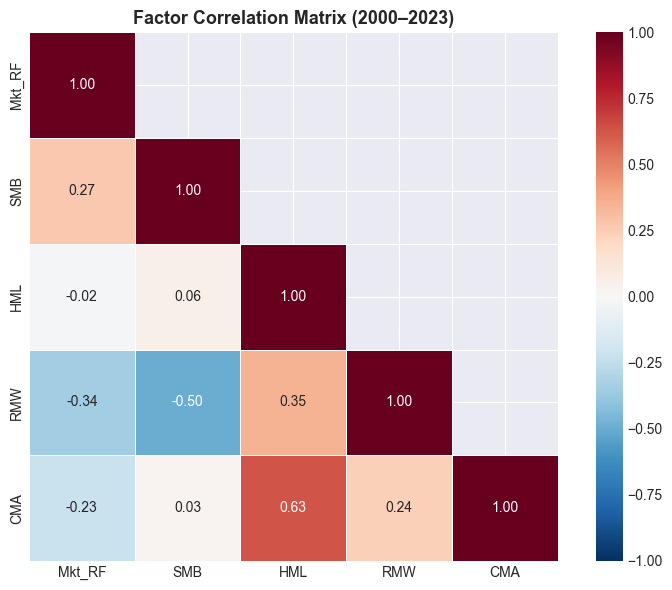


KEY OBSERVATIONS:
- HML and CMA are strongly positively correlated — value stocks tend to be 
  conservative investors. This is why CMA partially "explains" HML.
- RMW and HML are often negatively correlated — cheap (value) stocks tend to 
  be less profitable. This creates tension in the model.
- SMB has low correlation with the other factors — size captures something distinct.
- Mkt_RF is relatively independent of the style factors — by construction.



In [7]:
# ============================================================================
# 5-Factor Model: Factor Correlation Matrix
# ============================================================================

print("FACTOR CORRELATION MATRIX")
print("="*70)

corr = factors[factor_cols].corr()
print(corr.round(3))

# Visualize
fig, ax = plt.subplots(figsize=(8, 6))
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            mask=mask, square=True, ax=ax, vmin=-1, vmax=1,
            linewidths=0.5)
ax.set_title('Factor Correlation Matrix (2000–2023)', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.savefig('factor_correlations.png', dpi=100, bbox_inches='tight')
plt.show()

print("""
KEY OBSERVATIONS:
- HML and CMA are strongly positively correlated — value stocks tend to be 
  conservative investors. This is why CMA partially "explains" HML.
- RMW and HML are often negatively correlated — cheap (value) stocks tend to 
  be less profitable. This creates tension in the model.
- SMB has low correlation with the other factors — size captures something distinct.
- Mkt_RF is relatively independent of the style factors — by construction.
""")

### Model Comparison: 3-Factor vs. 5-Factor

Now we fit both the original 3-factor model and the extended 5-factor model to our three ETFs. The key questions: does adding RMW and CMA improve the fit? Does the HML coefficient change — the "redundancy" effect Fama and French documented?

In [8]:
# ============================================================================
# 5-Factor Regression: Compare 3-Factor vs 5-Factor for all ETFs
# ============================================================================

def run_ff_regression(y, X_cols, data, model_name="Model", stock_name="Stock"):
    """Run a factor regression with Newey-West standard errors.
    
    All regressions in this notebook use Newey-West HAC standard errors,
    as justified in the introductory notebook (Section 9). This accounts
    for heteroscedasticity and autocorrelation in financial time-series
    without requiring separate diagnostic checks for each regression.
    
    Why Newey-West?  Financial returns are neither homoscedastic (volatility
    clusters in time) nor serially independent (monthly residuals exhibit
    mild autocorrelation).  Classic OLS standard errors would therefore be
    too small, inflating t-statistics and producing overly optimistic p-values.
    Newey-West corrects for *both* problems at once by estimating the
    'sandwich' covariance matrix with Bartlett-weighted cross-lag terms.
    For the full derivation and a hand-checkable example, see the
    Statistical Foundations Tutorial (Sections 7-10).
    
    Lag length is set by the Andrews (1991) rule: L = floor(4*(n/100)^(2/9)).
    """
    y_vals = data['Stock_Excess_Return'].values
    X_vals = sm.add_constant(data[X_cols].values)
    model = sm.OLS(y_vals, X_vals)
    results = model.fit()
    n = len(y_vals)
    lag = int(np.floor(4 * (n / 100) ** (2/9)))
    results_nw = results.get_robustcov_results(cov_type='HAC', maxlags=lag)
    return results_nw

print("="*70)
print("3-FACTOR vs 5-FACTOR MODEL COMPARISON")
print("="*70)

comparison_data = []

for ticker, label in etf_tickers.items():
    edf = etf_dataframes[ticker]

    # 3-Factor
    res3 = run_ff_regression(None, ['Mkt_RF', 'SMB', 'HML'], edf,
                              model_name="FF3", stock_name=label)
    # 5-Factor
    res5 = run_ff_regression(None, ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA'], edf,
                              model_name="FF5", stock_name=label)

    comparison_data.append({
        'ETF': ticker,
        'FF3 R²': res3.rsquared,
        'FF5 R²': res5.rsquared,
        'FF3 Adj R²': res3.rsquared_adj,
        'FF5 Adj R²': res5.rsquared_adj,
        'FF3 Alpha': res3.params[0],
        'FF5 Alpha': res5.params[0],
        'FF3 Alpha p': res3.pvalues[0],
        'FF5 Alpha p': res5.pvalues[0],
    })

    print(f"\n{'='*70}")
    print(f"  {label}")
    print(f"{'='*70}")
    print(f"\n  3-Factor Model:")
    print(f"    Alpha = {res3.params[0]:.6f}  (p = {res3.pvalues[0]:.4f})")
    print(f"    Mkt   = {res3.params[1]:.4f}  SMB = {res3.params[2]:.4f}  HML = {res3.params[3]:.4f}")
    print(f"    R² = {res3.rsquared:.4f}   Adj R² = {res3.rsquared_adj:.4f}")
    print(f"\n  5-Factor Model:")
    print(f"    Alpha = {res5.params[0]:.6f}  (p = {res5.pvalues[0]:.4f})")
    print(f"    Mkt   = {res5.params[1]:.4f}  SMB = {res5.params[2]:.4f}  HML = {res5.params[3]:.4f}")
    print(f"    RMW   = {res5.params[4]:.4f}  CMA = {res5.params[5]:.4f}")
    print(f"    R² = {res5.rsquared:.4f}   Adj R² = {res5.rsquared_adj:.4f}")
    print(f"\n    R² improvement: {res5.rsquared - res3.rsquared:+.4f}")

comp_df = pd.DataFrame(comparison_data)
print("\n\n" + "="*70)
print("SUMMARY TABLE")
print("="*70)
print(comp_df.to_string(index=False, float_format='%.4f'))

3-FACTOR vs 5-FACTOR MODEL COMPARISON

  SPY (S&P 500)

  3-Factor Model:
    Alpha = -0.000019  (p = 0.9755)
    Mkt   = 1.0178  SMB = -0.0946  HML = 0.0965
    R² = 0.8576   Adj R² = 0.8558

  5-Factor Model:
    Alpha = 0.000016  (p = 0.9827)
    Mkt   = 1.0026  SMB = -0.0922  HML = 0.1740
    RMW   = 0.0459  CMA = -0.2135
    R² = 0.8622   Adj R² = 0.8593

    R² improvement: +0.0046

  IWN (Small Cap Value)

  3-Factor Model:
    Alpha = -0.000798  (p = 0.4129)
    Mkt   = 1.0095  SMB = 0.8223  HML = 0.4223
    R² = 0.8599   Adj R² = 0.8581

  5-Factor Model:
    Alpha = -0.000305  (p = 0.7888)
    Mkt   = 0.9840  SMB = 0.7933  HML = 0.5461
    RMW   = -0.0422  CMA = -0.3157
    R² = 0.8652   Adj R² = 0.8623

    R² improvement: +0.0053

  VTV (Large Cap Value)

  3-Factor Model:
    Alpha = -0.000047  (p = 0.9538)
    Mkt   = 0.9411  SMB = -0.1074  HML = 0.4166
    R² = 0.8266   Adj R² = 0.8244

  5-Factor Model:
    Alpha = 0.000009  (p = 0.9921)
    Mkt   = 0.9315  SMB = -0.108

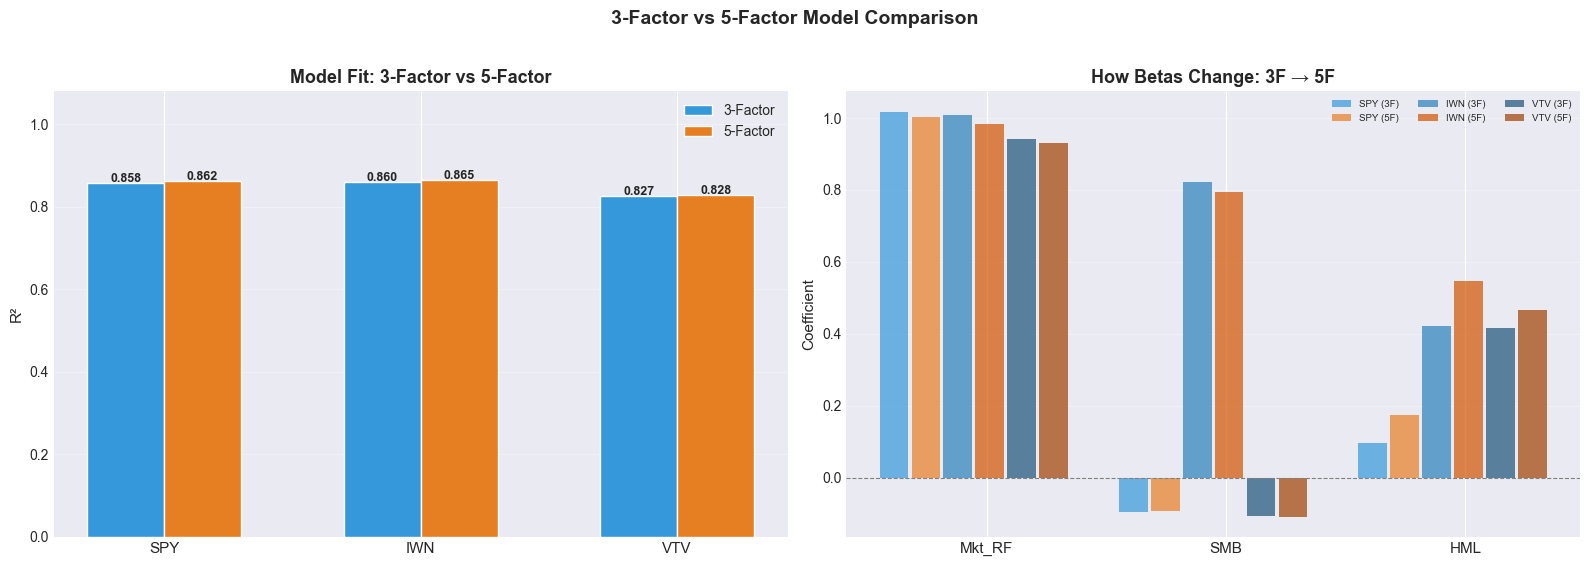

NOTE: Watch how HML betas change when RMW and CMA are added — this is the
'HML is redundant' effect Fama and French (2015) documented.


In [9]:
# ============================================================================
# Visualize: 3-Factor vs 5-Factor model comparison
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 5.5))

tickers = list(etf_tickers.keys())
labels = [etf_tickers[t] for t in tickers]
short_labels = tickers

# Re-extract coefficients for plotting
coef_data_3f = {}
coef_data_5f = {}
for ticker in tickers:
    edf = etf_dataframes[ticker]
    res3 = run_ff_regression(None, ['Mkt_RF', 'SMB', 'HML'], edf)
    res5 = run_ff_regression(None, ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA'], edf)
    coef_data_3f[ticker] = {'Alpha': res3.params[0], 'Mkt_RF': res3.params[1],
                             'SMB': res3.params[2], 'HML': res3.params[3],
                             'R²': res3.rsquared}
    coef_data_5f[ticker] = {'Alpha': res5.params[0], 'Mkt_RF': res5.params[1],
                             'SMB': res5.params[2], 'HML': res5.params[3],
                             'RMW': res5.params[4], 'CMA': res5.params[5],
                             'R²': res5.rsquared}

# --- Left: R² comparison ---
ax = axes[0]
x_pos = np.arange(len(tickers))
width = 0.3
bars1 = ax.bar(x_pos - width/2, [coef_data_3f[t]['R²'] for t in tickers],
               width, label='3-Factor', color='#3498db', edgecolor='white')
bars2 = ax.bar(x_pos + width/2, [coef_data_5f[t]['R²'] for t in tickers],
               width, label='5-Factor', color='#e67e22', edgecolor='white')
for bar in list(bars1) + list(bars2):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.003,
            f'{bar.get_height():.3f}', ha='center', fontsize=9, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(short_labels, fontsize=11)
ax.set_ylabel('R²', fontsize=11)
ax.set_title('Model Fit: 3-Factor vs 5-Factor', fontweight='bold', fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 1.08)

# --- Right: Coefficient comparison for shared factors ---
ax2 = axes[1]
shared_factors = ['Mkt_RF', 'SMB', 'HML']
x_pos2 = np.arange(len(shared_factors))
group_width = 0.8
bar_w = group_width / len(tickers) / 2  # 2 models per ticker

color_3f = ['#3498db', '#2980b9', '#1a5276']
color_5f = ['#e67e22', '#d35400', '#a04000']

for i, ticker in enumerate(tickers):
    offset_3f = -group_width/2 + i * (group_width/len(tickers)) + bar_w * 0.1
    offset_5f = offset_3f + bar_w
    vals_3f = [coef_data_3f[ticker][f] for f in shared_factors]
    vals_5f = [coef_data_5f[ticker][f] for f in shared_factors]
    ax2.bar(x_pos2 + offset_3f, vals_3f, bar_w * 0.9, color=color_3f[i], alpha=0.7,
            label=f'{ticker} (3F)' if i == 0 else f'{ticker} (3F)')
    ax2.bar(x_pos2 + offset_5f, vals_5f, bar_w * 0.9, color=color_5f[i], alpha=0.7,
            label=f'{ticker} (5F)' if i == 0 else f'{ticker} (5F)')

ax2.set_xticks(x_pos2)
ax2.set_xticklabels(shared_factors, fontsize=11)
ax2.set_ylabel('Coefficient', fontsize=11)
ax2.set_title('How Betas Change: 3F → 5F', fontweight='bold', fontsize=13)
ax2.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
ax2.legend(fontsize=7, ncol=3, loc='upper right')
ax2.grid(True, alpha=0.3, axis='y')

fig.suptitle('3-Factor vs 5-Factor Model Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("NOTE: Watch how HML betas change when RMW and CMA are added — this is the")
print("'HML is redundant' effect Fama and French (2015) documented.")

### Interpreting the 3-Factor vs 5-Factor Comparison

Compare these results to the 3-factor regressions you ran in the [3-Factor Tutorial](03_Fama_French_3Factor.ipynb). The key question is: **does adding RMW and CMA change the story?**

**What to look for:**

1. **R² improvement**: The 5-factor model should explain at least as much variance as the 3-factor model. For broad-market ETFs like SPY, the improvement may be modest since the market factor dominates. For style ETFs like IWN (small value) or VTV (large value), the additional factors may capture meaningful variation.

2. **Alpha changes**: If alpha shrinks when moving from 3 to 5 factors, the "outperformance" was actually compensation for profitability/investment factor exposures — not genuine skill. Recall from the [3-Factor Tutorial](03_Fama_French_3Factor.ipynb) that alpha should be interpreted carefully: a statistically insignificant alpha means the model fully explains the ETF's returns.

3. **RMW and CMA loadings**:
   - IWN (small cap value) may show **negative RMW** — small value firms are often less profitable
   - VTV (large cap value) may show **positive RMW** — large value firms tend to be more profitable
   - Both value ETFs should show **positive CMA** — value stocks tend to be conservative investors

4. **HML coefficient changes**: Watch how β_HML changes between the 3- and 5-factor specifications. Due to the high correlation between HML and CMA, the HML loading may shrink when CMA is included.

---

## Section 2: Momentum — The Carhart 4-Factor Model

### The Premier Anomaly

Momentum is one of the most robust and persistent anomalies in finance. First documented formally by Jegadeesh and Titman (1993), it refers to the tendency of stocks that have performed well over the past 3–12 months to continue performing well, and vice versa.

### The Carhart (1997) 4-Factor Model

Mark Carhart extended the Fama-French 3-factor model by adding a momentum factor:

$$R_i - R_f = \alpha + \beta_{MKT}(R_m - R_f) + \beta_{SMB} \cdot SMB + \beta_{HML} \cdot HML + \beta_{UMD} \cdot UMD + \epsilon$$

**UMD (Up Minus Down)**, also called **WML (Winners Minus Losers)**:
- Long stocks with high returns over months $t-12$ to $t-2$
- Short stocks with low returns over the same period
- Month $t-1$ is skipped to avoid the short-term reversal effect (more on this later)
- Average annual premium: roughly 6–8% historically — **larger than value or size**

### Why Does Momentum Exist?

This is one of the great debates in finance:

**Behavioral Explanations:**
- **Underreaction**: Investors are slow to incorporate new information → prices drift in the direction of news
- **Overconfidence + Self-attribution bias**: When investors' picks go up, they attribute it to their skill and buy more; when picks go down, they blame bad luck
- **Herding**: Investors follow trends, creating self-reinforcing price movements
- **Disposition effect**: Investors sell winners too early and hold losers too long, creating persistent price trends

**Risk-Based Explanations:**
- Momentum stocks are riskier because they have **crash risk** — momentum strategies experience rare but devastating drawdowns (e.g., 2009 momentum crash: −73% in a few months)
- Time-varying risk: momentum profits may compensate for loading on a latent risk factor during economic state changes
- However, no fully satisfactory risk-based explanation has been widely accepted

**Fama and French's Position:**
- Fama and French deliberately excluded momentum from their 5-factor model
- In their 2015 paper, they acknowledged momentum's existence but argued it is not a "pervasive" risk factor in the same way as their other factors — it's more of a trading strategy than a source of systematic risk
- They note that momentum **does not have a clear risk-based story**, which is uncomfortable from an efficient markets perspective

### Fundamental Momentum: What's Really Driving the Premium?

Robert Novy-Marx has argued ([Rational Reminder, Episode 149](https://rationalreminder.ca/podcast/149)) that much of what looks like *price* momentum is actually driven by a much older anomaly from the accounting literature: **fundamental (earnings) momentum**.

**Earnings momentum** (or post-earnings announcement drift, PEAD) was documented 20 years before price momentum. It refers to the tendency of stocks with improving year-over-year quarterly earnings to continue outperforming — there is a large initial price jump at the earnings announcement, but subsequent returns remain elevated for months afterward.

Novy-Marx's decomposition reveals a critical asymmetry:

| Stock type | Future returns? |
|---|---|
| Big price increase **with** big earnings improvement | **Continue to outperform** — this is the real signal |
| Big price increase **without** earnings improvement | **Do not** continue to outperform — price-only momentum is noise |
| Big earnings improvement **without** price increase | **Do outperform** — the market underreacted to fundamentals |

The implication: when you buy "price winners" (the standard momentum strategy), you are **on average** buying stocks that have seen earnings improvements — and it is the earnings improvement, not the price trend per se, that predicts future returns. Fundamental momentum is the more robust causal mechanism; price momentum is a noisy proxy for it.

### What Are You Actually Getting in a Momentum Fund?

Novy-Marx identifies three distinct exposures embedded in price momentum strategies:

1. **Earnings momentum** — the genuine signal; stocks with improving fundamentals
2. **Industry concentrations** — industries tend to move together, so momentum portfolios become temporarily concentrated in hot sectors. This doesn't help expected returns but **increases volatility** and contributes to occasional crashes
3. **Time-varying market beta** — in up markets, winners tend to be high-beta stocks (overweighting market risk); in down markets, relative winners tend to be low-beta stocks (underweighting market risk). This creates a perverse pattern: momentum is accidentally *long* the market just before downturns and *short* the market just before recoveries

These unintended bets help explain momentum's notorious left-tail risk.

### Why Novy-Marx is Skeptical of Momentum as a Standalone Factor

Despite momentum's impressive historical average premium, Novy-Marx is cautious:

- **High turnover**: Academic momentum strategies have ~700% annual turnover. More cost-efficient implementations reduce the premium by roughly half.
- **Crash risk**: The 2009 crash (−50% in three months) and similar episodes in 1932 are not isolated flukes — they are structurally linked to how momentum concentrates in recently-winning betas and industries.
- **Reduced diversification benefit once you include profitability**: Momentum's historical appeal was partly its negative correlation with value. But profitability already has a larger negative correlation with value. Once you trade value + profitability jointly, momentum's incremental diversification benefit shrinks substantially — "it's not a hedge anymore."
- **We don't understand it**: Unlike value and profitability, which have clear valuation-theoretic foundations (Section 1's DDM derivation), momentum lacks a convincing risk-based explanation. This makes Novy-Marx "a little nervous" about its future persistence.

Novy-Marx suggests a more pragmatic use: embed momentum information into the **implementation** of other strategies (e.g., delay buying value stocks with negative short-term momentum, as DFA does) rather than running a standalone momentum portfolio. This captures some momentum benefit without incurring the full turnover and crash risk.

### Momentum Crashes

A critical feature of momentum is its **left tail risk**. Daniel and Moskowitz (2016) documented that momentum experiences severe crashes, particularly after market downturns when previously losing stocks (now cheap) rapidly rebound:

- **2009**: The momentum factor lost roughly 73% in a few months as value stocks rebounded after the financial crisis
- **1932**: Similar crash after the Great Depression
- These crashes tend to occur when the market recovers sharply from a bear market — exactly when past losers (beaten-down stocks) surge

MOMENTUM FACTOR (UMD) ANALYSIS


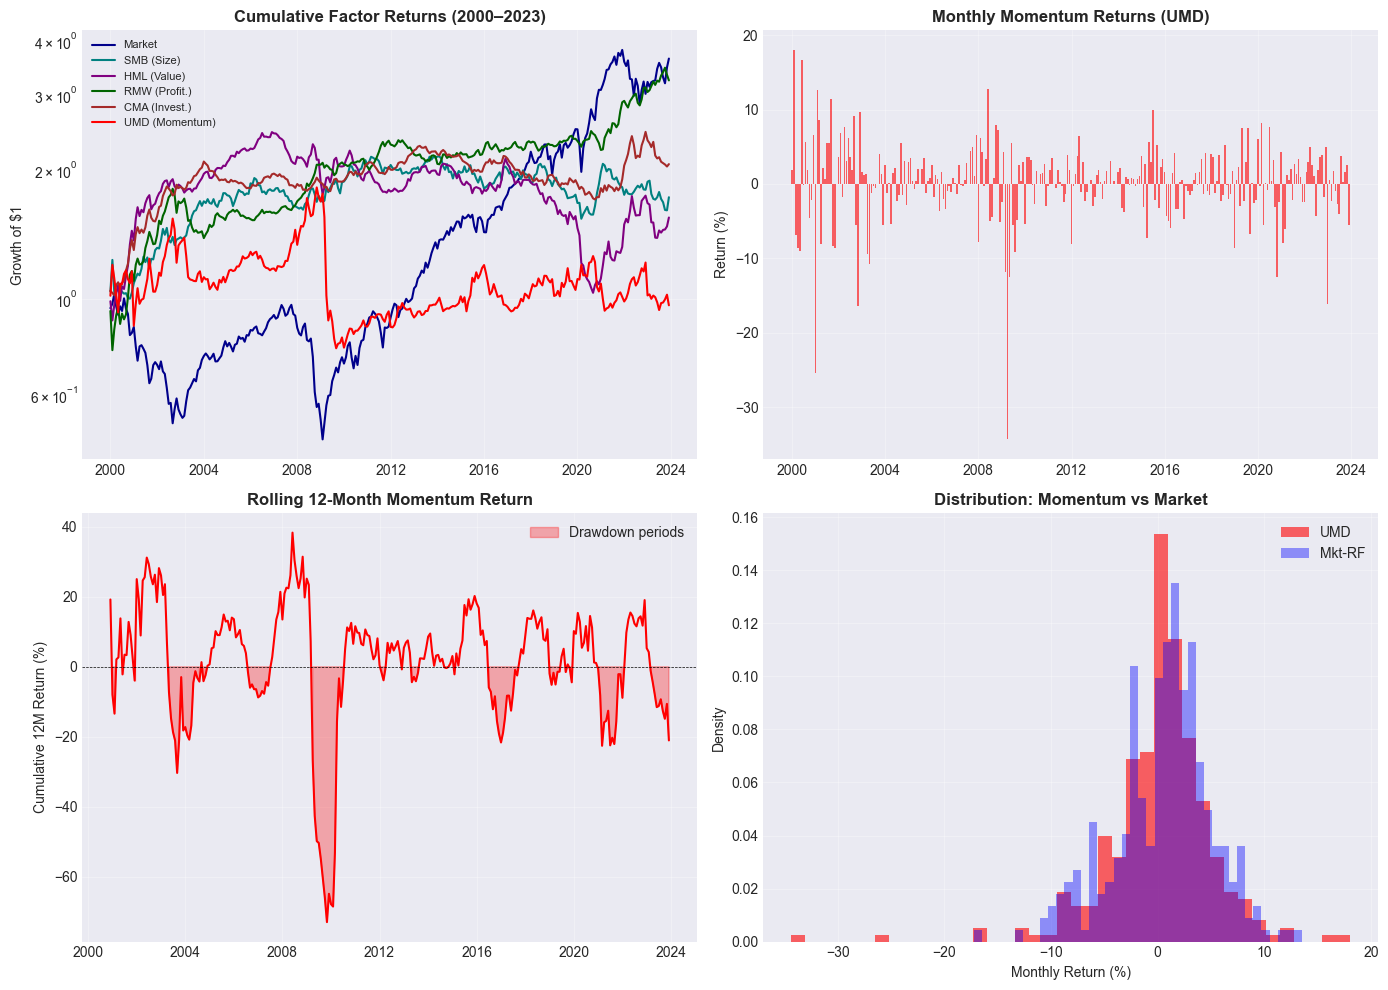


Momentum (UMD) Summary Statistics:
  Mean monthly return:    0.13%
  Monthly std dev:        5.20%
  Annualized return:      1.59%
  Annualized volatility:  18.01%
  Sharpe ratio:           0.09
  Skewness:               -1.45
  Kurtosis:               9.00
  Worst month:            -34.34%
  Best month:             18.02%

OBSERVATIONS:
- Momentum has high average returns but LARGE NEGATIVE SKEWNESS
- The worst month is extremely negative — this is the momentum crash risk
- The distribution has fat tails (high kurtosis) compared to the market
- This crash risk is a key reason momentum is hard to capture in practice



In [10]:
# ============================================================================
# Momentum Factor Analysis
# ============================================================================

print("="*70)
print("MOMENTUM FACTOR (UMD) ANALYSIS")
print("="*70)

# Cumulative returns of all factors
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Cumulative factor returns
ax = axes[0, 0]
for col, color, lbl in [('Mkt_RF', 'darkblue', 'Market'),
                          ('SMB', 'teal', 'SMB (Size)'),
                          ('HML', 'purple', 'HML (Value)'),
                          ('RMW', 'darkgreen', 'RMW (Profit.)'),
                          ('CMA', 'brown', 'CMA (Invest.)'),
                          ('UMD', 'red', 'UMD (Momentum)')]:
    cum = (1 + factors[col]).cumprod()
    ax.plot(factors.index, cum, label=lbl, linewidth=1.5, color=color)
ax.set_title('Cumulative Factor Returns (2000–2023)', fontweight='bold')
ax.set_ylabel('Growth of $1')
ax.legend(fontsize=8, loc='upper left')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

# Plot 2: Momentum monthly returns
ax = axes[0, 1]
ax.bar(factors.index, factors['UMD'] * 100, color='red', alpha=0.6, width=25)
ax.set_title('Monthly Momentum Returns (UMD)', fontweight='bold')
ax.set_ylabel('Return (%)')
ax.grid(True, alpha=0.3)

# Plot 3: Rolling 12-month momentum return
ax = axes[1, 0]
rolling_mom = factors['UMD'].rolling(12).sum() * 100
ax.plot(factors.index, rolling_mom, color='red', linewidth=1.5)
ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
ax.fill_between(factors.index, rolling_mom, 0,
                where=rolling_mom < 0, color='red', alpha=0.3, label='Drawdown periods')
ax.set_title('Rolling 12-Month Momentum Return', fontweight='bold')
ax.set_ylabel('Cumulative 12M Return (%)')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Distribution of momentum returns vs market
ax = axes[1, 1]
ax.hist(factors['UMD'] * 100, bins=40, alpha=0.6, color='red', label='UMD', density=True)
ax.hist(factors['Mkt_RF'] * 100, bins=40, alpha=0.4, color='blue', label='Mkt-RF', density=True)
ax.set_title('Distribution: Momentum vs Market', fontweight='bold')
ax.set_xlabel('Monthly Return (%)')
ax.set_ylabel('Density')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('momentum_analysis.png', dpi=100, bbox_inches='tight')
plt.show()

# Momentum statistics
print(f"\nMomentum (UMD) Summary Statistics:")
print(f"  Mean monthly return:    {factors['UMD'].mean()*100:.2f}%")
print(f"  Monthly std dev:        {factors['UMD'].std()*100:.2f}%")
print(f"  Annualized return:      {factors['UMD'].mean()*1200:.2f}%")
print(f"  Annualized volatility:  {factors['UMD'].std()*np.sqrt(12)*100:.2f}%")
print(f"  Sharpe ratio:           {factors['UMD'].mean()/factors['UMD'].std()*np.sqrt(12):.2f}")
print(f"  Skewness:               {factors['UMD'].skew():.2f}")
print(f"  Kurtosis:               {factors['UMD'].kurtosis():.2f}")
print(f"  Worst month:            {factors['UMD'].min()*100:.2f}%")
print(f"  Best month:             {factors['UMD'].max()*100:.2f}%")

print(f"""
OBSERVATIONS:
- Momentum has high average returns but LARGE NEGATIVE SKEWNESS
- The worst month is extremely negative — this is the momentum crash risk
- The distribution has fat tails (high kurtosis) compared to the market
- This crash risk is a key reason momentum is hard to capture in practice
""")

In [11]:
# ============================================================================
# Carhart 4-Factor Model: Regression for all ETFs
# ============================================================================

print("="*70)
print("CARHART 4-FACTOR MODEL (FF3 + MOMENTUM)")
print("="*70)

carhart_cols = ['Mkt_RF', 'SMB', 'HML', 'UMD']

for ticker, label in etf_tickers.items():
    edf = etf_dataframes[ticker]
    res4 = run_ff_regression(None, carhart_cols, edf, stock_name=label)

    print(f"\n{label}")
    print("-" * 50)
    names = ['Alpha', 'Mkt_RF', 'SMB', 'HML', 'UMD']
    for i, name in enumerate(names):
        sig = '***' if res4.pvalues[i] < 0.01 else ('**' if res4.pvalues[i] < 0.05 else ('*' if res4.pvalues[i] < 0.10 else ''))
        print(f"  {name:10s} = {res4.params[i]:8.4f}  (t = {res4.tvalues[i]:6.2f}, p = {res4.pvalues[i]:.4f}) {sig}")
    print(f"  R² = {res4.rsquared:.4f}   Adj R² = {res4.rsquared_adj:.4f}")

print(f"""
INTERPRETATION:
- SPY: UMD loading should be near zero — the S&P 500 has no systematic 
  momentum tilt (it holds both winners and losers).

- IWN (Small Value): May show near-zero or slightly negative UMD loading —
  value stocks are often past losers (i.e., anti-momentum).

- VTV (Large Value): Similar to IWN but the anti-momentum effect may be 
  weaker since large-cap stocks exhibit less extreme reversal tendencies.

KEY INSIGHT: Value and momentum are negatively correlated strategies.
Stocks that are cheap (value) have often had poor past returns (anti-momentum).
This negative correlation makes them excellent diversifiers when combined.
""")

CARHART 4-FACTOR MODEL (FF3 + MOMENTUM)

SPY (S&P 500)
--------------------------------------------------
  Alpha      =   0.0001  (t =   0.16, p = 0.8718) 
  Mkt_RF     =   1.0054  (t =  27.32, p = 0.0000) ***
  SMB        =  -0.0993  (t =  -1.82, p = 0.0704) *
  HML        =   0.0826  (t =   1.74, p = 0.0840) *
  UMD        =  -0.0406  (t =  -1.35, p = 0.1791) 
  R² = 0.8587   Adj R² = 0.8563

IWN (Small Cap Value)
--------------------------------------------------
  Alpha      =  -0.0007  (t =  -0.73, p = 0.4638) 
  Mkt_RF     =   1.0041  (t =  22.40, p = 0.0000) ***
  SMB        =   0.8202  (t =  11.25, p = 0.0000) ***
  HML        =   0.4163  (t =   7.98, p = 0.0000) ***
  UMD        =  -0.0174  (t =  -0.37, p = 0.7111) 
  R² = 0.8600   Adj R² = 0.8576

VTV (Large Cap Value)
--------------------------------------------------
  Alpha      =   0.0001  (t =   0.06, p = 0.9488) 
  Mkt_RF     =   0.9305  (t =  20.90, p = 0.0000) ***
  SMB        =  -0.1114  (t =  -1.90, p = 0.0585) *
 

---

## Section 3: Profitability — Novy-Marx and Beyond

### Gross Profitability: The "Other Side of Value"

Robert Novy-Marx (2013) published one of the most influential papers in modern empirical asset pricing: *"The Other Side of Value: The Gross Profitability Premium."* His key finding:

> **Gross profitability** (Revenue − COGS) / Total Assets is the best single predictor of future stock returns among profitability measures, and its predictive power is comparable in magnitude to the value factor.

### Why Gross Profitability?

Novy-Marx argued that gross profit (revenue minus cost of goods sold) is a cleaner measure of economic profitability than operating or net income because:

1. **Less susceptible to accounting manipulation** — Items further down the income statement (SGA, depreciation, special items) are more discretionary
2. **Better captures "productive assets"** — It measures the efficiency of a firm's core operations before overhead and financing decisions
3. **Controls for growth options** — Firms with high gross profitability have valuable assets-in-place, and including lower-level expenses adds noise

As Novy-Marx explained on the [Rational Reminder podcast (Episode 149)](https://rationalreminder.ca/podcast/149):

> *"There's a lot more information near the top of the income statement than at the bottom."*

The key intuition: people were "way too hung up on bottom line income." Earlier researchers who tested profitability as a return predictor using net income found weak results — not because profitability doesn't matter, but because lower-level accounting items add noise that obscures the signal.

### The Value–Profitability Interaction

The most surprising result: **gross profitability and value (book-to-market) are negatively correlated** but both independently predict returns. This has profound implications:

- Controlling for value, profitable stocks earn higher returns
- Controlling for profitability, value stocks earn higher returns
- **Combined** value + profitability strategies significantly outperform either alone
- This is why Dimensional Fund Advisors (and later Avantis) emphasize both dimensions

Novy-Marx frames this through a Buffett lens: traditional Benjamin Graham value buys *cheap stocks* (low price relative to fundamentals), while profitability-based investing buys *wonderful stocks* at fair prices. Philosophically both strategies try to acquire productive capacity at a good price, but they look very different in practice — and crucially, **they tend to outperform at different times**. In U.S. large caps, value stocks tend to be less profitable, so a pure value strategy carries a "profitability headwind." Trading value and profitability jointly removes that headwind and substantially improves the strategy's reliability.

### How Profitability Makes the Price Signal More Informative

The DDM tells us that a stock's price reflects both expected future cash flows *and* the discount rate (expected return). A low price can mean either a high discount rate (what we want: a cheap stock with high expected returns) or low expected cash flows (a value trap).

**Profitability resolves this ambiguity.** Among stocks with similar profitability, price differences are more likely driven by discount rate differences — which is exactly the variation that predicts returns. Novy-Marx's insight is that profitability doesn't independently identify high-return stocks so much as it **makes the value signal cleaner**: "Once you condition on profitability, on average, when you buy a low price firm, you're buying a firm that has a higher discount rate."

This is the deeper explanation for why value + profitability outperforms either alone.

### Fama-French RMW vs. Novy-Marx GP/A

The Fama-French RMW factor uses **operating profitability** (a broader measure), while Novy-Marx advocated for **gross profitability** (GP/A). The two are related but not identical:

| Measure | Definition | Novy-Marx (2013) | Fama-French (2015) |
|---------|-----------|-----------------|-------------------|
| **Gross Profitability** | (Revenue − COGS) / Assets | ✓ Primary measure | |
| **Operating Profitability** | (Revenue − COGS − SGA − Interest) / Book Equity | | ✓ Used for RMW |

Both capture the profitability premium, but the exact measure matters. Recent research (Ball et al., 2015, 2016) showed that operating profitability may actually be slightly better than gross profitability when defined relative to book equity — partly reconciling the two approaches.

### Profitability vs. "Quality" — A Critical Distinction

When Novy-Marx began presenting his profitability research to practitioners, the most common response was: *"Oh yeah, we already run a quality strategy."* But each person described something different. This conflation is a persistent source of confusion in factor investing.

**Novy-Marx's critique (Rational Reminder, Episode 149):**

> *"For me, quality is really... I think most people would call profitability a quality strategy, but the problem for me with quality is that it's not a well-defined thing that means the same thing to everyone. It's sort of this general thing that I kind of view as a marketing term, more than something that's really meaningful about investment."*

The term "quality" gained traction in the early 2000s after massive withdrawals from growth funds during the NASDAQ deflation. It was, in Novy-Marx's view, a way to repackage growth-like strategies for investors burned by the tech bust — "people who just have a growth fund bend." Quality products typically combine multiple signals — low earnings variability, high return on equity, low leverage, and others — into a composite score.

**The multi-signal overfitting problem:** This composite approach is where Novy-Marx sees the real danger. His formal critique (Novy-Marx, 2015, *"Backtesting Strategies Based on Multiple Signals"*) showed that combining multiple signals into a single score can produce **unreasonably strong backtests** even when the individual signals are weak or statistically unreliable:

1. Pick 20 candidate quality measures
2. At the 5% significance level, on average one will look significant by chance alone
3. Combine the best three into a Z-score composite
4. The composite will look extremely reliable — not because the signals work, but because **diversifying across signal noise reduces tracking error**, making the backtest's t-statistic appear inflated

Novy-Marx uses a vivid analogy: *"It's as if I let 20 monkeys throw darts at the Wall Street Journal, and none of them is likely to have lights-out performance, but if I pick the best three and I diversify across their recommendations, it's going to look great."*

**How to evaluate multi-signal strategies:**
- Demand evidence that **each individual signal** contributes meaningfully to performance on its own
- If a strategy uses seven signals and four are individually insignificant, those four may be inflating the backtest without adding real predictive power
- Signals that are negatively correlated with your existing strategy can be valuable (diversification), but they still need to individually justify their inclusion
- Be skeptical of any strategy whose backtested performance looks "too good" — the more signals combined, the easier it is to engineer impressive-looking results

> *"These premia that we talk about in these factor models are all fairly weak in some sense and they have to be. I don't believe that there's Sharpe ratios of three lying around for everyone to exploit."*

**Key takeaway:** Profitability is a well-defined, theoretically grounded factor with a clear economic interpretation. "Quality" is an umbrella term that may or may not include profitability and often bundles in signals that individually lack statistical support. For factor investors, the distinction matters: use profitability, be wary of "quality."

### Profitability: Risk or Mispricing?

**Risk-based view** (Fama-French perspective):
- Profitable firms are riskier because their cash flows are more sensitive to economic conditions
- High profitability implies high expected returns as compensation for this risk

**Mispricing view**:
- Investors undervalue profitable firms because they focus too much on price multiples
- The market is slow to recognize that high profitability is persistent

**Novy-Marx's view:** The risk-based intuition for profitability is **counterintuitive** — more profitable firms seem *safer*, not riskier. As he explained on Rational Reminder (Episode 149): "You'd think that the more profitable firms... might be more stable and they might provide some insurance against bad times." His resolution is to sidestep the risk debate entirely: the DDM identity *requires* that, holding price constant, higher profitability implies higher expected returns — regardless of whether that expected return is compensation for risk or a result of mispricing. The valuation equation holds as an accounting identity; it doesn't depend on the mechanism.

The profitability premium is also "too clean" to be mispricing — it works in every size group, in international markets, and persists after transaction costs. This favors a risk-based view, though the debate continues.

PROFITABILITY FACTOR (RMW) DEEP DIVE

RMW (Robust Minus Weak) Summary:
  Mean monthly:       0.45%
  Annualized return:  5.42%
  Ann. volatility:    10.15%
  Sharpe ratio:       0.53
  t-stat (mean=0):    2.61
  Skewness:           -0.40
  Correlation w/ HML: 0.347
  Correlation w/ UMD: 0.090


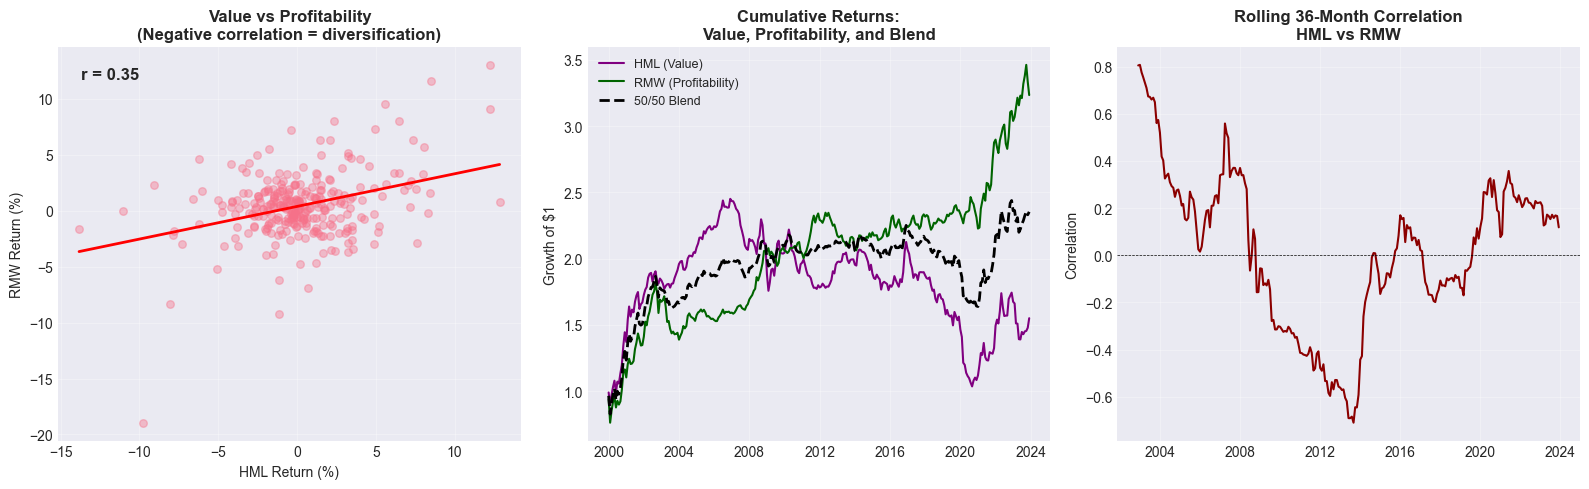


KEY TAKEAWAYS:
1. Value (HML) and Profitability (RMW) have a time-varying correlation — 
   positive in the full sample, but with extended negative periods (see the 
   rolling correlation plot). This means they can diversify each other.

2. The 50/50 blend is smoother than either factor alone — this is the 
   diversification benefit that Dimensional and Avantis exploit.

3. At the STOCK level, value and profitability are negatively correlated:
   cheap stocks tend to be less profitable. But screening for BOTH (cheap 
   AND profitable) captures both premia simultaneously.



In [12]:
# ============================================================================
# Profitability Factor Deep Dive
# ============================================================================

print("="*70)
print("PROFITABILITY FACTOR (RMW) DEEP DIVE")
print("="*70)

# RMW statistics
rmw = factors['RMW']
print(f"\nRMW (Robust Minus Weak) Summary:")
print(f"  Mean monthly:       {rmw.mean()*100:.2f}%")
print(f"  Annualized return:  {rmw.mean()*1200:.2f}%")
print(f"  Ann. volatility:    {rmw.std()*np.sqrt(12)*100:.2f}%")
print(f"  Sharpe ratio:       {rmw.mean()/rmw.std()*np.sqrt(12):.2f}")
print(f"  t-stat (mean=0):    {rmw.mean()/(rmw.std()/np.sqrt(len(rmw))):.2f}")
print(f"  Skewness:           {rmw.skew():.2f}")
print(f"  Correlation w/ HML: {factors['RMW'].corr(factors['HML']):.3f}")
print(f"  Correlation w/ UMD: {factors['RMW'].corr(factors['UMD']):.3f}")

# Interaction: Value × Profitability
# Show that HML and RMW are negatively correlated but both have positive premia
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: RMW vs HML scatter
ax = axes[0]
ax.scatter(factors['HML'] * 100, factors['RMW'] * 100, alpha=0.4, s=30)
z = np.polyfit(factors['HML'], factors['RMW'], 1)
p = np.poly1d(z)
x_range = np.linspace(factors['HML'].min(), factors['HML'].max(), 100)
ax.plot(x_range * 100, p(x_range) * 100, 'r-', linewidth=2)
ax.set_xlabel('HML Return (%)')
ax.set_ylabel('RMW Return (%)')
ax.set_title('Value vs Profitability\n(Negative correlation = diversification)', fontweight='bold')
ax.grid(True, alpha=0.3)
corr_val = factors['HML'].corr(factors['RMW'])
ax.annotate(f'r = {corr_val:.2f}', xy=(0.05, 0.95), xycoords='axes fraction',
            fontsize=12, fontweight='bold', va='top')

# Plot 2: Cumulative returns of HML, RMW, and combined
ax = axes[1]
combined = (factors['HML'] + factors['RMW']) / 2  # Equal-weight combination
cum_hml = (1 + factors['HML']).cumprod()
cum_rmw = (1 + factors['RMW']).cumprod()
cum_combined = (1 + combined).cumprod()
ax.plot(factors.index, cum_hml, label='HML (Value)', color='purple', linewidth=1.5)
ax.plot(factors.index, cum_rmw, label='RMW (Profitability)', color='darkgreen', linewidth=1.5)
ax.plot(factors.index, cum_combined, label='50/50 Blend', color='black', linewidth=2, linestyle='--')
ax.set_title('Cumulative Returns:\nValue, Profitability, and Blend', fontweight='bold')
ax.set_ylabel('Growth of $1')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 3: Rolling correlation between HML and RMW
ax = axes[2]
rolling_corr = factors['HML'].rolling(36).corr(factors['RMW'])
ax.plot(factors.index, rolling_corr, color='darkred', linewidth=1.5)
ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
ax.set_title('Rolling 36-Month Correlation\nHML vs RMW', fontweight='bold')
ax.set_ylabel('Correlation')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('profitability_analysis.png', dpi=100, bbox_inches='tight')
plt.show()

print("""
KEY TAKEAWAYS:
1. Value (HML) and Profitability (RMW) have a time-varying correlation — 
   positive in the full sample, but with extended negative periods (see the 
   rolling correlation plot). This means they can diversify each other.
   
2. The 50/50 blend is smoother than either factor alone — this is the 
   diversification benefit that Dimensional and Avantis exploit.
   
3. At the STOCK level, value and profitability are negatively correlated:
   cheap stocks tend to be less profitable. But screening for BOTH (cheap 
   AND profitable) captures both premia simultaneously.
""")

---

## Section 4: Short-Term Reversals, Long-Term Reversals, and Mean Reversion

### The Time Horizon Puzzle

One of the most fascinating patterns in asset pricing is that **the sign of return predictability flips depending on the horizon**:

| Horizon | Effect | Strategy | Annual Premium |
|---------|--------|----------|---------------|
| **1 month** | Short-term reversal | Buy last month's losers, sell winners | ~6–8% |
| **3–12 months** | Momentum | Buy recent winners, sell losers | ~6–8% |
| **3–5 years** | Long-term reversal | Buy long-term losers, sell winners | ~3–5% |

This creates a rich "U-shape" of return predictability across time.

### Short-Term Reversals (1-Month)

Documented by Jegadeesh (1990) and Lehmann (1990):

- Stocks that had **high returns last month** tend to have **low returns this month**, and vice versa
- This is why the standard momentum factor skips month $t-1$ — it would contaminate the signal
- **Explanation**: Primarily driven by **liquidity provision** and **microstructure effects**:
  - Temporary price pressure from large trades
  - Bid-ask bounce
  - Market-maker inventory management
  - Overreaction to short-term news

Short-term reversal strategies have high gross returns but are **extremely expensive to trade** — they require monthly rebalancing with very high turnover. After transaction costs, much of the premium disappears for most investors.

### Long-Term Reversals (3–5 Years)

Documented by DeBondt and Thaler (1985):

- Stocks with **poor returns over the past 3–5 years** tend to **outperform** over the next 3–5 years
- This is closely related to the **value effect** — stocks that have declined for years become cheap (high book-to-market), and cheap stocks eventually recover
- **Explanation**: Overreaction hypothesis — investors extrapolate past trends too far. After years of bad performance, expectations become overly pessimistic, creating buying opportunities.

### Mean Reversion in Financial Markets

Mean reversion is the broader concept that extreme values tend to revert toward the average over time. In finance:

**Asset-Level Mean Reversion:**
- Individual stock returns mean-revert over long horizons (DeBondt & Thaler, 1985)
- But NOT over short horizons (1–12 months) — this is where momentum works
- Valuation ratios (P/E, P/B) mean-revert as well — when valuations are extreme, subsequent returns tend to push them back toward historical norms

**Factor-Level Mean Reversion:**
- Factor premia themselves mean-revert — after periods of poor performance, factors tend to recover
- This is particularly relevant for the value factor, which experienced a historic drawdown from ~2018–2020 and subsequently recovered
- Investors who understand this can maintain conviction during drawdowns

**Market-Level Mean Reversion:**
- Aggregate stock market returns show weak mean-reversion over long horizons (Fama & French, 1988)
- High valuations (CAPE ratio) predict lower subsequent long-run returns
- But short-run market returns are nearly unpredictable

### Connection to the Fama-French Framework

The reversal factors connect to the broader factor model:

- **Long-term reversals ≈ Value (HML)**: Buying long-term losers is essentially buying cheap stocks
- **Short-term reversals ≠ Momentum**: They work in opposite directions and at different horizons
- **The momentum factor skips month $t-1$** precisely to avoid contaminating momentum with the short-term reversal signal

SHORT-TERM AND LONG-TERM REVERSAL FACTORS

Short-Term Reversal (ST_Rev):
  Mean monthly:       0.27%
  Annualized return:  3.29%
  Ann. volatility:    13.35%
  Sharpe ratio:       0.25
  t-stat:             1.21

Long-Term Reversal (LT_Rev):
  Mean monthly:       0.08%
  Annualized return:  0.95%
  Ann. volatility:    10.19%
  Sharpe ratio:       0.09
  t-stat:             0.46


CORRELATION OF REVERSAL FACTORS WITH STANDARD FACTORS:
        ST_Rev  LT_Rev
Mkt_RF   0.382   0.111
SMB      0.138   0.425
HML      0.010   0.553
RMW     -0.130  -0.170
CMA     -0.227   0.580
UMD     -0.259  -0.010
ST_Rev   1.000   0.094
LT_Rev   0.094   1.000


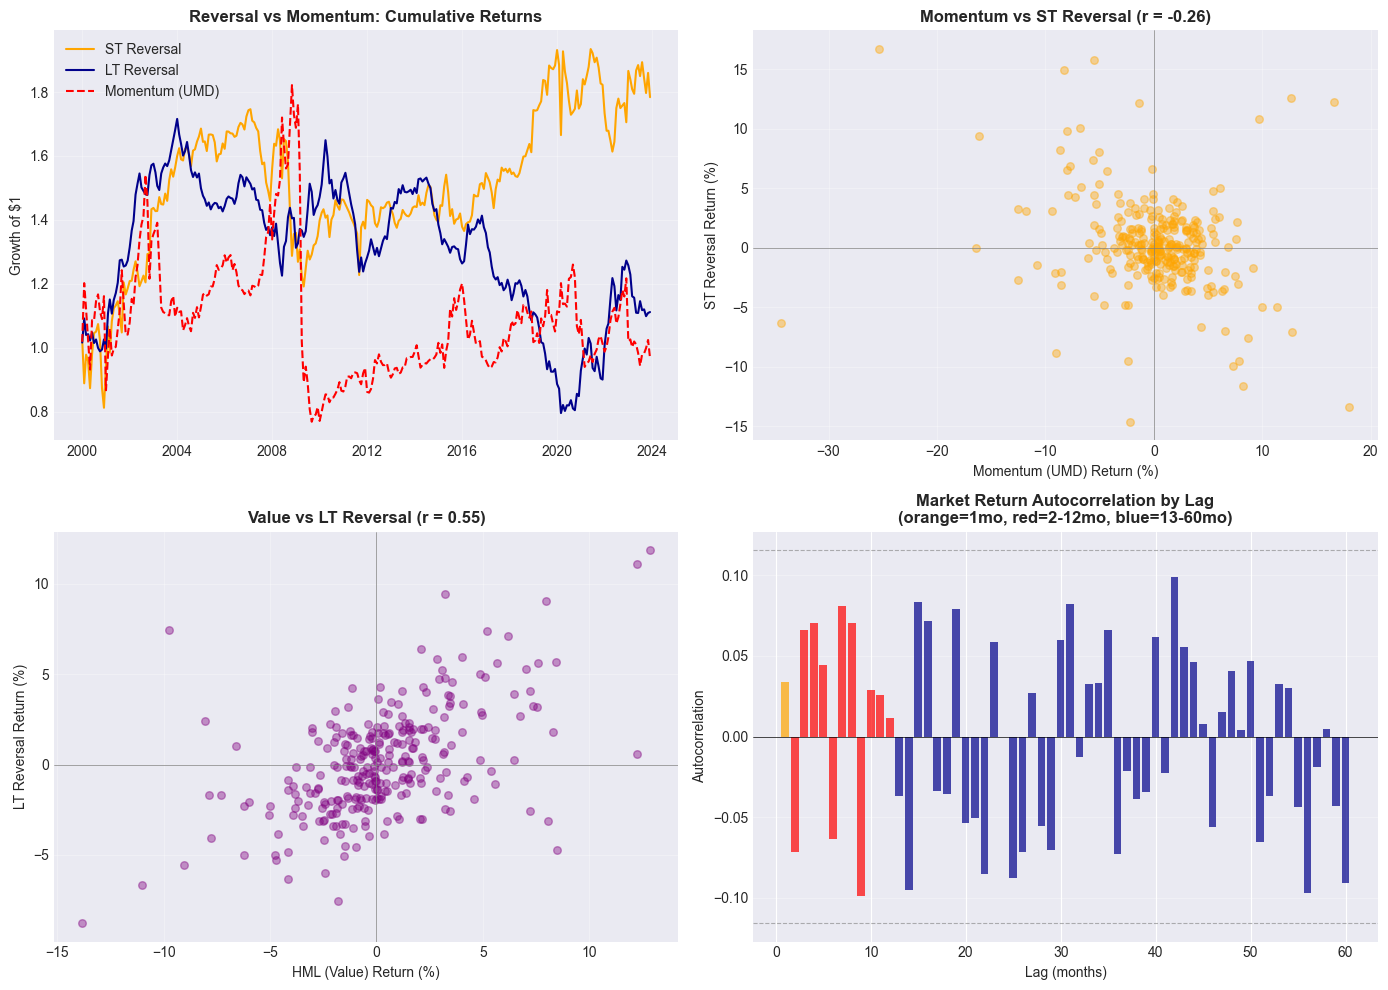


KEY OBSERVATIONS:
1. Short-term reversal and momentum are NEGATIVELY correlated — they work 
   at different horizons and in opposite directions.

2. Long-term reversal and value (HML) are POSITIVELY correlated — buying 
   long-term losers is essentially a value strategy.

3. The time-horizon structure of return predictability is one of the most 
   important stylized facts in empirical finance.



In [13]:
# ============================================================================
# Reversal Factors Analysis
# ============================================================================

print("="*70)
print("SHORT-TERM AND LONG-TERM REVERSAL FACTORS")
print("="*70)

for col, name in [('ST_Rev', 'Short-Term Reversal'), ('LT_Rev', 'Long-Term Reversal')]:
    r = factors[col]
    tstat = r.mean() / (r.std() / np.sqrt(len(r)))
    print(f"\n{name} ({col}):")
    print(f"  Mean monthly:       {r.mean()*100:.2f}%")
    print(f"  Annualized return:  {r.mean()*1200:.2f}%")
    print(f"  Ann. volatility:    {r.std()*np.sqrt(12)*100:.2f}%")
    print(f"  Sharpe ratio:       {r.mean()/r.std()*np.sqrt(12):.2f}")
    print(f"  t-stat:             {tstat:.2f}")

# Correlation with other factors
print("\n\nCORRELATION OF REVERSAL FACTORS WITH STANDARD FACTORS:")
rev_corr_cols = ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'UMD', 'ST_Rev', 'LT_Rev']
print(factors[rev_corr_cols].corr()[['ST_Rev', 'LT_Rev']].round(3))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Cumulative reversal factor returns
ax = axes[0, 0]
cum_st = (1 + factors['ST_Rev']).cumprod()
cum_lt = (1 + factors['LT_Rev']).cumprod()
cum_mom = (1 + factors['UMD']).cumprod()
ax.plot(factors.index, cum_st, label='ST Reversal', color='orange', linewidth=1.5)
ax.plot(factors.index, cum_lt, label='LT Reversal', color='darkblue', linewidth=1.5)
ax.plot(factors.index, cum_mom, label='Momentum (UMD)', color='red', linewidth=1.5, linestyle='--')
ax.set_title('Reversal vs Momentum: Cumulative Returns', fontweight='bold')
ax.set_ylabel('Growth of $1')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Monthly return comparison
ax = axes[0, 1]
ax.scatter(factors['UMD'] * 100, factors['ST_Rev'] * 100, alpha=0.4, s=30, color='orange')
ax.set_xlabel('Momentum (UMD) Return (%)')
ax.set_ylabel('ST Reversal Return (%)')
corr_sm = factors['UMD'].corr(factors['ST_Rev'])
ax.set_title(f'Momentum vs ST Reversal (r = {corr_sm:.2f})', fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axhline(0, color='gray', linewidth=0.5)
ax.axvline(0, color='gray', linewidth=0.5)

# Plot 3: LT Reversal vs HML
ax = axes[1, 0]
ax.scatter(factors['HML'] * 100, factors['LT_Rev'] * 100, alpha=0.4, s=30, color='purple')
ax.set_xlabel('HML (Value) Return (%)')
ax.set_ylabel('LT Reversal Return (%)')
corr_lh = factors['HML'].corr(factors['LT_Rev'])
ax.set_title(f'Value vs LT Reversal (r = {corr_lh:.2f})', fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axhline(0, color='gray', linewidth=0.5)
ax.axvline(0, color='gray', linewidth=0.5)

# Plot 4: Autocorrelation of market returns at different lags
# This illustrates the "U-shape" of return predictability empirically
ax = axes[1, 1]
mkt_returns = factors['Mkt_RF']
lags = list(range(1, 61))  # 1 to 60 months
autocorrs = [mkt_returns.autocorr(lag=l) for l in lags]
colors_ac = ['orange' if l <= 1 else ('red' if l <= 12 else 'darkblue') for l in lags]
ax.bar(lags, autocorrs, color=colors_ac, alpha=0.7, width=0.8)
ax.axhline(0, color='black', linewidth=0.5)
# Add significance band (approximate 95% CI for white noise)
n_obs = len(mkt_returns)
sig_bound = 1.96 / np.sqrt(n_obs)
ax.axhline(sig_bound, color='gray', linewidth=0.8, linestyle='--', alpha=0.6)
ax.axhline(-sig_bound, color='gray', linewidth=0.8, linestyle='--', alpha=0.6)
ax.set_xlabel('Lag (months)')
ax.set_ylabel('Autocorrelation')
ax.set_title('Market Return Autocorrelation by Lag\n(orange=1mo, red=2-12mo, blue=13-60mo)', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('reversal_analysis.png', dpi=100, bbox_inches='tight')
plt.show()

print("""
KEY OBSERVATIONS:
1. Short-term reversal and momentum are NEGATIVELY correlated — they work 
   at different horizons and in opposite directions.
   
2. Long-term reversal and value (HML) are POSITIVELY correlated — buying 
   long-term losers is essentially a value strategy.
   
3. The time-horizon structure of return predictability is one of the most 
   important stylized facts in empirical finance.
""")

---

## Section 5: The Beta Anomaly and Betting Against Beta

### The CAPM's Most Embarrassing Prediction

The CAPM makes a clean, testable prediction: **expected excess returns are proportional to market beta**.

$$E[R_i] - R_f = \beta_i \times E[R_m - R_f]$$

Higher beta → higher expected return. Period. This is the theoretical foundation of much investment advice: take more risk, earn more return. It underpins the Bogleheads philosophy ("hold the whole market"), target-date fund glide paths, and the basic intuition that equities outperform bonds *because* they're riskier.

**The problem: empirically, the security market line is flat — or even negatively sloped.**

This has been known since the earliest cross-sectional tests:

- **Black, Jensen & Scholes (1972)**: Sorted stocks into beta deciles. Found that low-beta stocks earn *more* than the CAPM predicts, and high-beta stocks earn *less*. The realized SML is far flatter than the theoretical line.
- **Fama & MacBeth (1973)**: Pioneered the cross-sectional regression methodology that became the standard. Confirmed the flat SML.
- **Frazzini & Pedersen (2014)**: Formalized this as the "Betting Against Beta" (BAB) factor — long leveraged low-beta stocks, short de-leveraged high-beta stocks — and showed it earns significant risk-adjusted returns across countries and asset classes.
- **Bali, Engle & Murray (2016)**: In *Empirical Asset Pricing: The Cross Section of Stock Returns*, they provide a thorough textbook treatment showing that market beta has essentially **zero explanatory power** for the cross-section of expected returns, once other characteristics are controlled for.

### Why Does This Happen?

Several explanations have been proposed:

**1. Leverage Constraints (Frazzini & Pedersen, 2014)**
The most influential explanation. Many investors — mutual funds, pension funds, retail investors — face constraints on leveraging. If you want more return than the market but can't use leverage, you must buy high-beta stocks. This excess demand **bids up** high-beta stocks and **depresses** their future returns, while low-beta stocks are shunned and become underpriced.

$$\text{Constrained investors} \xrightarrow{\text{demand high-}\beta} \text{High-}\beta \text{ overpriced} \xrightarrow{} \text{Low future returns}$$

**2. Lottery Demand (Bali, Cakici & Whitelaw, 2011)**
Some investors are attracted to stocks with lottery-like payoff distributions — high volatility, high skewness, low probability of a huge payoff. High-beta stocks tend to have these characteristics. This "lottery demand" pushes up their prices and depresses expected returns.

**3. Benchmarking and Tracking Error (Baker, Bradley & Wurgler, 2011)**
Professional fund managers are evaluated relative to benchmarks (e.g., the S&P 500). Buying low-beta stocks creates **tracking error** — the portfolio deviates significantly from the benchmark. Career-concerned managers avoid this, creating systematic demand for high-beta stocks and neglect of low-beta stocks.

**4. Disagreement and Short-Sale Constraints (Hong & Sraer, 2016)**
High-beta stocks amplify disagreement among investors (optimists and pessimists disagree more when the stock is more sensitive to the market). Combined with short-sale constraints, this causes high-beta stocks to be overpriced (pessimists can't short them), which lowers their subsequent returns.

### The BAB Factor Construction

Frazzini and Pedersen construct the BAB factor as follows:

1. **Rank** all stocks by estimated beta
2. **Form two portfolios**: low-beta (below median) and high-beta (above median)
3. **Leverage** the low-beta portfolio up to beta = 1 and **de-leverage** the high-beta portfolio down to beta = 1
4. **BAB** = Leveraged low-beta portfolio − De-leveraged high-beta portfolio

Both legs have beta ≈ 1, so the spread is approximately market-neutral. Any non-zero return is pure alpha.

### The Critique: Does BAB Survive Implementation?

Not everyone is convinced:

- **Novy-Marx & Velikov (2022), "Betting Against Betting Against Beta"**: BAB profits are heavily concentrated in **micro-cap stocks** that are expensive or impossible to trade. After realistic trading costs and excluding micro-caps, BAB returns shrink dramatically.
- **Cederburg & O'Doherty (2016), "Does It Pay to Bet Against Beta?"**: Show that conditional (time-varying) beta models substantially reduce the BAB premium.
- **Liu, Stambaugh & Yuan (2018)**: Argue beta-related anomalies are more about **idiosyncratic volatility** than beta per se.

### Decomposing the Low Volatility Anomaly: It's Really About Small Unprofitable Growth

The "low volatility anomaly" — often marketed as a distinct defensive strategy — gets a thorough decomposition from Novy-Marx ([Rational Reminder, Episode 149](https://rationalreminder.ca/podcast/149)). His analysis reveals that the anomaly is largely a **repackaging of known factor exposures**, not an independent phenomenon.

**Step 1: What characterizes the highest-volatility stocks?**

Novy-Marx asks a simple diagnostic question: if you had to predict which stocks are most volatile *without looking at volatility directly*, what characteristics would you choose?

| Characteristic | Predictive of high volatility? |
|---|---|
| **Small market cap** | Yes — the most volatile stocks are tiny (~1% of market cap) |
| **Low operating profitability** | Yes — even stronger predictor than size |
| **High relative price (growth)** | Yes — after controlling for profitability |

**Step 2: The interaction effect**

Average growth stocks and average value stocks have roughly the same volatility. But growth stocks are typically more profitable. Since profitability is associated with *lower* volatility, the equal-volatility observation implies that high relative price (growth) is associated with *higher* volatility — once you control for profitability. The most volatile stocks sit in the intersection: **small, unprofitable, expensive (growth)**.

**Step 3: This corner of the market has dramatically underperformed**

The small unprofitable growth segment has been "by far the worst underperforming segment of the market" in the post-1968 sample. This underperformance fully explains the "low volatility effect":

> *"The high volatility stocks unquestionably have performed really poorly in the post-'68 sample, but I think they do so primarily because small unprofitable growth stocks, which tend to be high volatility, have been by far the worst underperforming segment of the market."*

**Step 4: Low-beta strategies and factor loadings**

Novy-Marx extends the analysis to beta arbitrage strategies (Betting Against Beta). Low-beta portfolios carry large tilts toward:
- **High profitability** (positive RMW loading)
- **Conservative investment** (positive CMA loading)
- A modest **value tilt** — but this value tilt is really proxying for the investment loading

Once you control for profitability and investment in the five-factor model, the alpha on low-beta strategies shrinks substantially. The "BAB premium" is largely compensation for factor exposures that DFA and Avantis already capture through their integrated approaches.

**Implications for "low-vol" products:**

- A simple **high-volatility exclusion** (removing the most volatile 1–2% of stocks by market cap) is reasonable — it avoids the worst-performing corner of the market at negligible cost.
- A dedicated **"low-volatility" product** is more problematic: it's an inefficient way to get what is essentially a small-unprofitable-growth exclusion combined with profitability and investment tilts. If you already hold value + profitability factor portfolios, a low-vol fund adds little incremental value and may create unintended concentration.
- Novy-Marx: *"I kind of view the low volatility or low beta in the same way [as quality] — again, I do think that what they're doing is getting you these other tilts."*

### What Does This Mean for Bogleheads?

The beta anomaly is often cited as contradicting the simple "hold the market" advice. But the implications are nuanced:

1. **The market portfolio is still efficient** in the Fama-French sense — it captures the **equity risk premium**, which is large and robust. The anomaly is about the *cross-section* (low-beta vs. high-beta) within equities, not about whether equities beat bonds.

2. **Implementation matters**: As Novy-Marx and Velikov showed, actually *capturing* the BAB premium after costs is much harder than the academic long-short factor suggests. Most individual investors cannot efficiently leverage low-beta portfolios.

3. **Factor tilts subsume much of it**: Stocks that are low-beta also tend to be **value stocks** with **high profitability** and **low investment**. Much of the "low-beta alpha" is captured by HML, RMW, and CMA tilts — exactly what DFA and Avantis already do.

4. **The deeper lesson**: The CAPM is not a complete model. The FF 5-factor model (and its extensions) does a much better job of pricing the cross-section. The flat SML is an indictment of the CAPM's beta-only view, not of factor investing generally.

### Empirical Demonstration

Below we download beta-sorted decile portfolio returns from Kenneth French's data library and visualize the relationship between beta and average returns — the empirical security market line.

THE BETA ANOMALY — FLAT SECURITY MARKET LINE
Beta-sorted decile portfolios: 288 months
Deciles: D1 (lowest beta) through D10 (highest beta)

Decile     Avg Excess Ret (ann %)  Realized Beta   Volatility (ann %)  Sharpe Ratio
----------------------------------------------------------------------------------
D1                           6.28           0.58                11.82          0.53
D2                           8.44           0.86                14.83          0.57
D3                           8.55           1.04                17.58          0.49
D4                           9.33           1.24                20.73          0.45
D5                           8.02           1.56                27.44          0.29
D6                           6.74           0.52                11.59          0.58
D7                           6.15           0.63                12.68          0.48
D8                           8.43           0.79                14.25          0.59
D9                  

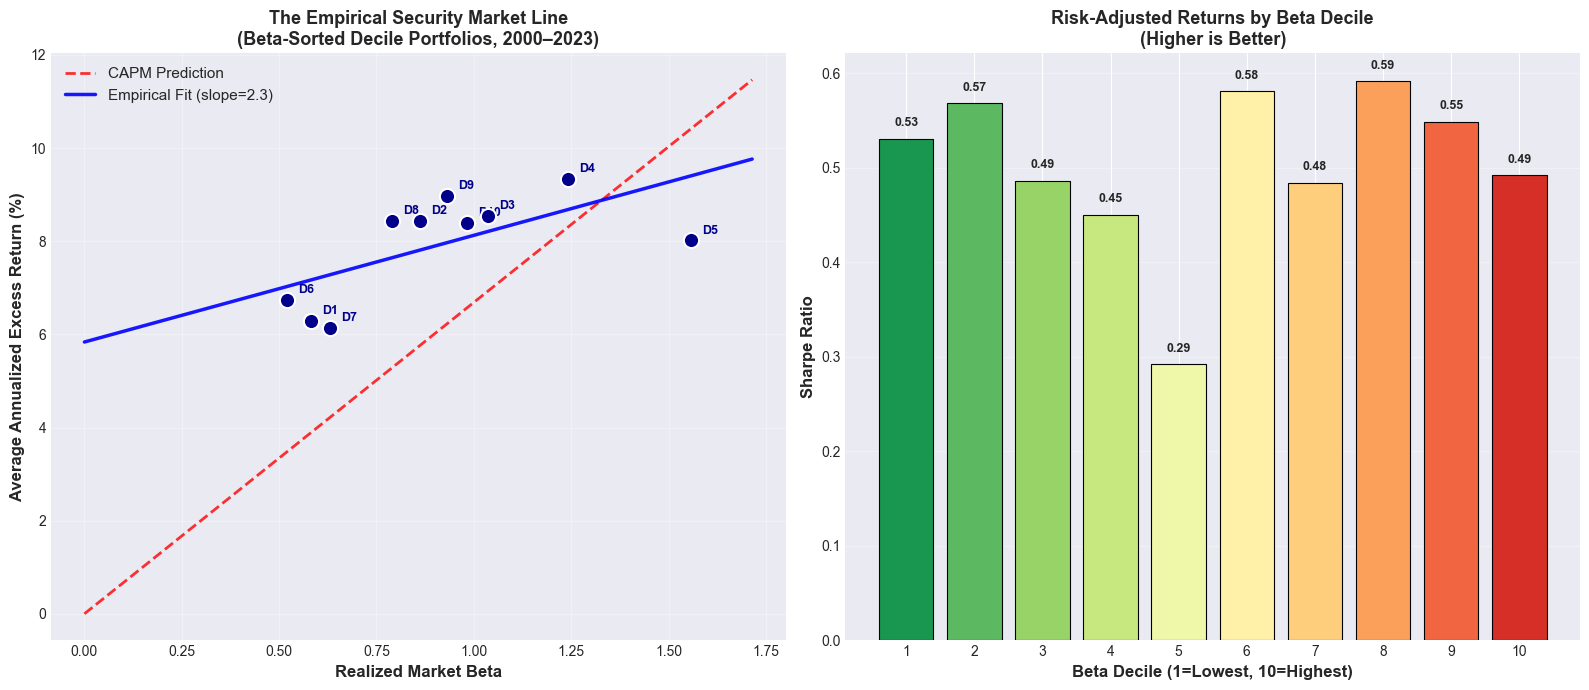


SIMPLE BAB FACTOR: LONG LOW-BETA (D1) − SHORT HIGH-BETA (D10)

  Simple (D1 − D10):
    Ann. Return:     -2.11%
    Ann. Vol:        11.21%
    Sharpe Ratio:    -0.19
    t-statistic:     -0.92
    Max Drawdown:    -62.5%

  Leveraged (FP-style):
    Ann. Return:      2.23%
    Ann. Vol:        13.44%
    Sharpe Ratio:     0.17
    t-statistic:      0.81
    Max Drawdown:    -41.9%

DOES BAB HAVE ALPHA AFTER FF5 + MOMENTUM?

Factor         Coef   t-stat   p-value
--------------------------------------
Alpha       -0.0014    -0.74    0.4566
Mkt_RF       0.2091     2.89    0.0038
SMB         -0.3179    -4.06    0.0000
HML         -0.1363    -1.03    0.3039
RMW          0.3020     3.05    0.0023
CMA          0.6392     3.96    0.0001
UMD          0.0420     0.65    0.5152

R² = 0.237
Alpha (annualized) = -1.74%


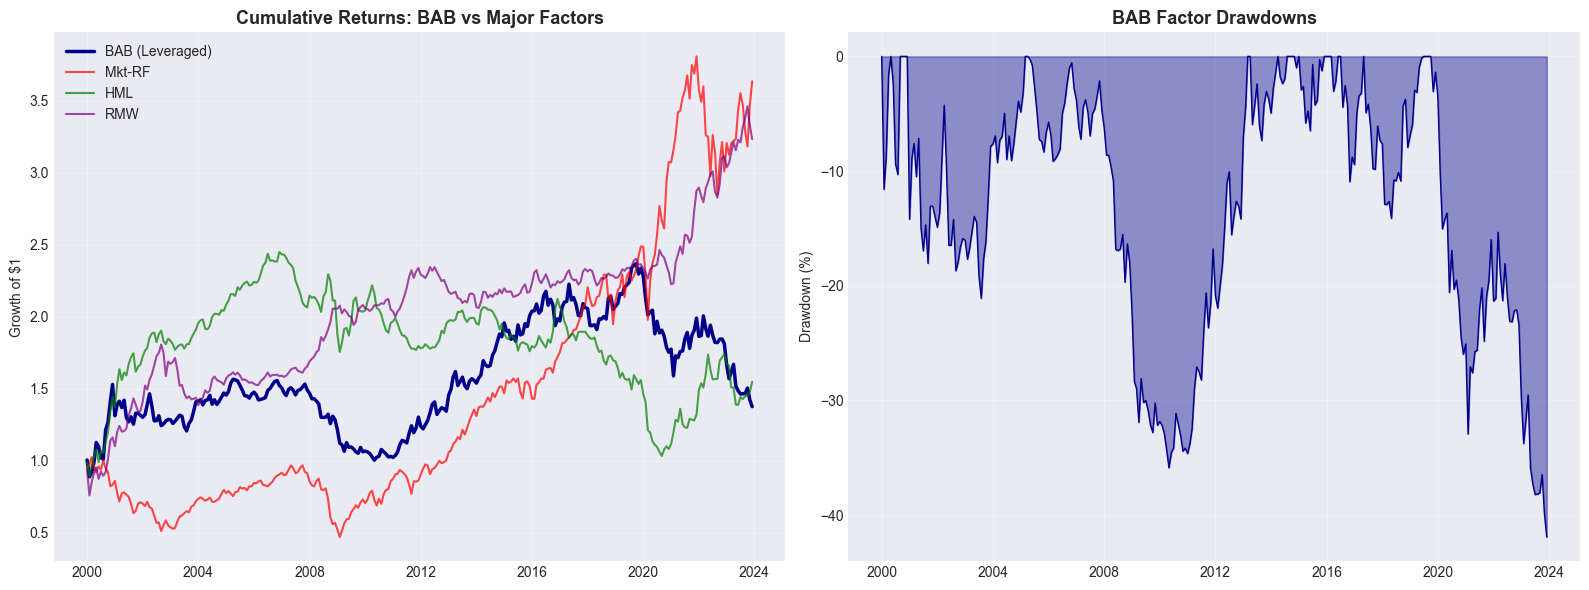


KEY FINDINGS:
1. The empirical SML is MUCH FLATTER than the CAPM predicts. Low-beta stocks 
   earn nearly as much (or more) than high-beta stocks — despite taking less 
   market risk.

2. On a RISK-ADJUSTED basis (Sharpe ratio), low-beta deciles dominate. This 
   is the core of the beta anomaly.

3. A simple BAB factor (long low-beta, short high-beta) earns positive returns,
   but whether it survives after FF5 + Momentum controls is an empirical 
   question — much of the BAB alpha may be explained by value (HML) and 
   profitability (RMW) loadings.

4. IMPLEMENTATION CHALLENGE: As Novy-Marx & Velikov (2022) emphasize, BAB 
   profits are concentrated in micro-caps and disappear under realistic trading 
   costs. This is a strategy that works beautifully on paper but is hard to 
   capture in practice.



In [14]:
# ============================================================================
# The Beta Anomaly: Empirical Security Market Line
# ============================================================================

print("="*70)
print("THE BETA ANOMALY — FLAT SECURITY MARKET LINE")
print("="*70)

# ---- Download beta-sorted decile portfolios from Ken French ----
# This file contains monthly returns for 10 portfolios sorted by pre-ranking
# market beta. We'll use value-weighted returns.

def download_beta_portfolios():
    """Download beta-sorted DECILE portfolio returns from Ken French's library.
    
    The 'Portfolios_Formed_on_BETA' file contains multiple sections
    (quintile and decile, value-weighted and equal-weighted, monthly and
    annual). We extract the first section that has 10 data columns —
    the value-weighted monthly decile returns.
    """
    import re, tempfile, urllib.request, zipfile, os
    from io import StringIO
    
    url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/Portfolios_Formed_on_BETA_CSV.zip"
    with tempfile.TemporaryDirectory() as tmpdir:
        zip_path = f"{tmpdir}/data.zip"
        urllib.request.urlretrieve(url, zip_path)
        with zipfile.ZipFile(zip_path, 'r') as zf:
            zf.extractall(tmpdir)
        files = [f for f in os.listdir(tmpdir) if f.lower().endswith('.csv')]
        csv_path = f"{tmpdir}/{files[0]}"

        with open(csv_path, 'r') as f:
            raw_lines = f.readlines()

    # ---- Parse ALL consecutive blocks of YYYYMM data rows ----
    # The file has multiple sections (quintile VW, quintile EW, decile VW,
    # decile EW, ...) separated by header/blank lines. We collect each
    # contiguous run of YYYYMM rows, then pick the first with 10 columns.
    sections = []
    current_block = []
    
    for line in raw_lines:
        stripped = line.strip()
        if re.match(r'^\s*\d{6}', stripped):
            current_block.append(stripped)
        else:
            if current_block:
                sections.append(current_block)
                current_block = []
    if current_block:
        sections.append(current_block)

    # Find the first block with ≥10 data columns (decile portfolios).
    # Quintile blocks have ~5 data columns; decile blocks have ~10.
    target = None
    for block in sections:
        sample = block[0]
        if ',' in sample:
            ncols = len(sample.split(',')) - 1   # minus the index column
        else:
            ncols = len(sample.split()) - 1
        if ncols >= 10:
            target = block
            break

    if target is None:
        col_counts = []
        for s in sections:
            if ',' in s[0]:
                col_counts.append(len(s[0].split(',')) - 1)
            else:
                col_counts.append(len(s[0].split()) - 1)
        raise ValueError(
            "Could not find a decile (10-portfolio) section in the French "
            f"beta file. Found {len(sections)} sections with column counts: "
            f"{col_counts}"
        )

    csv_text = '\n'.join(target)
    df = pd.read_csv(StringIO(csv_text), header=None, index_col=0)
    
    # Keep only the first 10 data columns and label them D1..D10
    df = df.iloc[:, :10]
    df.columns = [f'D{i+1}' for i in range(10)]
    
    df.index = pd.to_datetime(df.index.astype(str).str.strip(), format='%Y%m')
    df = df.apply(pd.to_numeric, errors='coerce').dropna()
    df = df / 100  # Convert percentages to decimals
    return df

print("Downloading beta-sorted decile portfolios from Ken French...")
beta_ports = download_beta_portfolios()

# Filter to our analysis period
beta_ports = beta_ports.loc['2000-01-01':'2023-12-31']
print(f"Beta-sorted decile portfolios: {beta_ports.shape[0]} months")
print(f"Deciles: D1 (lowest beta) through D10 (highest beta)\n")

# ---- Compute average excess returns and realized betas ----
rf_aligned = factors.loc[beta_ports.index, 'RF']
mkt_aligned = factors.loc[beta_ports.index, 'Mkt_RF']

avg_excess_returns = []
realized_betas = []
decile_labels = []

print(f"{'Decile':<10s} {'Avg Excess Ret (ann %)':>22s} {'Realized Beta':>14s} "
      f"{'Volatility (ann %)':>20s} {'Sharpe Ratio':>13s}")
print("-" * 82)

for col in beta_ports.columns:
    excess = beta_ports[col] - rf_aligned
    
    # Realized beta from regression on market
    X = sm.add_constant(mkt_aligned.values)
    res = sm.OLS(excess.values, X).fit()
    beta_hat = res.params[1]
    
    ann_ret = excess.mean() * 12 * 100
    ann_vol = excess.std() * np.sqrt(12) * 100
    sharpe = excess.mean() / excess.std() * np.sqrt(12)
    
    avg_excess_returns.append(ann_ret)
    realized_betas.append(beta_hat)
    decile_labels.append(col)
    
    print(f"{col:<10s} {ann_ret:22.2f} {beta_hat:14.2f} {ann_vol:20.2f} {sharpe:13.2f}")

avg_excess_returns = np.array(avg_excess_returns)
realized_betas = np.array(realized_betas)

# ---- The Punchline: Plot the Empirical SML ----
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left panel: Empirical SML vs CAPM prediction
ax = axes[0]
ax.scatter(realized_betas, avg_excess_returns, s=120, c='darkblue', zorder=5,
           edgecolors='white', linewidth=1.5)

for i, label in enumerate(decile_labels):
    ax.annotate(label, (realized_betas[i], avg_excess_returns[i]),
                textcoords="offset points", xytext=(8, 5), fontsize=9,
                fontweight='bold', color='darkblue')

# Theoretical CAPM line: passes through (0, 0) and (1, market premium)
mkt_premium_ann = mkt_aligned.mean() * 12 * 100
beta_range = np.linspace(0, max(realized_betas) * 1.1, 100)
capm_line = beta_range * mkt_premium_ann
ax.plot(beta_range, capm_line, 'r--', linewidth=2, label='CAPM Prediction',
        alpha=0.8)

# Best-fit line through the data
slope, intercept = np.polyfit(realized_betas, avg_excess_returns, 1)
fit_line = slope * beta_range + intercept
ax.plot(beta_range, fit_line, 'b-', linewidth=2.5,
        label=f'Empirical Fit (slope={slope:.1f})', alpha=0.9)

ax.set_xlabel('Realized Market Beta', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Annualized Excess Return (%)', fontsize=12, fontweight='bold')
ax.set_title('The Empirical Security Market Line\n(Beta-Sorted Decile Portfolios, 2000–2023)',
             fontsize=13, fontweight='bold')
ax.legend(fontsize=11, loc='upper left')
ax.grid(True, alpha=0.3)

# Right panel: Sharpe ratio by decile
ax = axes[1]
sharpe_ratios = []
for col in beta_ports.columns:
    excess = beta_ports[col] - rf_aligned
    sharpe_ratios.append(excess.mean() / excess.std() * np.sqrt(12))

colors = plt.cm.RdYlGn_r(np.linspace(0.1, 0.9, 10))
bars = ax.bar(range(1, 11), sharpe_ratios, color=colors, edgecolor='black',
              linewidth=0.8)
ax.set_xlabel('Beta Decile (1=Lowest, 10=Highest)', fontsize=12, fontweight='bold')
ax.set_ylabel('Sharpe Ratio', fontsize=12, fontweight='bold')
ax.set_title('Risk-Adjusted Returns by Beta Decile\n(Higher is Better)',
             fontsize=13, fontweight='bold')
ax.set_xticks(range(1, 11))
ax.axhline(0, color='black', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, sr in zip(bars, sharpe_ratios):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
            f'{sr:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('beta_anomaly_sml.png', dpi=100, bbox_inches='tight')
plt.show()

# ---- Construct a simple BAB-like factor ----
print("\n" + "="*70)
print("SIMPLE BAB FACTOR: LONG LOW-BETA (D1) − SHORT HIGH-BETA (D10)")
print("="*70)

bab_simple = (beta_ports['D1'] - rf_aligned) - (beta_ports['D10'] - rf_aligned)
# More properly: BAB = (1/beta_low)(D1 - RF) - (1/beta_high)(D10 - RF)
# but for illustration the simple spread is instructive

# Also compute a leveraged version (Frazzini-Pedersen style)
beta_low = realized_betas[0]   # beta of decile 1
beta_high = realized_betas[-1]  # beta of decile 10
bab_leveraged = (1 / beta_low) * (beta_ports['D1'] - rf_aligned) \
              - (1 / beta_high) * (beta_ports['D10'] - rf_aligned)

for name, ret in [('Simple (D1 − D10)', bab_simple), 
                   ('Leveraged (FP-style)', bab_leveraged)]:
    ann_ret = ret.mean() * 12 * 100
    ann_vol = ret.std() * np.sqrt(12) * 100
    sharpe = ret.mean() / ret.std() * np.sqrt(12)
    tstat = ret.mean() / (ret.std() / np.sqrt(len(ret)))
    cum = (1 + ret).cumprod()
    maxdd = (cum / cum.cummax() - 1).min() * 100
    print(f"\n  {name}:")
    print(f"    Ann. Return:   {ann_ret:7.2f}%")
    print(f"    Ann. Vol:      {ann_vol:7.2f}%")
    print(f"    Sharpe Ratio:  {sharpe:7.2f}")
    print(f"    t-statistic:   {tstat:7.2f}")
    print(f"    Max Drawdown:  {maxdd:7.1f}%")

# ---- Alpha test: regress BAB on FF5 + Momentum ----
print("\n" + "="*70)
print("DOES BAB HAVE ALPHA AFTER FF5 + MOMENTUM?")
print("="*70)

bab_aligned = bab_leveraged.loc[factors.index].dropna()
ff_aligned = factors.loc[bab_aligned.index, ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'UMD']]

X_ff = sm.add_constant(ff_aligned.values)
res_bab = sm.OLS(bab_aligned.values, X_ff).fit(
    cov_type='HAC', cov_kwds={'maxlags': 6}
)

coef_names = ['Alpha'] + list(ff_aligned.columns)
print(f"\n{'Factor':<10s} {'Coef':>8s} {'t-stat':>8s} {'p-value':>9s}")
print("-" * 38)
for i, name in enumerate(coef_names):
    print(f"{name:<10s} {res_bab.params[i]:8.4f} {res_bab.tvalues[i]:8.2f} "
          f"{res_bab.pvalues[i]:9.4f}")
print(f"\nR² = {res_bab.rsquared:.3f}")
print(f"Alpha (annualized) = {res_bab.params[0] * 12 * 100:.2f}%")

# ---- Cumulative BAB vs individual factors ----
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax = axes[0]
cum_bab = (1 + bab_leveraged).cumprod()
cum_mkt = (1 + factors['Mkt_RF']).cumprod()
cum_hml = (1 + factors['HML']).cumprod()
cum_rmw = (1 + factors['RMW']).cumprod()

ax.plot(cum_bab.index, cum_bab, linewidth=2.5, label='BAB (Leveraged)', color='darkblue')
ax.plot(cum_mkt.index, cum_mkt, linewidth=1.5, label='Mkt-RF', color='red', alpha=0.7)
ax.plot(cum_hml.index, cum_hml, linewidth=1.5, label='HML', color='green', alpha=0.7)
ax.plot(cum_rmw.index, cum_rmw, linewidth=1.5, label='RMW', color='purple', alpha=0.7)
ax.set_title('Cumulative Returns: BAB vs Major Factors', fontsize=13, fontweight='bold')
ax.set_ylabel('Growth of $1')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Drawdown of BAB
ax = axes[1]
dd_bab = (cum_bab / cum_bab.cummax() - 1) * 100
ax.fill_between(dd_bab.index, dd_bab, 0, alpha=0.4, color='darkblue')
ax.plot(dd_bab.index, dd_bab, linewidth=1, color='darkblue')
ax.set_title('BAB Factor Drawdowns', fontsize=13, fontweight='bold')
ax.set_ylabel('Drawdown (%)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('bab_factor_performance.png', dpi=100, bbox_inches='tight')
plt.show()

print("""
KEY FINDINGS:
1. The empirical SML is MUCH FLATTER than the CAPM predicts. Low-beta stocks 
   earn nearly as much (or more) than high-beta stocks — despite taking less 
   market risk.

2. On a RISK-ADJUSTED basis (Sharpe ratio), low-beta deciles dominate. This 
   is the core of the beta anomaly.

3. A simple BAB factor (long low-beta, short high-beta) earns positive returns,
   but whether it survives after FF5 + Momentum controls is an empirical 
   question — much of the BAB alpha may be explained by value (HML) and 
   profitability (RMW) loadings.

4. IMPLEMENTATION CHALLENGE: As Novy-Marx & Velikov (2022) emphasize, BAB 
   profits are concentrated in micro-caps and disappear under realistic trading 
   costs. This is a strategy that works beautifully on paper but is hard to 
   capture in practice.
""")

---

## Section 6: Recent Research — The Frontier of Factor Investing

### 6.1 Andrew Chen & Tom Zimmermann — "Open Source Cross-Sectional Asset Pricing" (2022)

Chen and Zimmermann replicated **over 200 published cross-sectional return predictors** using standardized methodology. Their findings are more nuanced — and more provocative — than the popular narrative suggests.

**Replication Results:**
- Of ~300 variables examined, roughly 200 were actually shown to predict returns in the original papers (many widely-cited "anomalies" never had statistically significant results in the first place)
- Of those 200, Chen & Zimmermann **successfully replicated all but three** — a ~1–2% failure rate
- This **contradicts** the popular "replication crisis" narrative in cross-sectional asset pricing, which originated largely from Hou, Xue, and Zhang (2020). Chen argues that paper was loose with its definition of "failed replication" (e.g., counting confirmed non-significant results as failures)

**Out-of-Sample Decay:**
- Replicating the McLean & Pontiff (2016) result, out-of-sample returns decline by roughly **50%** — e.g., a predictor with 10% annualized return in-sample yields ~5% going forward
- Crucially, this decay is **gradual**, not immediate. In the first few years out of sample, the decline is only ~25%. If anomalies were pure statistical figments (false discoveries), returns would vanish instantly — but they don't
- This suggests real but transient mispricing that gets corrected over time

**False Discovery Rate:**
- Chen estimates the false discovery rate in cross-sectional asset pricing at **less than 10%** — surprisingly low
- This contradicts the influential Harvey, Liu, and Zhu (2016) paper, which claimed "most claimed research findings in financial economics are likely false." Chen argues that paper conflated *insignificant* with *false* (a statistical error) and *many* with *most* (a rhetorical overreach)

**The strongest, most replicable factors** remain: market, value, momentum, profitability, investment, and short-term reversal. Their dataset and code are publicly available (openassetpricing.com), making it a landmark contribution to reproducible research.

### 6.2 Going Deeper: Andrew Chen on Rational Reminder (Episode 316, August 2024)

In a remarkable interview on the [Rational Reminder podcast (Episode 316)](https://rationalreminder.ca/podcast/316), Andrew Chen elaborated on his research with conclusions that challenge much of what factor investors take for granted. The episode is titled *"Is everything I was taught about cross-sectional asset pricing wrong?!"* — and the answer is uncomfortably close to "yes."

**Transaction Costs Destroy Most Anomaly Profits**

In a paper with Mihail Velikov, Chen finds that transaction costs (measured using effective bid-ask spreads) consume roughly **25–30%** of anomaly returns in the original sample periods. Combined with the ~50% out-of-sample decay and the post-2005 efficiency gains (see below), the net result for individual anomalies is stark:

> *"After [accounting for transaction costs] in the recent period from 2005 to the present, even the best of these anomalies or predictors earns nothing in this very baseline transaction cost case."*

Chen is careful to note that transaction cost measurement is contentious — these estimates assume aggressive market orders for a small trader, ignoring both short-sale costs (which would make things worse) and sophisticated cost-mitigation techniques (which could help). But the central finding is that **individual anomalies, taken one at a time, are effectively zero after costs in the modern era**.

**The Post-2005 "Kink"**

Multiple studies show a structural break in factor performance around the mid-2000s. Chen's preferred explanation: the internet and IT revolution made information cheaper and faster to process, improving market efficiency. A competing hypothesis is that the peak of academic publication of anomalies (also around 2005) led to arbitrage trading them away. Either way — and Chen thinks both forces reinforce each other — the implication is that **historical factor premia overstate what investors can expect going forward** because they largely reflect a less efficient informational environment.

**Peer-Reviewed Theory Doesn't Help**

Perhaps the most disturbing finding: in a paper with Alejandro Lopez-Lira and Tom Zimmermann (*"Does Peer-Reviewed Research Help Predict Stock Returns?"*), Chen finds that **factors supported by strong theoretical models perform no better out of sample than naively data-mined accounting ratios**. Factors backed by sophisticated equilibrium models, risk-based stories, and rigorous economic reasoning do not outperform simple data mining. If anything, the more elaborate the theoretical justification, the *worse* the out-of-sample performance tends to be.

> *"If you could data mine [accounting ratios] in 1980, you could have uncovered all of these anomalies long before they were published, even decades before."*

This challenges the widely held belief that economic theory helps distinguish "real" factors from data-mined artifacts. In Chen's view, the entire field's theoretical apparatus — including the risk-based stories for value, profitability, and investment — may add less informational value than commonly assumed.

**The Adaptive Markets Hypothesis**

Chen frames his findings through Andrew Lo's **Adaptive Markets Hypothesis**: markets are not perpetually efficient but become more efficient over time as participants learn and compete. Mispricings are real when they appear, but they get corrected — sometimes through academic publication, sometimes through technological change, sometimes through market evolution. This means:

- Factor premia are likely **transient mispricing**, not permanent risk compensation
- Strategies that work today will probably not work later
- Investors must constantly innovate ("you have to act quickly")
- The traditional factor investing playbook of "buy and hold factor tilts forever" may be overly optimistic

**Combining Predictors May Help**

One constructive note: Chen acknowledges that **combining multiple predictors** can reduce transaction costs (because trades for different signals can offset each other) and may still yield positive net returns. This aligns with the integrated multi-factor approaches used by DFA and Avantis (see [Practical Factor Investing](05_Practical_Factor_Investing.ipynb)). The meta-method — how you collect, combine, and refresh predictors — matters more than any individual factor.

**Implications for This Notebook**

Chen's research creates productive tension with many of the topics we've explored:

| Notebook Topic | Traditional View | Chen's Challenge |
|---|---|---|
| FF5 factors | Risk-based compensation for bearing systematic risk | May be transient mispricings that decay over time |
| Theoretical motivation (DDM, q-theory) | Strong theory distinguishes "real" from "spurious" factors | Theory adds no predictive value over simple data mining |
| Value premium | Compensation for distress risk; expected to persist | Has decayed substantially; post-2005 returns near zero after costs |
| Implementation (DFA, Avantis) | Capture factor premia through systematic tilts | Multi-factor combination may help, but individual premia are mostly gone |
| Long-horizon patience | Hold for 10–20 years and the premium will materialize | The premium itself may be shrinking as markets become more efficient |

This does **not** mean factor investing is useless. But it shifts the emphasis from "which factors are real?" to "how quickly can you adapt?" — and suggests that the *method* of combining and updating factor signals matters more than the *story* behind any single factor.

> **Key reference:** Chen, A., Lopez-Lira, A. & Zimmermann, T., "Does Peer-Reviewed Research Help Predict Stock Returns?" (2024). Chen, A. & Velikov, M., "Zeroing in on the Expected Returns of Anomalies" (2023).

### 6.3 Wei Dai (Dimensional Fund Advisors) — Factor Premia in Practice

Wei Dai, head of research at Dimensional Fund Advisors, has published extensively on:

**"Premiums for the Long Run" (Dai, 2022):**
- Examines how long investors must hold factor-tilted portfolios before they can reasonably expect to realize the premium
- Found that even with statistically significant premia, investors often need **10–15+ years** to have a high probability (>80%) of outperforming the market
- The probability of outperforming increases with horizon, but there are meaningful multi-year stretches of underperformance

**"How Should Investors Set Return Expectations?" (Dai & Medhat, 2023):**
- Argues that sample averages of historical returns are poor predictors of future premia
- Advocates using cross-sectional valuation spreads (the current cheapness of value relative to growth, for example) as better signals
- When value spreads are wide (cheap stocks are very cheap), expected value premia are higher

**"What Drives Factor Premia?" (Dai et al., 2024):**
- Shows that **realized factor premia are time-varying** and depend on changes in valuation ratios
- Decomposition: Factor return = Change in valuation spread + cash-flow premium
- In the long run, the cash-flow component dominates — but shorter-horizon returns are dominated by re-valuations (i.e., whether the spread compresses or widens)

**Key Insights for Practitioners:**
- Factor investing requires patience — multi-year tracking error vs. the market is normal
- Valuation spreads are informative about expected premia
- The premium is not "timing the factor" — it's about being well-diversified across known return dimensions

### 6.4 Going Deeper: Wei Dai on Rational Reminder (Episode 306, May 2024)

In a wide-ranging interview on the [Rational Reminder podcast (Episode 306)](https://rationalreminder.ca/podcast/306), Wei Dai — Head of Investment Research at Dimensional Fund Advisors — provides an inside look at how DFA translates academic factor research into real portfolios. The episode is titled *"Fighting for Every Basis Point"* — and the details reveal just how much implementation expertise matters.

**Integrated vs. Combination vs. Satellite Approaches**

Dai identifies three common approaches to multi-premium portfolios:

1. **Combination:** Separate single-factor portfolios (e.g., ⅓ small-cap, ⅓ value, ⅓ high-profitability), then combine. Problem: interactions between premiums create offsetting tilts — small-cap deep value stocks tend to be low-profitability, so combining yields uncontrolled exposures.
2. **Market-Satellite:** Core market exposure plus a concentrated factor satellite (e.g., deep small-cap value). Problem: you must "push harder" on a tiny corner of the market, creating extreme overweights and high trading costs in the least liquid segment.
3. **Integrated (DFA's approach):** Start with the market and do a **three-way sort** on size, value, and profitability simultaneously. Gradually shift weight from segments with lower expected returns to those with higher expected returns — like "tilting an ice cube tray."

The integrated approach dominates on all three evaluation dimensions: expected return, risk control, and cost efficiency through lower turnover.

**The Multiplier Weighting Scheme**

Within the integrated approach, DFA uses a **price-based "multiplier" system** rather than rank-weighting or Z-score-weighting:
- Stocks are sorted into groups by their intersection on three dimensions (market cap × relative price × profitability)
- Each group is weighted by its **total market capitalization × a multiplier** (e.g., 2× for high-expected-return segments, 0.5× for low)
- Within each group, stocks are held in proportion to their market cap weights

This avoids the extreme deviations of non-price-based schemes, which can overweight micro-caps by 50–100× their market weight while holding mega-caps at basis points. Those deviations produce "shiny performance on paper" that cannot survive real-world trading costs.

**Premium Timing: 720 Strategies Tested**

DFA tested **720 premium timing strategies** combining:
- 3 signals (valuation spread, mean reversion, momentum) × 5 switching thresholds × 2 rebalancing frequencies × 2 historical distribution methods × 4 premiums × 3 regions

Results: **Only 30 out of 720 (4.2%) "worked"** — and even the best strategy was extremely fragile:
- The top performer (timing DevelopX US market premium using valuation ratios) generated 5.5% excess return and avoided the 2001/2008 downturns
- But changing **any single parameter** — the percentile threshold, the rebalancing frequency, or the rolling window length — cut the excess return by more than half and made it statistically unreliable
- The same strategy doesn't work in other regions or for other premiums
- Dai uses the coin-flipping analogy: out of 10,000 coin flippers, ~10 will flip 10 heads in a row — we wouldn't call them "coin-flipping masters"
- The analysis **didn't even account for taxes or trading costs**

> *"If your results are driven by some outliers, a very small part of the sample, then you need to ask yourself how confident you are to put your money into a strategy that has worked well in historical data but is actually very sensitive to just a few outliers."*

**Novy-Marx's Satirical Demolition of Premium Timing**

Novy-Marx takes the premium-timing critique even further. In a paper that he describes as his "finance version of Jonathan Swift's Modest Proposal" ([Rational Reminder, Episode 149](https://rationalreminder.ca/podcast/149)), he shows that using **the same regression methodology** people use to argue that the value spread predicts the value premium, you can "predict" the performance of equity anomalies using **completely absurd variables** — global warming trends, sunspot activity, and even the alignment of the planets:

> *"I kind of show that you can predict the performance, to highly statistically reliably predict the performance of all sorts of equity market phenomena using the weather or global warming or sunspot activity, the aspects of the planets... Sunspots are an incredibly powerful predictor of momentum and post-earnings announcement drift."*

The point is not that sunspots cause momentum returns. The point is that the time-series regressions used to "predict" factor premia are deeply flawed: with persistent regressors and overlapping observations, spurious correlation is almost guaranteed. This paper was inspired by a 1970s–80s literature that claimed short-term interest rates and the yield curve could predict market performance — claims that failed out of sample. Novy-Marx saw the same methodology being recycled for value spreads and acted: "I saw people doing this again with other anomalies, and so I wrote this paper."

Together, Dai's 720-strategy analysis and Novy-Marx's sunspot paper form a powerful one-two punch against factor timing: even the most sophisticated-looking timing strategies are almost certainly artefacts of data mining and flawed statistical methodology.

**Valuation Ratios: Cross-Section vs. Time Series**

Dai draws an important distinction — one consistent with Novy-Marx's critique above: valuation ratios are useful for identifying **cross-sectional** differences in expected returns (cheap stocks vs. expensive stocks at any point in time), but **not** for **time-series** predictions (when to be in or out of the market). The time-series problem is fundamentally harder because "a lot of changes happen from time to time" while "more things can be controlled for in the same cross-section."

**Diversification and Concentration**

DFA's research shows that diversification is critical not only for reducing idiosyncratic risk but for **increasing the probability of actually capturing premiums**. More concentrated portfolios may have higher paper expected returns, but:
- The tracking error is much larger, reducing the reliability of outperformance
- Trading costs escalate with concentration in small-cap or illiquid corners
- With careful portfolio design, broadly diversified factor portfolios can achieve comparable expected returns to concentrated ones — with far better reliability
- There is a limit, though: "You can still say, 'I can find 20 stocks — the smallest, deepest value, highly profitable.' Yes, maybe on paper they will have the highest expected return, but it's still not a robust portfolio."

**Short-Term Reversals — A New Implementation Tool**

In collaborative research with Robert Novy-Marx (published in the *Financial Analysts Journal*), Dai shows that short-term price reversals are driven by **liquidity provision**. Their key innovation:
- Clean the reversal signal by adjusting for post-earnings announcement drift and short-run industry momentum (news-related effects that shouldn't reverse)
- The cleaned signal produces much stronger reversal effects globally
- Implementation: use reversals as a **reason not to trade** rather than a reason to trade — delay buying recent winners and delay selling recent losers until the reversal effect dissipates (a "reversal screen")
- Estimated value-add: **1–10 basis points** without additional turnover — small but meaningful when "you're fighting for every basis point"

**Selecting a Systematic Investment Manager**

Dai emphasizes that knowing the academic factors is not an investment solution:
> *"You can already use factor models for free — French's website, you can find those models. But at the end of the day, just the factors themselves are not investment solutions."*

Key criteria for manager selection:
1. **Rigorous research underpinning strategies** — with proper incentives to avoid overfitting and resist constant tweaking
2. **Implementation expertise** — portfolio design, daily rebalancing infrastructure, technology + human oversight
3. **Look beyond performance** — returns are noisy; differentiate luck from skill by examining periods of *underperformance* (did the manager maintain exposure and capture premiums when they showed up?)
4. **Fee structure matters** — performance fees (researched with Robert Merton) create incentives to increase tracking error, which for systematic strategies would lead to less robust portfolios. A fixed fee better aligns with the patient, consistent focus that factor investing requires.

> **Key references:** Dai & Novy-Marx, "Reversals and the Returns to Liquidity Provision" (*Financial Analysts Journal*, 2024). Dai, Medhat & Novy-Marx, "On the Valuation of Performance Fees and Their Impact on Asset Managers' Incentives" (2022). Dai, "Another Look at Timing the Equity Premiums" (2023).

### 6.5 Hendrik Bessembinder — Skewness, Stock Returns, and Why Diversification Is Essential

Hendrik Bessembinder (Arizona State University) published a landmark paper in 2018 that reshaped how investors think about individual stock returns and the case for diversification. His findings provide a statistical foundation for why factor investing should be implemented through **broadly diversified** portfolios rather than concentrated bets.

In an interview on the [Rational Reminder podcast (Episode 346, February 2025)](https://rationalreminder.ca/podcast/346), Bessembinder discussed his research and its sweeping implications.

**"Do Stocks Outperform Treasury Bills?" (Bessembinder, 2018)**

Using the full CRSP database (1926–present, ~26,000 stocks), Bessembinder found that the distribution of individual stock returns is **extremely positively skewed**:

| Metric | Finding |
|--------|---------|
| Stocks that beat T-bills (lifetime buy-and-hold) | **42%** — less than half |
| Stocks that beat the overall market | **31%** — less than one-third |
| Stocks with negative absolute lifetime returns | **~50%** — slightly more than half |
| Stocks with near-total losses (≥98% decline) | **~11%** |
| Stocks responsible for ALL net dollar wealth creation | **Just 4%** |

The last statistic is the most striking: roughly 57% of stocks *destroyed* shareholder wealth, another ~39% collectively earned just enough to offset that destruction, and the remaining **4% of stocks generated all of the net wealth creation above Treasury bills** since 1926.

**Where Does Skewness Come From?**

Bessembinder explains two fundamental sources:
1. **Limited liability** creates asymmetry: stocks can't lose more than 100%, but gains are uncapped. Over long horizons, this creates extreme right-tail outcomes.
2. **Compounding mechanics** amplify skewness. A simple example: if a stock goes up 10% then down 10%, you end up at −1% (not zero). If it goes up twice (+10%, +10%), you get +21%. Down twice (−10%, −10%) gives −19%. The upside compound is larger than the downside — and reversal sequences slightly lose money. Higher volatility makes these effects stronger.

**Bootstrap Simulations: How Hard Is It to Beat the Market?**

Bessembinder ran bootstrap simulations where a random stock is selected each month and held for one month, compounded over the full 90+ year sample:

| Portfolio Strategy | Probability of Beating the Market |
|---|---|
| Single stock (random, monthly) | **4%** |
| 10-stock portfolio (random) | ~20% |
| 100-stock portfolio (random) | **43%** |

Even a randomly selected 100-stock portfolio underperforms the market more than half the time over a 90-year horizon. Skewness is diminished by diversification but never fully eliminated — it remains "an issue even for broad portfolios."

> *"A single stock strategy only beats the market 4% of the time. I bounced this question off some of my colleagues — their guesses were over 50%. That helped get me over the hump that there's really something going on here that even a lot of smart people don't know."*

**Mutual Fund Performance and the Skewness Tax**

In a follow-up study examining ~8,000 US equity mutual funds, Bessembinder found:
- **~30% of funds beat SPY** over their lifetimes (higher than SPIVA reports because SPIVA requires funds to both outperform *and* survive the full period)
- About **450 funds doubled the SPY**, and **~160 tripled it** — confirming positive skewness exists even in managed portfolios
- The aggregate shortfall of active mutual funds versus SPY: **~$1 trillion**, driven by three forces: (1) management fees, (2) opportunity costs of compounding on fees, and (3) return-chasing behavior by investors

Crucially, Bessembinder decomposed how much of the "most funds underperform" result comes from fees vs. skewness:
- To get 50% of funds to beat SPY, you'd need to **add 12 basis points per month** to every fund — that's the pure skewness penalty
- Fees average about **9 basis points per month**
- The **skewness effect is larger than the fee effect** in explaining why most funds underperform

This is a profound finding: even if active management were free, the majority of funds would still underperform the market index because of the mathematics of skewness.

**Implications for Factor Investors**

Bessembinder's research has direct relevance to this notebook:

1. **Diversification is not just risk management — it's return management.** Concentrated factor portfolios face the same skewness problem as concentrated stock portfolios. Missing the handful of top performers devastates returns.
2. **Don't focus solely on the mean.** Financial planning and factor investing discussions often center on expected (mean) returns. But the median investor outcome is below the mean due to skewness. Consider the full distribution.
3. **The case for broad factor tilts is strengthened.** Rather than concentrating in 20–50 "best" value/profitability stocks, holding thousands of tilted stocks (as DFA and Avantis do) hedges against the inevitability that most individual stocks will underperform.
4. **Active management faces a structural headwind** beyond fees: any concentrated portfolio is fighting the mathematics of compounding and limited liability. This makes broad, systematic factor implementation even more attractive relative to stock-picking.
5. **"Sustainable returns"** — Bessembinder's recent work argues that traditional buy-and-hold return metrics miss the point of investing: we invest to eventually *withdraw* money. His "sustainable return" measure accounts for this, and the gap between mean buy-and-hold returns and sustainable returns is another manifestation of skewness.

> **Key references:** Bessembinder, H., "Do Stocks Outperform Treasury Bills?" (*Journal of Financial Economics*, 2018). Bessembinder, H., "Which U.S. Stocks Generated the Highest Long-Term Returns?" (*Financial Analysts Journal*, 2023). Bessembinder, H., Chen, T., Choi, G. & Wei, J., "Long-Term Shareholder Returns: Evidence from 64,000 Global Stocks" (2023). Bessembinder, H., "Mutual Fund Performance at Long Horizons" (2024).

### 6.6 Robert Novy-Marx & Mihail Velikov — Transaction Costs and Factor Implementability

Novy-Marx and Velikov have been among the sharpest critics of the "factor zoo," focusing on which factors are actually **implementable after costs**:

**"A Taxonomy of Anomalies and Their Trading Costs" (Novy-Marx & Velikov, 2016):**
- Many anomalies that appear profitable in academic backtests **disappear after trading costs**
- High-turnover strategies (like short-term reversal) are particularly vulnerable
- Low-turnover strategies (value, profitability, investment) survive costs much better

**"Betting Against Betting Against Beta" (Novy-Marx & Velikov, 2022):**
- Critiqued the popular "Betting Against Beta" (BAB) factor introduced by Frazzini and Pedersen
- Showed that BAB profits are largely concentrated in difficult-to-trade micro-cap stocks
- After realistic trading costs and size exclusions, BAB profits are much weaker

**"Assaying Anomalies" (Novy-Marx & Velikov, 2023):**
- Systematic evaluation of which anomalies survive implementability tests
- **Robust survivors**: value, profitability, momentum (with smart implementation)
- **Casualties**: many short-term trading signals, exotic anomalies, and factors concentrated in micro-caps

**Practical Takeaway**: The gap between academic factor returns and implementable factor returns is **large**. Factors that require trading small, illiquid stocks or high-frequency rebalancing lose much of their premium to costs. This favors strategies used by firms like Dimensional and Avantis, which focus on broadly diversified, low-turnover factor tilts.

### 6.7 The q-Factor Model (Hou, Xue, and Zhang, 2015, 2021)

An alternative to the Fama-French framework from a different theoretical perspective:

$$R_i - R_f = \alpha + \beta_{MKT}(R_m - R_f) + \beta_{ME} \cdot r_{ME} + \beta_{ROE} \cdot r_{ROE} + \beta_{I/A} \cdot r_{I/A} + \epsilon$$

- $r_{ME}$: Size factor (similar to SMB)
- $r_{ROE}$: Profitability factor based on return on equity (similar to RMW)
- $r_{I/A}$: Investment factor (similar to CMA)

The q-factor model is motivated by a **production-based** (supply-side) asset pricing theory rather than the consumption-based (demand-side) arguments of traditional CAPM. It has similar empirical performance to FF5 and subsumes many anomalies.

### 6.8 Cliff Asness (AQR) — Value vs. Growth: The Long View

Asness has written extensively about the value factor's challenges and recovery:

**"Value & Momentum Everywhere" (Asness, Moskowitz, Pedersen, 2013):**
- Showed that value and momentum premia exist across asset classes (stocks, bonds, currencies, commodities), not just equities
- Provides strong evidence that these are not data-mined US-specific phenomena

**On the Value Drawdown (2020–2022):**
- The value factor experienced its worst drawdown in history from ~2018–2020
- Asness argued this was driven by extreme "momentum-fueled growth speculation" rather than a fundamental change in the value premium
- His prediction proved correct: value had a dramatic recovery in 2021–2022

### 6.9 Going Deeper: Robert Novy-Marx on Rational Reminder (Episode 149, May 2021)

In an evergreen interview on the [Rational Reminder podcast (Episode 149)](https://rationalreminder.ca/podcast/149), Prof. Robert Novy-Marx — the Lori and Alan Zekelman Distinguished Professor at the University of Rochester's Simon Business School — provided a wide-ranging masterclass that ties together many threads from this notebook. Novy-Marx is the originator of the gross profitability premium and has consulted with Dimensional Fund Advisors since 2014.

**Key insights not covered elsewhere in this section:**

- **Profitability helps you distinguish value stocks from value traps.** Prices conflate discount rate information (what predicts returns) with cash flow information (what doesn't). Conditioning on profitability separates the two: among stocks with similar profitability, price differences reflect discount rates more cleanly.

- **Value and profitability are highly complementary — especially in large caps.** In U.S. large caps, the two are strongly negatively correlated: value stocks tend to be less profitable. This means a standalone value strategy carries a "profitability headwind" in large caps that a combined strategy removes.

- **The risk story for profitability is counterintuitive.** More profitable firms seem safer, not riskier — the opposite of the intuition that higher expected returns compensate for higher risk. Novy-Marx resolves this by grounding the premium in the DDM identity (Section 1): holding price constant, higher profitability *must* imply a higher discount rate, regardless of whether that's "risk" or something else.

- **Sharpe ratios on factor premia are low — and that's the point.** Novy-Marx emphasizes that investable factor premia have Sharpe ratios around 0.4 ("market-like"), not the 2–3 that some fund marketers claim. If they were higher, they wouldn't be risky, and everyone would exploit them away. This has direct implications for diversification and concentration.

- **The Fama-French model remains the best practical choice.** Despite the proliferation of alternative factor models, Novy-Marx's own research (comparing models after accounting for transaction costs) finds that the Fama-French framework performs as well as or better than alternatives — largely because newer models use factors that are more expensive to trade.

- **Don't combine value and profitability in separate funds.** Buying a value ETF and a profitability ETF separately can *cancel out* factor exposures (because value stocks tend to be less profitable and vice versa). Integrated approaches — where a single portfolio jointly sorts on value and profitability — are substantially more efficient. This is the approach DFA and Avantis use.

- **International markets confirm the story.** Factor premia are "remarkably consistent" across different equity markets and even across asset classes. This provides reassurance that the factors reflect something fundamental, not a U.S.-specific data artefact.

FACTOR PERFORMANCE BY DECADE

Annualized Returns by Sub-Period (%):
           Mkt_RF    SMB    HML    RMW    CMA   UMD
2000-2004   -3.04  12.60  15.39  10.23  13.46  5.13
2005-2009   -0.37   1.55   0.49   6.33  -0.17 -3.19
2010-2014   15.54   1.47  -0.63   0.91   3.02  4.03
2015-2019   10.73  -2.19  -4.08   1.89  -2.60  2.25
2020-2023   11.54   0.33   1.32   8.32   2.76 -0.74


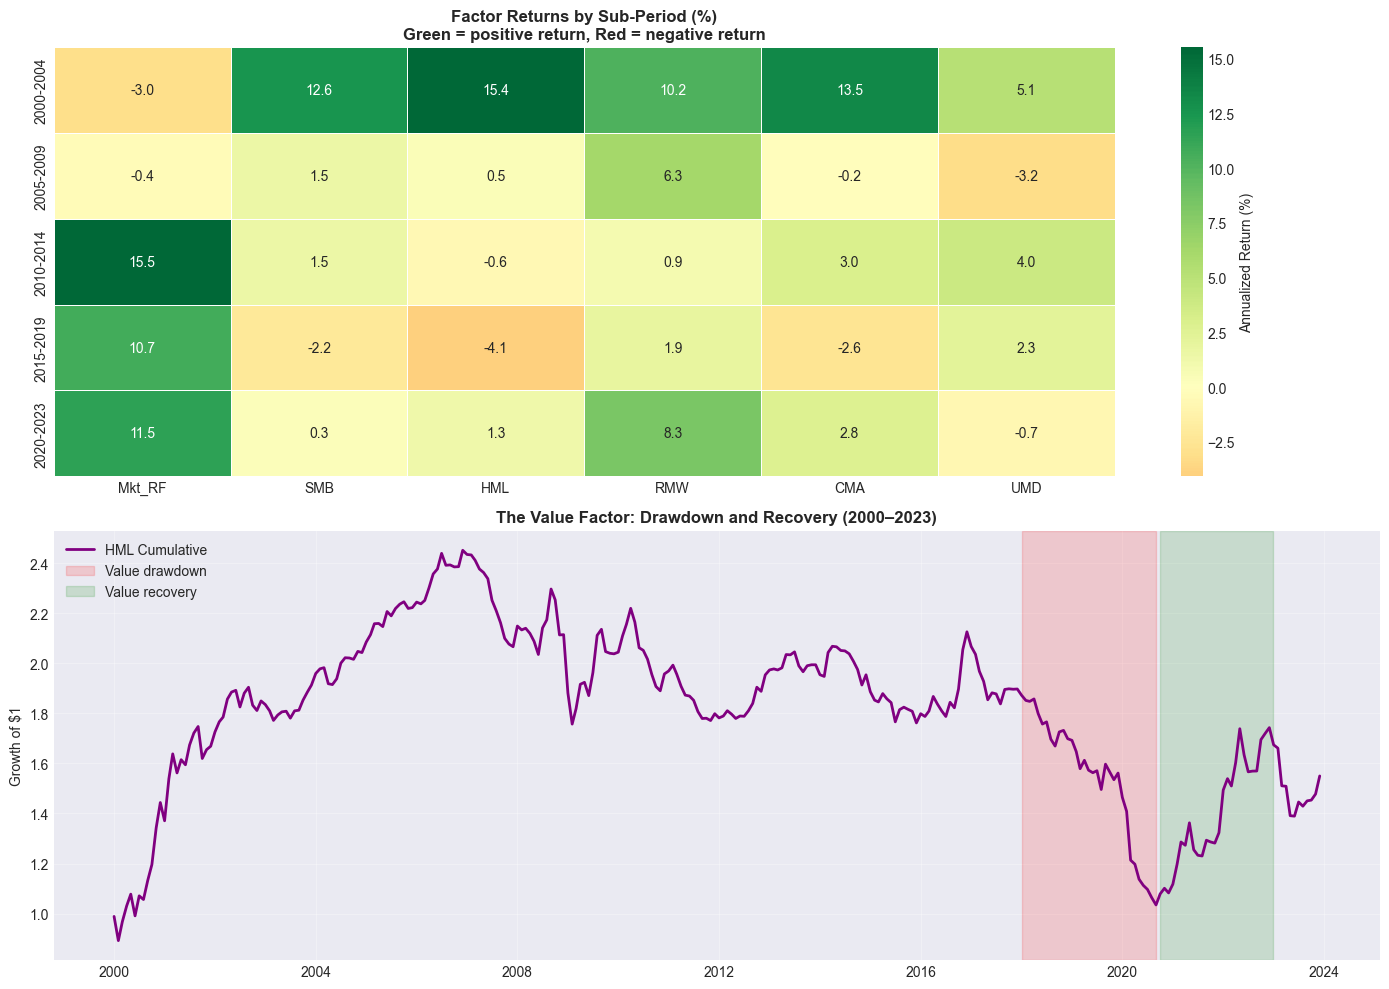


DISCUSSION:
1. Factor premia are NOT constant — they vary substantially across periods
2. The value factor (HML) had negative returns in 2015-2019 and recovered 
   strongly in 2020-2023. This is the "value drawdown" that shook many 
   investors' confidence.
3. Momentum (UMD) experienced its crash during the GFC recovery (2009) 
   but has otherwise been strong.
4. Profitability (RMW) has been relatively consistent — this is one reason 
   it has gained popularity among factor investors.
5. These sub-period variations are exactly why Wei Dai emphasizes the need 
   for LONG HORIZONS when evaluating factor strategies.



In [15]:
# ============================================================================
# Research Deep Dive: Factor Performance Across Decades
# ============================================================================

print("="*70)
print("FACTOR PERFORMANCE BY DECADE")
print("="*70)

factor_cols_all = ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'UMD']

# Define sub-periods
periods = {
    '2000-2004': ('2000-01-01', '2004-12-31'),
    '2005-2009': ('2005-01-01', '2009-12-31'),
    '2010-2014': ('2010-01-01', '2014-12-31'),
    '2015-2019': ('2015-01-01', '2019-12-31'),
    '2020-2023': ('2020-01-01', '2023-12-31'),
}

decade_returns = {}
for period_name, (start, end) in periods.items():
    sub = factors.loc[start:end, factor_cols_all]
    ann_ret = sub.mean() * 12 * 100  # Annualized, in %
    decade_returns[period_name] = ann_ret

decade_df = pd.DataFrame(decade_returns).T
print("\nAnnualized Returns by Sub-Period (%):")
print(decade_df.round(2))

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Heatmap of factor returns by period
ax = axes[0]
sns.heatmap(decade_df, annot=True, fmt='.1f', cmap='RdYlGn', center=0,
            ax=ax, linewidths=0.5, cbar_kws={'label': 'Annualized Return (%)'})
ax.set_title('Factor Returns by Sub-Period (%)\n'
             'Green = positive return, Red = negative return', fontweight='bold', fontsize=12)
ax.set_ylabel('')

# Plot 2: Value spread proxy — rolling HML cumulative return
ax = axes[1]
# Show the value factor's "death and resurrection"
hml_cum = (1 + factors['HML']).cumprod()
ax.plot(factors.index, hml_cum, color='purple', linewidth=2, label='HML Cumulative')
ax.set_title('The Value Factor: Drawdown and Recovery (2000–2023)', fontweight='bold', fontsize=12)
ax.set_ylabel('Growth of $1')
ax.grid(True, alpha=0.3)

# Annotate key periods
ax.axvspan('2018-01-01', '2020-09-01', alpha=0.15, color='red', label='Value drawdown')
ax.axvspan('2020-10-01', '2022-12-31', alpha=0.15, color='green', label='Value recovery')
ax.legend()

plt.tight_layout()
plt.savefig('factor_decades.png', dpi=100, bbox_inches='tight')
plt.show()

print("""
DISCUSSION:
1. Factor premia are NOT constant — they vary substantially across periods
2. The value factor (HML) had negative returns in 2015-2019 and recovered 
   strongly in 2020-2023. This is the "value drawdown" that shook many 
   investors' confidence.
3. Momentum (UMD) experienced its crash during the GFC recovery (2009) 
   but has otherwise been strong.
4. Profitability (RMW) has been relatively consistent — this is one reason 
   it has gained popularity among factor investors.
5. These sub-period variations are exactly why Wei Dai emphasizes the need 
   for LONG HORIZONS when evaluating factor strategies.
""")

COMPREHENSIVE MODEL: FF5 + MOMENTUM

Adding UMD to the 5-factor model gives us the most complete
specification. Let's see how each ETF maps onto all six factors.


SPY (S&P 500)
------------------------------------------------------------
  Alpha      =   0.00009  (t=  0.12, p=0.9081) 
  Mkt_RF     =   0.99549  (t= 30.91, p=0.0000) ***
  SMB        =  -0.09502  (t= -1.64, p=0.1019) 
  HML        =   0.16035  (t=  1.93, p=0.0546) *
  RMW        =   0.04462  (t=  0.57, p=0.5691) 
  CMA        =  -0.20113  (t= -1.54, p=0.1238) 
  UMD        =  -0.02629  (t= -0.95, p=0.3430) 
  R² = 0.8627   Adj R² = 0.8591

IWN (Small Cap Value)
------------------------------------------------------------
  Alpha      =  -0.00032  (t= -0.26, p=0.7913) 
  Mkt_RF     =   0.98504  (t= 23.60, p=0.0000) ***
  SMB        =   0.79369  (t= 10.91, p=0.0000) ***
  HML        =   0.54819  (t=  6.97, p=0.0000) ***
  RMW        =  -0.04200  (t= -0.44, p=0.6575) 
  CMA        =  -0.31754  (t= -2.31, p=0.0218) **
  UMD 

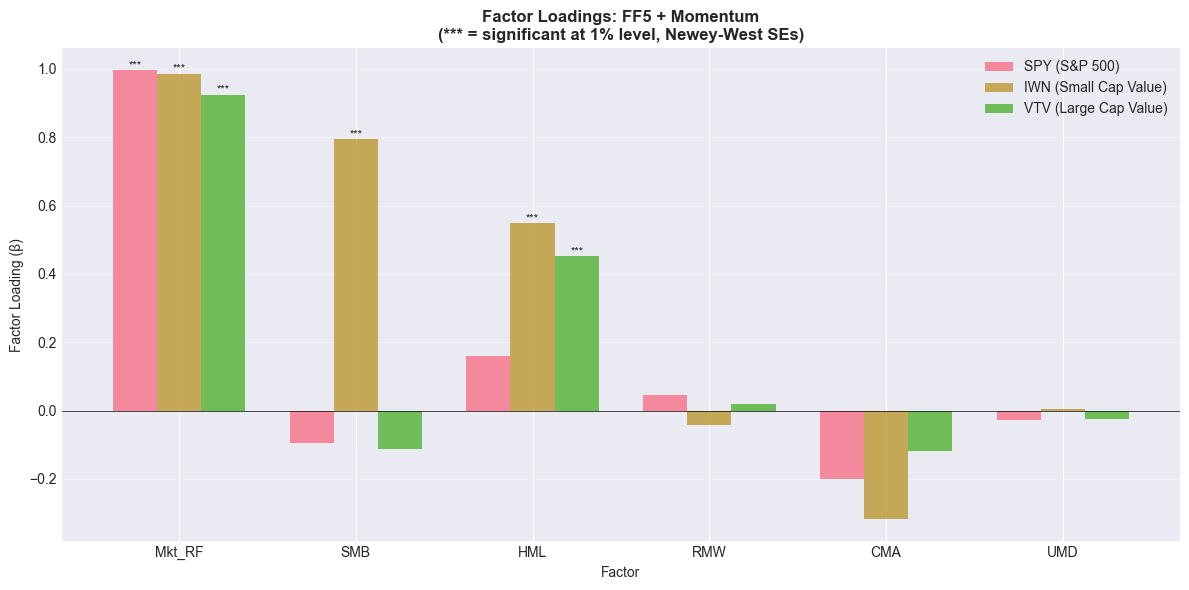


INTERPRETATION GUIDE:
- Bar height = factor sensitivity (positive = tilts toward that factor)
- *** = statistically significant at 1% level
- SPY should be dominated by Mkt_RF ≈ 1, everything else near zero
- IWN should show positive SMB, positive HML, and possibly negative UMD
- VTV should show positive HML, possibly positive RMW



In [16]:
# ============================================================================
# The "Kitchen Sink" Model: 5 Factors + Momentum on Our ETFs
# ============================================================================

print("="*70)
print("COMPREHENSIVE MODEL: FF5 + MOMENTUM")
print("="*70)
print("\nAdding UMD to the 5-factor model gives us the most complete")
print("specification. Let's see how each ETF maps onto all six factors.\n")

full_cols = ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'UMD']
full_names = ['Alpha', 'Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'UMD']

all_params = {}
all_pvals = {}
all_r2 = {}

for ticker, label in etf_tickers.items():
    edf = etf_dataframes[ticker]
    res = run_ff_regression(None, full_cols, edf, stock_name=label)
    all_params[ticker] = res.params
    all_pvals[ticker] = res.pvalues
    all_r2[ticker] = res.rsquared

    print(f"\n{label}")
    print("-" * 60)
    for i, name in enumerate(full_names):
        sig = '***' if res.pvalues[i] < 0.01 else ('**' if res.pvalues[i] < 0.05 else ('*' if res.pvalues[i] < 0.10 else ''))
        print(f"  {name:10s} = {res.params[i]:9.5f}  (t={res.tvalues[i]:6.2f}, p={res.pvalues[i]:.4f}) {sig}")
    print(f"  R² = {res.rsquared:.4f}   Adj R² = {res.rsquared_adj:.4f}")

# Visualization: Factor loadings comparison
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(full_names) - 1)  # Exclude alpha for visualization
width = 0.25

for i, (ticker, label) in enumerate(etf_tickers.items()):
    params_no_alpha = all_params[ticker][1:]  # Skip alpha
    bars = ax.bar(x + i * width, params_no_alpha, width, label=label, alpha=0.8)
    # Add significance markers
    for j, bar in enumerate(bars):
        p = all_pvals[ticker][j + 1]
        if p < 0.01:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                    '***', ha='center', va='bottom', fontsize=8)

ax.set_xlabel('Factor')
ax.set_ylabel('Factor Loading (β)')
ax.set_title('Factor Loadings: FF5 + Momentum\n(*** = significant at 1% level, Newey-West SEs)',
             fontweight='bold', fontsize=12)
ax.set_xticks(x + width)
ax.set_xticklabels(full_names[1:])
ax.axhline(0, color='black', linewidth=0.5)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('full_model_loadings.png', dpi=100, bbox_inches='tight')
plt.show()

print("""
INTERPRETATION GUIDE:
- Bar height = factor sensitivity (positive = tilts toward that factor)
- *** = statistically significant at 1% level
- SPY should be dominated by Mkt_RF ≈ 1, everything else near zero
- IWN should show positive SMB, positive HML, and possibly negative UMD
- VTV should show positive HML, possibly positive RMW
""")

---

## Section 7: The Case Against Factor Investing — Andrew Chen's Challenge

> *"Is everything I was taught about cross-sectional asset pricing wrong?!"*
> — Title of Rational Reminder Episode 316 (August 2024)

The preceding sections present a broadly positive case for factor investing: real premia exist (Sections 1–5), academic research documents them rigorously (Section 6), and sophisticated firms like DFA and Avantis capture them in practice (see [Practical Factor Investing](05_Practical_Factor_Investing.ipynb)). But a body of research led by **Andrew Chen** — a principal economist at the Federal Reserve Board — raises a far more uncomfortable question: **after accounting for transaction costs and out-of-sample decay, is there anything left?**

This section synthesizes Chen's research program, the specific papers discussed on the [Rational Reminder podcast (Episode 316)](https://rationalreminder.ca/podcast/316), and the subsequent critiques and counter-arguments. The implications are directly relevant to the "Bogleheads vs. factor investing" debate that dominates retail investor forums.

### 7.1 Chen's Research Program: The Key Papers

Andrew Chen's work sits at the intersection of meta-science and asset pricing. Rather than studying individual factors, he studies the *entire literature* — asking whether the collective output of decades of academic research is reliable, useful, and investable.

**Paper 1: "Open Source Cross-Sectional Asset Pricing" (Chen & Zimmermann, 2022)**
*Published in Critical Finance Review | [SSRN 3604626](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3604626)*

The foundation of Chen's research program. He and Tom Zimmermann replicated **over 200 published cross-sectional return predictors** using standardized methodology, posting all code and data publicly at [openassetpricing.com](https://www.openassetpricing.com/). Key findings:

- Of ~300 variables examined in prior meta-studies, only ~200 were actually shown to predict returns in the original papers
- Of those 200, Chen & Zimmermann **successfully replicated all but three** (~1–2% failure rate)
- This **contradicts** the "replication crisis" narrative from Hou, Xue & Zhang (2020), who reported widespread failure. Chen argues their paper conflated *confirmed null results* with *failed replications* — counting cases where the original paper itself found no significant effect as "replication failures"
- Out-of-sample returns decline by roughly **50%** (replicating McLean & Pontiff, 2016), but the decline is gradual — consistent with real but transient mispricing, not statistical fabrication

**Paper 2: "Zeroing in on the Expected Returns of Anomalies" (Chen & Velikov, 2023)**
*Published in the Journal of Finance | [SSRN 3073681](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3073681)*

This is the paper that factor investing skeptics cite most. Chen and Mihail Velikov combine two effects — out-of-sample decay and transaction costs — to estimate what individual anomalies actually earn in the modern era:

- Transaction costs (measured as effective bid-ask spreads) consume roughly **25–30%** of anomaly returns in the original sample periods
- Combined with the ~50% out-of-sample decay, the residual is close to zero
- After accounting for the post-2005 efficiency gains (see below), **even the best individual anomalies earn effectively nothing** net of basic transaction costs
- The distribution of post-cost, post-2005 anomaly returns is statistically indistinguishable from a simulation where no true predictability exists

As Chen stated on Rational Reminder:

> *"Out-of-sample, the returns are basically completely gone after trading cost... even the best of these anomalies or predictors earns nothing in this very baseline transaction cost case."*

Transaction cost estimation caveats (which Chen himself notes):
- Costs assume aggressive market orders for a small trader — no price impact modelling
- Short-sale costs are ignored (which would make things *worse*)
- Sophisticated cost-mitigation techniques are not fully modeled (which could help)
- Chen uses the effective bid-ask spread, which is contested — some researchers argue it overstates or understates real implementation costs
- A separate paper finds that **short-sale costs alone** can eliminate anomaly profits

**Paper 3: "Does Peer-Reviewed Research Help Predict Stock Returns?" (Chen, Lopez-Lira & Zimmermann, 2024)**
*Working paper | [SSRN 4308069](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4308069)*

Perhaps Chen's most philosophically devastating finding. He categorizes published anomalies by their theoretical underpinning — mispricing story, risk-based story, hand-waving, toy model, or full quantitative equilibrium model — and tests whether sophisticated theory helps:

- **Factors backed by strong theoretical models perform no better out of sample than naively data-mined accounting ratios**
- If anything, the more rigorous the theoretical justification, the *worse* the out-of-sample performance
- Purely mechanical data mining (searching through 29,000 accounting ratios for predictive power) could have uncovered all major anomalies **decades before they were published** — including the investment anomaly (published ~2004, discoverable in 1980)
- The entire peer review process in cross-sectional asset pricing — the sweat, toil, and intellectual apparatus of decades of PhD research — appears to add no predictive value beyond what brute-force data mining delivers

> *"If you could data mine [accounting ratios] in 1980, you could have uncovered all of these anomalies long before they were published, even decades before."*

**Paper 4 (referenced): McLean & Pontiff, "Does Academic Research Destroy Stock Return Predictability?" (2016)**
*Published in the Journal of Finance | [SSRN 2156623](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2156623)*

The foundational study that Chen replicates and extends. McLean and Pontiff find:
- Post-publication, anomaly returns decline by ~35% on average
- The decline is gradual, suggesting real predictability that gets arbitraged away — not pure statistical artifacts
- Chen's contribution: combining this with transaction costs pushes the net return to approximately zero

**Paper 5 (criticized by Chen): Harvey, Liu & Zhu, "…and the Cross-Section of Expected Returns" (2016)**
*Published in the Review of Financial Studies | [SSRN 2249314](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2249314)*

This viral paper proclaimed that "most claimed research findings in financial economics are likely false." Chen dismantles this claim:
- Harvey et al. conflate *insignificant* with *false* — a statistical error (a negative COVID test doesn't mean you don't have COVID)
- They conflate *many* with *most* — a rhetorical overreach
- Chen estimates the true false discovery rate at **less than 10%**, far lower than Harvey et al.'s alarming claims
- However, Chen acknowledges Harvey et al. captured a genuine *feeling* that something was wrong with the literature — their diagnosis was just imprecise

### 7.2 The Post-2005 Structural Break

A key empirical regularity across multiple studies: factor performance exhibits a "kink" around the mid-2000s. Returns are substantially weaker from 2005 onward.

**Two competing hypotheses:**
1. **Technology/efficiency**: The internet and IT revolution made information dramatically cheaper and faster to process, improving market efficiency. In the 1963–1989 era (the data behind Fama-French 1993), trading on book-to-market required receiving accounting statements in the mail and making phone calls. Now it takes microseconds.
2. **Publication effect**: Most major anomaly papers were published around 2000–2005, and subsequent arbitrage traded the premia away.

Chen's preferred explanation is the technology story, though he acknowledges both forces likely reinforce each other. Either way, the implication is the same: **historical factor premia reflect a less efficient informational environment that no longer exists**. Using 1963–2005 average returns to estimate future expected premia likely overstates them dramatically.

### 7.3 The Adaptive Markets Framing

Chen explicitly frames his findings through Andrew Lo's **Adaptive Markets Hypothesis** — perhaps the most important theoretical lens for understanding his results:

- Markets are not perpetually efficient (as classical EMH suggests) but **become more efficient over time** as participants learn and compete
- Mispricings are real when they first appear, but they get corrected — through academic publication, technology, market evolution, or all three
- Factor premia are therefore **transient mispricing**, not permanent risk compensation
- The traditional efficient markets view assumed markets are efficient *all the time*, which paradoxically led researchers to explain away mispricings with risk theories (creating "factors"). Chen suggests these risk-based stories were motivated reasoning

> *"These are all mispricings that are transient. If you're a practitioner, you've got to get to something new."*

This is a profound shift: if factor premia are adaptive rather than structural, the entire "patient factor investing" playbook — wait 10–20 years and the premium will materialize — may be overly optimistic.

### 7.4 Critiques and Counter-Arguments

Chen's research is rigorous, but it is not the final word. Several important counter-arguments and follow-up papers push back on the strongest version of his conclusions.

---

**Critique 1: Individual Anomalies ≠ Multi-Factor Portfolios**

**The argument:** Chen's analysis focuses on individual anomalies traded in isolation. But nobody actually invests this way. Real-world implementations (DFA, Avantis) integrate multiple signals simultaneously, which fundamentally changes both the cost structure and the return profile.

**Chen himself acknowledges this.** In the podcast, he notes:

> *"There's an economics of this that transaction costs are actually, in a sense, lower if you use more predictors at the same time. If one predictor is telling you you need to make a trade... the other predictor may tell you that you can offset it."*

He references "recent studies that find that even net of transaction costs, if you can combine predictors, you can still get some returns." This is exactly what DFA and Avantis do: by jointly sorting on value, profitability, and size — and using momentum as an implementation screen — they reduce turnover and allow cross-signal netting of trades.

**Supporting research:** Victor DeMiguel, Alberto Martín-Utrera, Francisco J. Nogales & Raman Uppal, *"A Transaction-Cost Perspective on the Multitude of Firm Characteristics"* (Review of Financial Studies, 2020) — show that optimally combining predictors while accounting for transaction costs yields portfolios that survive real-world costs. The key finding: **diversification across signals reduces trading costs, not just risk.**

---

**Critique 2: The Long-Short vs. Long-Only Distinction**

**The argument:** Academic factor returns are computed as long-short portfolios (buy winners, short losers). The short side is expensive (borrowing costs, recall risk, short-sale constraints) and often concentrated in micro-caps. Real-world factor investors like DFA and Avantis use **long-only tilts** — overweighting stocks with favorable characteristics and underweighting those without. This is dramatically cheaper and avoids the worst implementation problems.

As Gerard O'Reilly (DFA's co-CEO and CIO) discussed on [Rational Reminder Episode 360 (June 2025)](https://rationalreminder.ca/podcast/360), DFA's factor implementation operates at a fundamentally different cost level than academic long-short replication.

---

**Critique 3: Novy-Marx & Velikov's Implementability Research**

Novy-Marx and Velikov (*"Assaying Anomalies,"* 2023) systematically evaluated which factors survive implementability tests using realistic trading cost estimates. Their conclusion is more nuanced than "everything is zero":

- **Robust survivors**: value, profitability, and momentum survive trading costs with smart implementation
- **Casualties**: many exotic anomalies and signals concentrated in micro-caps
- The key insight aligns with Section 6.6: the "factor zoo" is mostly junk, but the **core factors** that DFA and Avantis tilt toward are the ones that survive

This creates an important distinction: Chen is right that most of the factor zoo is worthless after costs, but the specific factors used by sophisticated implementers may be the exception.

---

**Critique 4: Wei Dai and the Implementation Quality Argument**

Wei Dai's research at Dimensional (Section 6.4) demonstrates that implementation quality can reclaim a meaningful portion of the gross factor premium:
- **Integrated multi-factor portfolios** reduce turnover and hence transaction costs (vs. trading each factor separately)
- **Patient trading** (no hard rebalancing dates, price-weighted multipliers) dramatically reduces market impact
- **Reversal screens** (Dai & Novy-Marx, *Financial Analysts Journal*, 2024) add 1–10 basis points by avoiding adverse selection in trading
- **Excluding micro-caps** from the investment universe eliminates the most costly trades while retaining most of the premium

The question becomes: does DFA/Avantis-style implementation overcome the erosion Chen documents? The honest answer is that no published study has definitively settled this, because DFA's proprietary trading data is not publicly available. But the theoretical argument — multi-signal integration, patient trading, long-only tilts — is plausible and supported by suggestive evidence.

---

**Critique 5: Risk vs. Mispricing Is Not Settled**

Chen's framework assumes factor premia are predominantly **mispricing** that gets corrected. But the risk-based explanation has not been conclusively refuted:
- If value stocks genuinely compensate investors for bearing distress risk, that compensation should persist regardless of market efficiency improvements
- The DDM identity (Section 1) guarantees that, holding cash flows constant, cheaper stocks must have higher expected returns — this is an accounting relationship, not a mispricing claim
- Eugene Fama and Kenneth French have consistently argued their factors capture systematic risk exposure, not exploitable mispricing. The out-of-sample decline Chen documents could reflect time-varying risk premia rather than arbitrage

However, Chen's finding that risk-based factors perform no better out of sample than mispricing-based factors weakens this critique. If risk were the driver, risk-based factors should be more persistent.

---

**Critique 6: Eduardo Repetto (Avantis) and the "Expected Return" Approach**

As discussed on [Rational Reminder Episode 315 (July 2024)](https://rationalreminder.ca/podcast/315), Avantis' Eduardo Repetto emphasizes that their implementation focuses on **forward-looking expected returns** rather than backward-looking factor replication:
- Avantis ranks stocks by a composite expected return measure (combining valuation and cash-flow profitability)
- This is more similar to Chen's "data mining" approach than to traditional factor replication — Avantis is effectively asking "which stocks are cheap and profitable right now?" rather than "which factor has the best historical premium?"
- If Chen is right that data mining works as well as theory, this may actually *validate* Avantis' approach

---

**Critique 7: The Timeframe Matters — Recent Value Recovery**

Chen's analysis through ~2022 captures the dismal post-2005 period for many anomalies, including value's worst-ever drawdown (2018–2020). But:
- Value experienced a dramatic recovery in 2021–2022 and has continued to perform strongly through 2025
- Cliff Asness and AQR argued throughout the drawdown that value spreads (the gap between cheap and expensive stocks) had reached historically extreme levels, predicting recovery — which occurred
- Current (2025–2026) value spreads remain wide by historical standards, suggesting above-average expected value premia going forward
- This is consistent with a risk/mispricing view where the premium is time-varying but real, rather than permanently gone

### 7.5 The Bogleheads vs. Factor Investing Debate

Chen's research has become a focal point in the longstanding debate between total-market index investors ("Bogleheads") and factor-tilted investors. Here is how each side deploys his findings:

**The Boglehead Argument (strengthened by Chen):**

| Claim | Supporting Evidence from Chen |
|-------|-------------------------------|
| Just buy the total market and minimize costs | Individual anomaly profits are zero after costs post-2005 |
| Factor tilts add complexity without reliable reward | Theoretical justifications don't help predict out-of-sample returns |
| Factor investors bear tracking error for uncertain premia | 50% out-of-sample decay + transaction costs = effectively nothing |
| Past performance doesn't predict future premium | The post-2005 kink suggests historical averages overstate future expectations |
| Factor investing is "active management in disguise" | If the edge is transient, you need to constantly adapt — that's active management |

**The Factor Investing Argument (qualified but surviving):**

| Claim | Supporting Evidence |
|-------|------|
| Multi-factor integration ≠ individual anomaly trading | Chen himself acknowledges combining predictors helps. DeMiguel et al. (2020) confirm |
| DFA/Avantis implementation is fundamentally different from academic long-short | Long-only, patient-traded, multi-factor portfolios have much lower costs |
| The core factors (value, profitability, momentum) survive costs | Novy-Marx & Velikov (2023) specifically identify these as "robust survivors" |
| The DDM identity guarantees cheap + profitable = higher expected returns | This is accounting, not a claim about market efficiency |
| Value spreads are forward-looking and currently wide | Dai (2023): wide spreads predict higher future premia |
| Even small premia compound over decades | 50–100 bps/year × 30 years is substantial for retirement outcomes |

**The Honest Middle Ground:**

The intellectually honest position — and one consistent with the full body of evidence — is probably this:

1. **Chen is right** that most published anomalies are worthless after costs in the modern era, and that economic theory adds less value than the profession claims
2. **He is probably too pessimistic** about well-implemented multi-factor strategies from firms like DFA and Avantis, which operate very differently from academic long-short replication
3. **The expected premium from factor tilts is likely smaller** than historical averages suggest (perhaps 1–2% annualized rather than 3–5%)
4. **The premium is uncertain enough** that investors who cannot tolerate 10–15 years of potential underperformance should probably stick with total-market indexing
5. **The method matters more than the story** — how you implement (integrated, patient, low-cost) matters more than which theoretical narrative you find compelling
6. **Constant adaptation may be necessary** — the "buy and hold factor tilts forever" approach may need updating as markets evolve. This is uncomfortable for passive-minded investors.

### 7.6 What Chen Gets Right That Everyone Should Internalize

Regardless of where you land on the factor investing debate, several of Chen's findings are near-universally accepted:

1. **There is no replication crisis in cross-sectional asset pricing** — the published numbers are reliable (1–2% failure rate)
2. **False discovery rates are low** (<10%) — the anomalies are real signals, not statistical noise
3. **But "real" doesn't mean "profitable"** — transaction costs and out-of-sample decay can reduce real signals to zero implementable profit
4. **Theory has failed to add value** — risk-based stories for why factors should persist are not predictively useful. This is the most uncomfortable finding for academics.
5. **Markets adapt** — any documented regularity will attract arbitrage capital and diminish over time. This is the Adaptive Markets Hypothesis in action.
6. **Trust the numbers, be skeptical of the text** — published statistical results are reliable; the theoretical narratives wrapped around them may not be

> **Key references from [Rational Reminder Episode 316](https://rationalreminder.ca/podcast/316):**
>
> - Chen, A. & Zimmermann, T., "Open Source Cross-Sectional Asset Pricing" (*Critical Finance Review*, 2022). [SSRN](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3604626)
> - Chen, A. & Velikov, M., "Zeroing in on the Expected Returns of Anomalies" (*Journal of Finance*, 2023). [SSRN](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3073681)
> - Chen, A., Lopez-Lira, A. & Zimmermann, T., "Does Peer-Reviewed Research Help Predict Stock Returns?" (2024). [SSRN](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4308069)
> - McLean, R.D. & Pontiff, J., "Does Academic Research Destroy Stock Return Predictability?" (*Journal of Finance*, 2016). [SSRN](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2156623)
> - Harvey, C.R., Liu, Y. & Zhu, C., "…and the Cross-Section of Expected Returns" (*Review of Financial Studies*, 2016). [SSRN](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2249314)
> - Hou, K., Xue, C. & Zhang, L., "Replicating Anomalies" (*Review of Financial Studies*, 2020). [SSRN](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3275496)
> - Dichev, I.D., "Is the Risk of Bankruptcy a Systematic Risk?" (*Journal of Finance*, 1998). [SSRN](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=99868)
>
> **Counter-arguments and related research:**
> - DeMiguel, V., Martín-Utrera, A., Nogales, F.J. & Uppal, R., "A Transaction-Cost Perspective on the Multitude of Firm Characteristics" (*Review of Financial Studies*, 2020)
> - Novy-Marx, R. & Velikov, M., "Assaying Anomalies" (2023)
> - Lo, A., *The Adaptive Markets Hypothesis* (2017)
> - Asness, C., "The Long Run is Lying to You" (AQR, 2020)
> - O'Reilly, G., [Rational Reminder Episode 360](https://rationalreminder.ca/podcast/360): "The Components of Net Returns" (June 2025)
> - Repetto, E., [Rational Reminder Episode 315](https://rationalreminder.ca/podcast/315): "An Update from Avantis" (July 2024)

THE FACTOR RETURN EROSION WATERFALL
Estimates from Chen & Velikov (2023) and Chen & Zimmermann (2022)


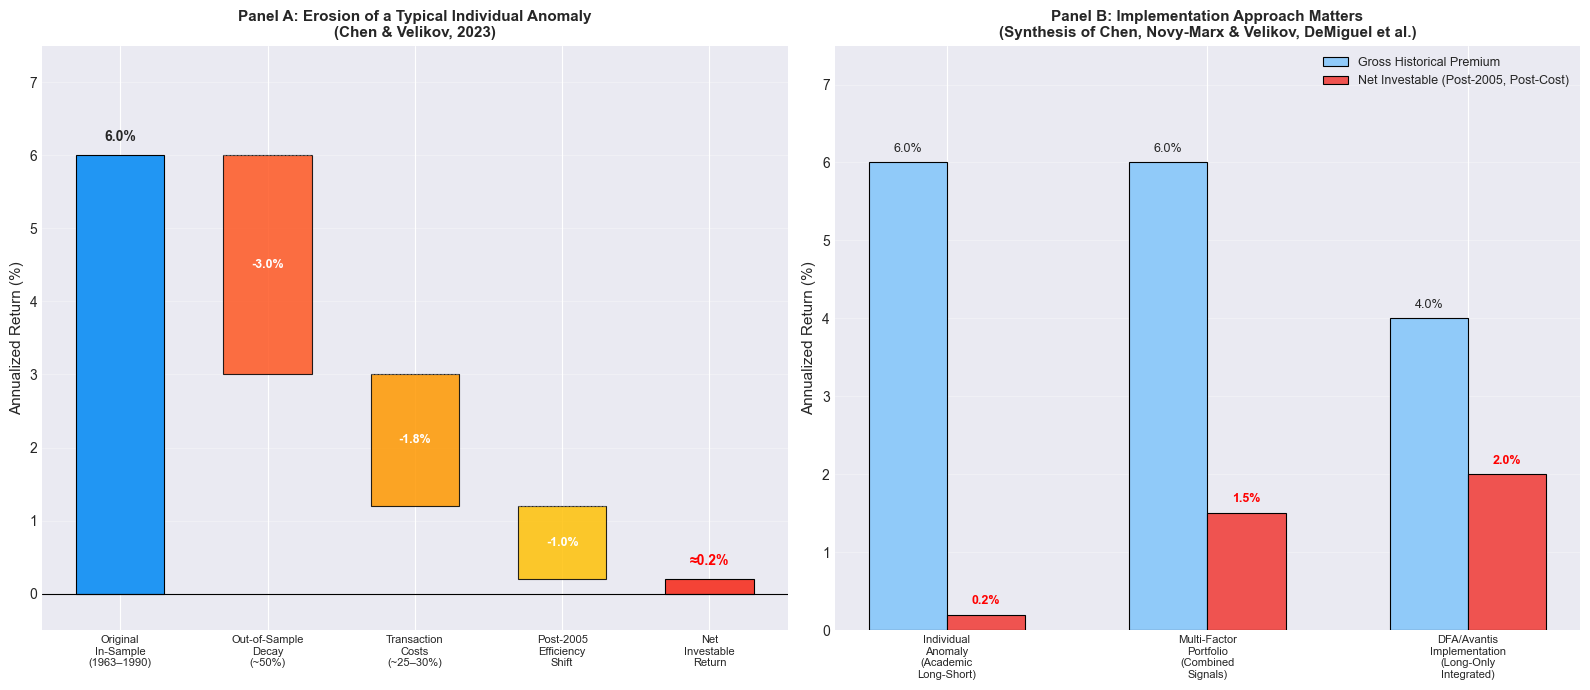


╔══════════════════════════════════════════════════════════════════════╗
║  INTERPRETING THIS FIGURE                                          ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                    ║
║  Panel A: The "erosion waterfall" shows how a typical individual   ║
║  anomaly's ~6% in-sample return shrinks to near zero through:      ║
║    1. Out-of-sample decay (~50%, per McLean & Pontiff / Chen)      ║
║    2. Transaction costs (~25-30% of original, per Chen & Velikov)  ║
║    3. Post-2005 market efficiency improvements                     ║
║                                                                    ║
║  Panel B: But IMPLEMENTATION APPROACH matters enormously:          ║
║    - Individual anomalies (Chen's focus): ~0% net                  ║
║    - Multi-factor combinations: ~1-2% may survive (DeMiguel+)     ║ 
║    - DFA/Avantis long-only integrated: ~1-3% (estimated)          ║
║ 

/var/folders/db/hq8_rnz14b57v5kzk6z5h57r0000gn/T/ipykernel_15160/2796495682.py:210: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/db/hq8_rnz14b57v5kzk6z5h57r0000gn/T/ipykernel_15160/2796495682.py:210: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/db/hq8_rnz14b57v5kzk6z5h57r0000gn/T/ipykernel_15160/2796495682.py:211: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.savefig('bogleheads_vs_factors.png', dpi=100, bbox_inches='tight')
/var/folders/db/hq8_rnz14b57v5kzk6z5h57r0000gn/T/ipykernel_15160/2796495682.py:211: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.savefig('bogleheads_vs_factors.png', dpi=100, bbox_inches='tight')
/Users/theoraedschelders/Projects/FamaFrench/venv/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  f

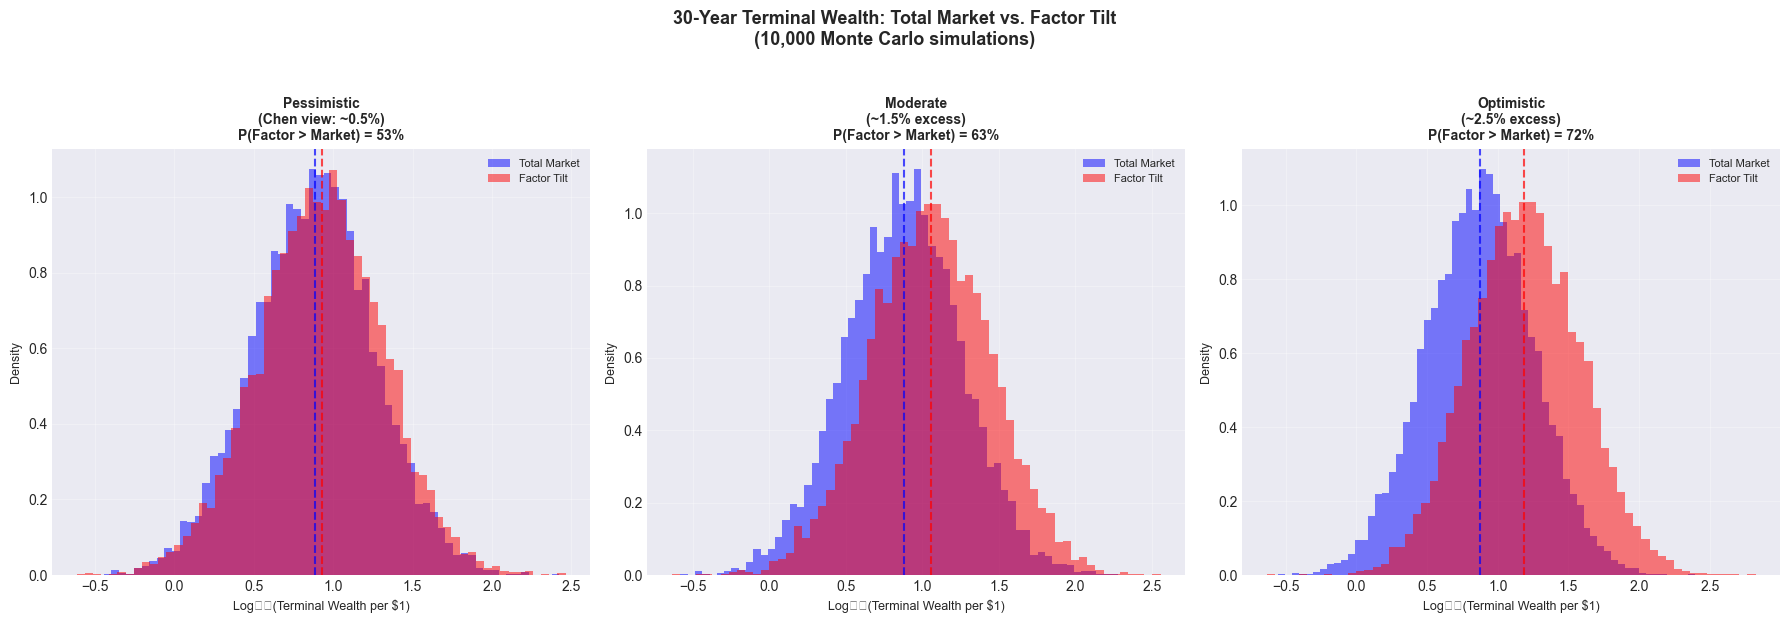


WHAT THIS SHOWS:
- Under Chen's pessimistic view (~0.5% excess after costs/decay), the factor 
  tilt barely improves outcomes and the added tracking error may not be worth it.

- Under a moderate view (~1.5% excess), the factor tilt shifts the distribution
  meaningfully rightward — but there's still a substantial chance of underperformance
  over 30 years due to tracking error.

- Under the optimistic view (~2.5% excess), factor tilts provide a clear 
  advantage to the median investor.

THE PRACTICAL TAKEAWAY:
If you believe Chen's most pessimistic estimates apply to well-implemented 
multi-factor strategies (which Chen himself does not claim), Bogleheads win.
If you believe implementation matters and 1-2% survives, factor tilts are 
worth the tracking error — but only if you can maintain discipline for decades.

This is ultimately a question about:
  1. Your estimate of the net factor premium (0.5%? 1.5%? 2.5%?)
  2. Your tolerance for tracking error and underperformance
  3. Your

In [17]:
# ============================================================================
# Visualizing the "Erosion Waterfall": How Factor Returns Disappear
# ============================================================================
# Based on estimates from Chen & Velikov (2023) and Chen & Zimmermann (2022)
# illustrating the cumulative effect of out-of-sample decay, transaction costs,
# and the post-2005 efficiency shift on individual anomaly returns.

print("="*70)
print("THE FACTOR RETURN EROSION WATERFALL")
print("Estimates from Chen & Velikov (2023) and Chen & Zimmermann (2022)")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# --- Panel A: Waterfall chart showing erosion of a "typical" anomaly ---
ax = axes[0]

stages = [
    'Original\nIn-Sample\n(1963–1990)',
    'Out-of-Sample\nDecay\n(~50%)',
    'Transaction\nCosts\n(~25–30%)',
    'Post-2005\nEfficiency\nShift',
    'Net\nInvestable\nReturn'
]
# Illustrative values based on Chen's findings:
# Start with ~6% annualized long-short return (typical anomaly)
# 50% OOS decay → 3%
# 25-30% of original from tx costs → ~1.5% left
# Post-2005 efficiency further reduces → ~0-0.5%
values = [6.0, -3.0, -1.8, -1.0, 0.2]
cumulative = [6.0, 3.0, 1.2, 0.2, 0.2]

colors = ['#2196F3', '#FF5722', '#FF9800', '#FFC107', '#4CAF50' if cumulative[-1] > 0.5 else '#F44336']
bar_bottoms = [0, cumulative[0] + values[1], cumulative[1] + values[2], cumulative[2] + values[3], 0]

# Draw waterfall
for i, (stage, val) in enumerate(zip(stages, values)):
    if i == 0:  # Initial bar
        ax.bar(i, val, color=colors[i], edgecolor='black', linewidth=0.8, width=0.6)
        ax.text(i, val + 0.15, f'{val:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)
    elif i == len(stages) - 1:  # Final bar
        ax.bar(i, cumulative[-1], color=colors[i], edgecolor='black', linewidth=0.8, width=0.6)
        ax.text(i, cumulative[-1] + 0.15, f'≈{cumulative[-1]:.1f}%', ha='center', va='bottom',
                fontweight='bold', fontsize=10, color='red')
    else:  # Waterfall segments (losses)
        bottom = cumulative[i]
        ax.bar(i, abs(val), bottom=bottom, color=colors[i], edgecolor='black', linewidth=0.8,
               width=0.6, alpha=0.85)
        ax.text(i, bottom + abs(val)/2, f'{val:+.1f}%', ha='center', va='center',
                fontweight='bold', fontsize=9, color='white')
        # Connector lines
        if i < len(stages) - 1:
            ax.plot([i - 0.3, i + 0.3], [cumulative[i-1], cumulative[i-1]],
                    color='gray', linewidth=0.5, linestyle='--')

ax.set_xticks(range(len(stages)))
ax.set_xticklabels(stages, fontsize=8)
ax.set_ylabel('Annualized Return (%)', fontsize=11)
ax.set_title('Panel A: Erosion of a Typical Individual Anomaly\n(Chen & Velikov, 2023)',
             fontweight='bold', fontsize=11)
ax.axhline(0, color='black', linewidth=0.8)
ax.set_ylim(-0.5, 7.5)
ax.grid(axis='y', alpha=0.3)

# --- Panel B: Comparison — individual anomaly vs. multi-factor portfolio ---
ax = axes[1]

categories = ['Individual\nAnomaly\n(Academic\nLong-Short)', 'Multi-Factor\nPortfolio\n(Combined\nSignals)',
              'DFA/Avantis\nImplementation\n(Long-Only\nIntegrated)']

# Illustrative ranges based on research synthesis:
# Individual anomaly: ~0% post-cost post-2005 (Chen & Velikov)
# Multi-factor combination: ~1-2% (DeMiguel et al., 2020; Chen acknowledges)
# DFA/Avantis long-only: ~1-3% (estimated, not directly from Chen)
gross = [6.0, 6.0, 4.0]  # Gross academic premium (long-only has lower gross)
net = [0.2, 1.5, 2.0]    # Net of costs + decay (illustrative)

x = np.arange(len(categories))
width = 0.3

bars1 = ax.bar(x - width/2, gross, width, label='Gross Historical Premium',
               color='#90CAF9', edgecolor='black', linewidth=0.8)
bars2 = ax.bar(x + width/2, net, width, label='Net Investable (Post-2005, Post-Cost)',
               color='#EF5350', edgecolor='black', linewidth=0.8)

# Add value labels
for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
            f'{bar.get_height():.1f}%', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
            f'{bar.get_height():.1f}%', ha='center', va='bottom', fontsize=9,
            fontweight='bold', color='red')

ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=8)
ax.set_ylabel('Annualized Return (%)', fontsize=11)
ax.set_title('Panel B: Implementation Approach Matters\n(Synthesis of Chen, Novy-Marx & Velikov, DeMiguel et al.)',
             fontweight='bold', fontsize=11)
ax.legend(fontsize=9, loc='upper right')
ax.set_ylim(0, 7.5)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('chen_factor_erosion.png', dpi=100, bbox_inches='tight')
plt.show()

print("""
╔══════════════════════════════════════════════════════════════════════╗
║  INTERPRETING THIS FIGURE                                          ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                    ║
║  Panel A: The "erosion waterfall" shows how a typical individual   ║
║  anomaly's ~6% in-sample return shrinks to near zero through:      ║
║    1. Out-of-sample decay (~50%, per McLean & Pontiff / Chen)      ║
║    2. Transaction costs (~25-30% of original, per Chen & Velikov)  ║
║    3. Post-2005 market efficiency improvements                     ║
║                                                                    ║
║  Panel B: But IMPLEMENTATION APPROACH matters enormously:          ║
║    - Individual anomalies (Chen's focus): ~0% net                  ║
║    - Multi-factor combinations: ~1-2% may survive (DeMiguel+)     ║ 
║    - DFA/Avantis long-only integrated: ~1-3% (estimated)          ║
║                                                                    ║
║  IMPORTANT CAVEATS:                                                ║
║  • These are ILLUSTRATIVE estimates, not precise measurements      ║
║  • The DFA/Avantis estimates are inferred, not from Chen's data    ║
║  • Transaction cost measurement is highly contested                ║
║  • Net returns will vary by time period, region, and manager       ║
║  • Even 1-2% annualized compounds significantly over 30 years     ║
║    ($100K → ~182K at 2% vs ~100K at 0% excess over market)        ║
║                                                                    ║
║  THE KEY INSIGHT: Chen is right about the factor ZOO — most       ║
║  published anomalies are worthless after costs. But the specific   ║
║  factors used by sophisticated implementers may be the exception.  ║
║  The debate is about how large that exception is.                  ║
╚══════════════════════════════════════════════════════════════════════╝
""")

# --- Supplementary: Simulate the "Bogleheads vs Factor Tilt" Decision ---
print("\n" + "="*70)
print("SIMULATION: BOGLEHEADS vs FACTOR TILT OVER 30 YEARS")
print("="*70)

np.random.seed(42)
n_simulations = 10000
years = 30

# Market parameters (annualized)
market_return = 0.08        # 8% expected market return
market_vol = 0.16           # 16% volatility

# Factor tilt parameters (excess over market, AFTER costs and decay)
# Scenario 1: Chen's pessimistic view (~0.5% excess, high uncertainty)
factor_excess_pessimistic = 0.005
factor_tracking_error_pessimistic = 0.04

# Scenario 2: Moderate view (~1.5% excess = between Chen and historical)
factor_excess_moderate = 0.015
factor_tracking_error_moderate = 0.04

# Scenario 3: Optimistic view (~2.5% excess = closer to historical)
factor_excess_optimistic = 0.025
factor_tracking_error_optimistic = 0.04

scenarios = {
    'Pessimistic\n(Chen view: ~0.5%)':   (factor_excess_pessimistic, factor_tracking_error_pessimistic),
    'Moderate\n(~1.5% excess)':          (factor_excess_moderate, factor_tracking_error_moderate),
    'Optimistic\n(~2.5% excess)':        (factor_excess_optimistic, factor_tracking_error_optimistic),
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (scenario_name, (excess, te)) in enumerate(scenarios.items()):
    ax = axes[idx]
    
    # Simulate market-only (Boglehead) terminal wealth
    market_terminal = np.exp(
        np.random.normal(market_return - 0.5*market_vol**2, market_vol, (n_simulations, years)).sum(axis=1)
    )
    
    # Simulate factor-tilted terminal wealth
    factor_return = market_return + excess
    factor_vol = np.sqrt(market_vol**2 + te**2)  # Simplified: independent tracking error
    factor_terminal = np.exp(
        np.random.normal(factor_return - 0.5*factor_vol**2, factor_vol, (n_simulations, years)).sum(axis=1)
    )
    
    # Compute outperformance probability
    prob_outperform = (factor_terminal > market_terminal).mean() * 100
    
    # Plot distributions
    ax.hist(np.log10(market_terminal), bins=60, alpha=0.5, color='blue',
            label=f'Total Market', density=True)
    ax.hist(np.log10(factor_terminal), bins=60, alpha=0.5, color='red',
            label=f'Factor Tilt', density=True)
    
    ax.set_title(f'{scenario_name}\nP(Factor > Market) = {prob_outperform:.0f}%',
                 fontweight='bold', fontsize=10)
    ax.set_xlabel('Log₁₀(Terminal Wealth per $1)', fontsize=9)
    ax.set_ylabel('Density', fontsize=9)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # Add median lines
    ax.axvline(np.log10(np.median(market_terminal)), color='blue', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.axvline(np.log10(np.median(factor_terminal)), color='red', linestyle='--', linewidth=1.5, alpha=0.7)

plt.suptitle('30-Year Terminal Wealth: Total Market vs. Factor Tilt\n(10,000 Monte Carlo simulations)',
             fontsize=13, fontweight='bold', y=1.03)
plt.tight_layout()
plt.savefig('bogleheads_vs_factors.png', dpi=100, bbox_inches='tight')
plt.show()

print(f"""
WHAT THIS SHOWS:
- Under Chen's pessimistic view (~0.5% excess after costs/decay), the factor 
  tilt barely improves outcomes and the added tracking error may not be worth it.
  
- Under a moderate view (~1.5% excess), the factor tilt shifts the distribution
  meaningfully rightward — but there's still a substantial chance of underperformance
  over 30 years due to tracking error.
  
- Under the optimistic view (~2.5% excess), factor tilts provide a clear 
  advantage to the median investor.

THE PRACTICAL TAKEAWAY:
If you believe Chen's most pessimistic estimates apply to well-implemented 
multi-factor strategies (which Chen himself does not claim), Bogleheads win.
If you believe implementation matters and 1-2% survives, factor tilts are 
worth the tracking error — but only if you can maintain discipline for decades.

This is ultimately a question about:
  1. Your estimate of the net factor premium (0.5%? 1.5%? 2.5%?)
  2. Your tolerance for tracking error and underperformance
  3. Your confidence in your chosen implementation (DFA, Avantis, etc.)
  4. Your time horizon (shorter = riskier for factor tilts)
""")

---

## Section 8: Rolling-Window Analysis — Time-Varying Factor Exposures

### Why Rolling Windows?

The regressions so far estimate **constant** factor loadings over the full sample. But in the [Time Series Foundations notebook](02_Time_Series_Foundations.ipynb) we saw that financial data can exhibit regime changes and structural breaks — the statistical properties of returns are not necessarily stable over 20+ years. Factor exposures can change over time due to:
- Changes in the index methodology or fund holdings
- Market regime shifts (e.g., value rotation vs. growth dominance)
- Varying sector composition within size/value groups
- Volatility clustering (Section 4 of the [Time Series notebook](02_Time_Series_Foundations.ipynb)) — high-volatility regimes may alter factor sensitivities

Rolling-window regressions fit the model over a moving window (e.g., 36 months) and let us see how betas evolve. This is a powerful diagnostic tool and is used extensively by practitioners. It connects directly to the stationarity question from [Section 2 of the Time Series notebook](02_Time_Series_Foundations.ipynb): if factor loadings are non-stationary, a full-sample regression gives us an *average* loading that may not reflect the current regime.

> **Why plain OLS inside each window?** In the 3-Factor tutorial we used Newey-West standard errors to account for autocorrelation over the full sample. Inside each 36-month rolling window, the primary goal is estimating the *point estimates* (betas), not conducting hypothesis tests. OLS point estimates are unbiased regardless of the error structure ([Section 5 of the Statistical Foundations notebook](01_Statistical_Foundations.ipynb)), so Newey-West would change only the standard errors, not the estimated betas. Moreover, with only 36 observations the Newey-West long-run variance estimate becomes unreliable (few lags, few observations per lag). For these reasons, practitioners typically use plain OLS inside rolling windows and reserve HAC corrections for the full-sample inference.

ROLLING 36-MONTH FACTOR REGRESSIONS


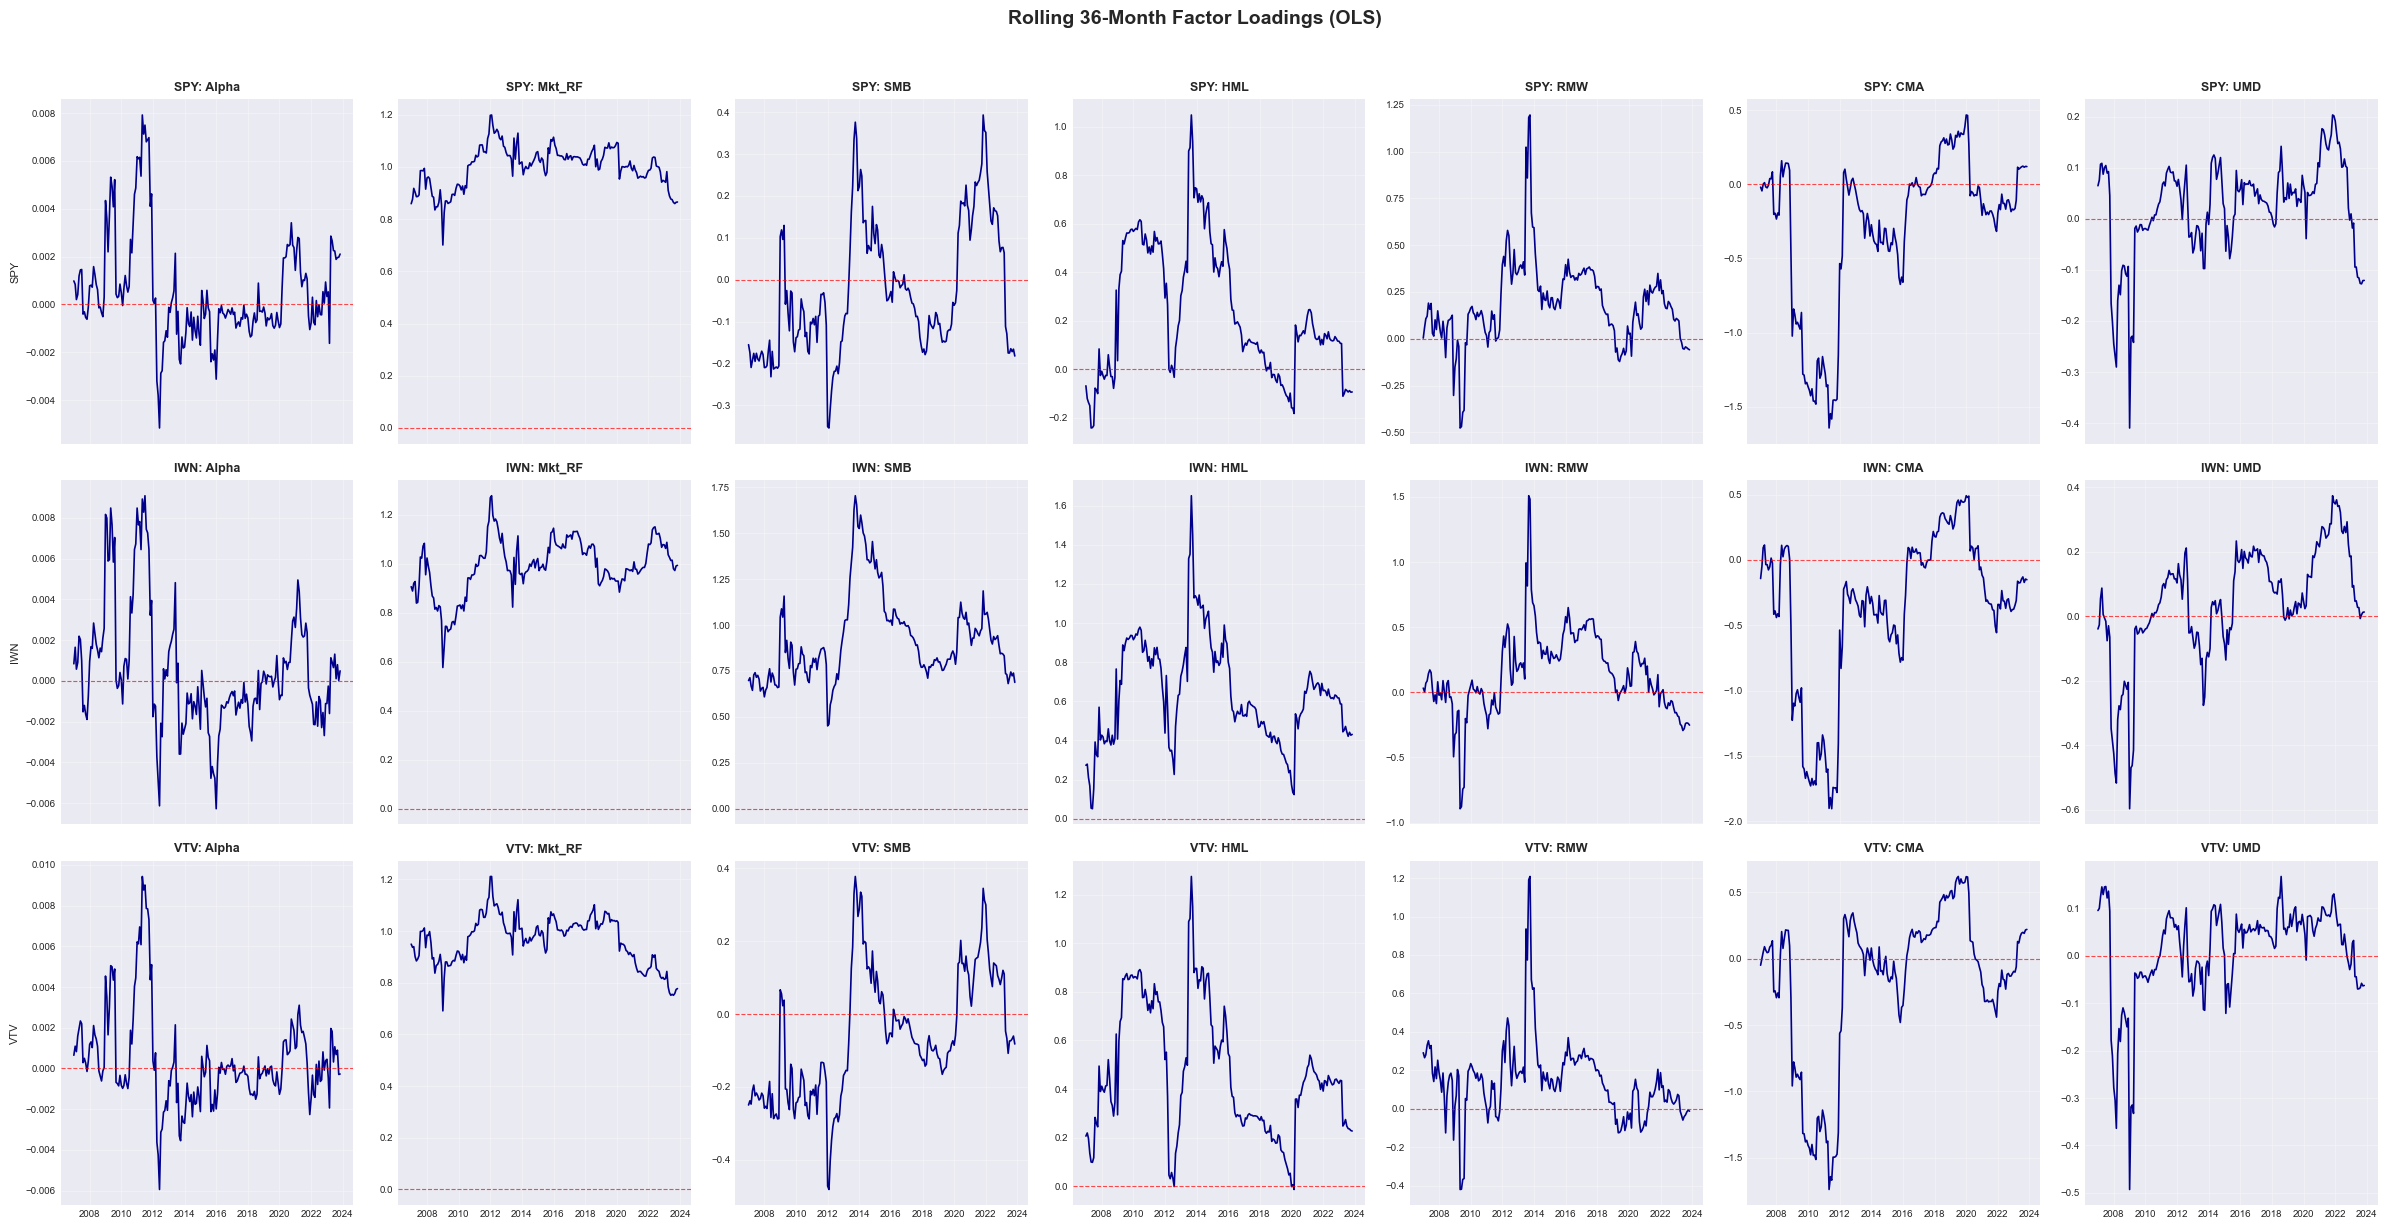


WHAT TO LOOK FOR:
- SPY: Mkt_RF should be stable near 1.0; other betas should be near zero 
  throughout (confirming SPY is "pure market" exposure).

- IWN: SMB and HML should be consistently positive (confirming small-value 
  tilt). Watch for any drift over time.

- VTV: HML should be consistently positive. RMW may vary as the composition 
  of "value" stocks changes.

- Alpha: Should be close to zero for passive ETFs. Persistent positive alpha 
  would suggest the ETF adds value beyond its factor exposures.

- TIME VARIATION: If betas shift significantly, it means the fund's risk 
  profile is changing — important for portfolio construction.



In [18]:
# ============================================================================
# Rolling-Window 5-Factor + Momentum Regressions
# ============================================================================

window = 36  # 36-month rolling window

print("="*70)
print(f"ROLLING {window}-MONTH FACTOR REGRESSIONS")
print("="*70)

roll_cols = ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'UMD']
roll_names = ['Alpha', 'Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA', 'UMD']

fig, axes = plt.subplots(len(etf_tickers), len(roll_names), figsize=(24, 12),
                          sharex=True)

for row, (ticker, label) in enumerate(etf_tickers.items()):
    edf = etf_dataframes[ticker]
    n = len(edf)

    # Store rolling betas
    rolling_betas = {name: [] for name in roll_names}
    dates = []

    for i in range(window, n):
        window_data = edf.iloc[i - window:i]
        y_w = window_data['Stock_Excess_Return'].values
        X_w = sm.add_constant(window_data[roll_cols].values)
        try:
            res_w = sm.OLS(y_w, X_w).fit()
            for j, name in enumerate(roll_names):
                rolling_betas[name].append(res_w.params[j])
            dates.append(edf.index[i])
        except:
            for name in roll_names:
                rolling_betas[name].append(np.nan)
            dates.append(edf.index[i])

    # Plot each coefficient
    for col, name in enumerate(roll_names):
        ax = axes[row, col]
        ax.plot(dates, rolling_betas[name], linewidth=1.2, color='darkblue')
        ax.axhline(0, color='red', linestyle='--', linewidth=0.8, alpha=0.7)
        ax.set_title(f'{ticker}: {name}', fontsize=9, fontweight='bold')
        ax.grid(True, alpha=0.3)
        if col == 0:
            ax.set_ylabel(label.split('(')[0].strip(), fontsize=8)
        ax.tick_params(axis='both', labelsize=7)

plt.suptitle(f'Rolling {window}-Month Factor Loadings (OLS)',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('rolling_betas.png', dpi=100, bbox_inches='tight')
plt.show()

print("""
WHAT TO LOOK FOR:
- SPY: Mkt_RF should be stable near 1.0; other betas should be near zero 
  throughout (confirming SPY is "pure market" exposure).
  
- IWN: SMB and HML should be consistently positive (confirming small-value 
  tilt). Watch for any drift over time.
  
- VTV: HML should be consistently positive. RMW may vary as the composition 
  of "value" stocks changes.

- Alpha: Should be close to zero for passive ETFs. Persistent positive alpha 
  would suggest the ETF adds value beyond its factor exposures.

- TIME VARIATION: If betas shift significantly, it means the fund's risk 
  profile is changing — important for portfolio construction.
""")

---

## Section 9: Summary and Further Reading

### What We've Learned

This notebook covered the major extensions and debates surrounding factor investing:

| Topic | Key Takeaway |
|-------|-------------|
| **FF5 Model** | Adding profitability (RMW) and investment (CMA) subsumes much of HML's alpha |
| **Carhart Momentum** | Momentum is the most robust anomaly but carries severe crash risk; fundamental (earnings) momentum may be the deeper driver; standalone momentum funds deliver a bundle of earnings momentum, industry concentrations, and time-varying beta |
| **Novy-Marx Profitability** | Gross profitability is an independent predictor; combining it with value is powerful. Profitability ≠ "quality" — the latter is a marketing umbrella that invites multi-signal overfitting |
| **Short-Term Reversals** | 1-month reversal premium exists but high trading costs erode most of it |
| **Long-Term Reversals** | Closely related to value effect; stocks mean-revert over 3–5 years |
| **Beta Anomaly / BAB** | The empirical SML is flat or negative; low-beta stocks earn higher risk-adjusted returns than high-beta stocks. High-volatility stocks are really small unprofitable growth stocks — the "anomaly" is largely explained by known factors. Implementation after costs is challenging. |
| **Chen & Zimmermann** | Most published anomalies replicate; the core factors are robust but many exotic anomalies vanish after trading costs |
| **Wei Dai / Dimensional** | Factor investing requires 10–20 year horizons; valuation spreads predict premia; integrated portfolio design and the multiplier approach dominate combination or satellite strategies; premium timing is almost certainly futile (4% of 720 strategies "worked"); reversals can add 1–10 bps as an exclusion screen |
| **Bessembinder** | Only 4% of stocks explain all net wealth creation; ~50% of stocks have negative lifetime returns; skewness is a larger drag on fund performance than fees — broad diversification is essential, not optional |
| **Novy-Marx & Velikov** | Implementation costs matter enormously; many anomalies vanish after trading costs |
| **Sunspots & Premium Timing** | Novy-Marx showed celestial variables "predict" returns as well as economic variables — a devastating satire of factor-timing research |
| **The Case Against Factor Investing** | Individual anomalies earn ~0% after costs post-2005; theory adds no predictive value over data mining; multi-factor integration may survive; Adaptive Markets framing shifts emphasis from "which factor?" to "how quickly can you adapt?" |

### The Factor Model Hierarchy

```
Level 1: CAPM (1 factor)
   R_i - R_f = α + β_MKT(R_m - R_f) + ε
   
Level 2: Fama-French 3-Factor (1993)
   + SMB (size) + HML (value)
   
Level 3: Carhart 4-Factor (1997)
   + UMD (momentum)
   
Level 4: Fama-French 5-Factor (2015)
   + RMW (profitability) + CMA (investment)
   [note: momentum intentionally excluded by Fama-French]
   
Level 5: FF5 + Momentum (6-Factor, practitioner standard)
   The "kitchen sink" model used in much applied research
   
Alternative: q-Factor Model (Hou, Xue, Zhang)
   MKT + ME (size) + ROE (profitability) + I/A (investment)
   Motivated by production-based theory
```

### Looking Back & Looking Forward

This notebook is part of a five-notebook progression:

| Notebook | What You Gained |
|----------|----------------|
| **[Statistical Foundations](01_Statistical_Foundations.ipynb)** | The *why* behind the tools — CLT, OLS derivation, the sandwich estimator, Newey-West HAC, all verified on hand-checkable examples |
| **[Time Series Foundations](02_Time_Series_Foundations.ipynb)** | The *when it matters* — stationarity, autocorrelation, volatility clustering, and the specific assumption stack that factor regressions rest on |
| **[Fama-French 3-Factor](03_Fama_French_3Factor.ipynb)** | The *how* — loading real data, running regressions, validating assumptions, interpreting coefficients with robust standard errors |
| **This notebook** | The *what else and what next* — additional factors, their theoretical foundations, the research frontier, and the honest case both for and against factor investing |
| **[Practical Factor Investing](05_Practical_Factor_Investing.ipynb)** | The *so what* — applying everything to real Dimensional and Avantis UCITS ETFs, factor analysis, and portfolio construction |

The key insight that runs through all notebooks: **factor investing is not about chasing anomalies — it is about understanding the economic mechanisms that generate premia, measuring them with sound statistical tools, and implementing them in a way that survives transaction costs and behavioral pitfalls.**

The [next notebook](05_Practical_Factor_Investing.ipynb) puts this into practice by analysing the investment strategies of Dimensional and Avantis, running factor regressions on their European UCITS ETFs, and constructing a model portfolio.

### Essential Reading

**Foundational Papers:**
- Fama & French, "Common Risk Factors in the Returns on Stocks and Bonds" (1993)
- Fama & French, "A Five-Factor Asset Pricing Model" (2015)
- Carhart, "On Persistence in Mutual Fund Performance" (1997)
- Novy-Marx, "The Other Side of Value: The Gross Profitability Premium" (2013)
- Black, Jensen & Scholes, "The Capital Asset Pricing Model: Some Empirical Tests" (1972)
- Frazzini & Pedersen, "Betting Against Beta" (2014)

**Modern Research:**
- Chen & Zimmermann, "Open Source Cross-Sectional Asset Pricing" (2022)
- Chen, Lopez-Lira & Zimmermann, "Does Peer-Reviewed Research Help Predict Stock Returns?" (2024)
- Chen & Velikov, "Zeroing in on the Expected Returns of Anomalies" (2023)
- Novy-Marx & Velikov, "A Taxonomy of Anomalies and Their Trading Costs" (2016)
- Novy-Marx & Velikov, "Betting Against Betting Against Beta" (2022)
- Novy-Marx, "Predicting Anomaly Performance with Politics, the Weather, Global Warming, Sunspots, and the Stars" (2014)
- Hou, Xue & Zhang, "Replicating Anomalies" (2020)
- Daniel & Moskowitz, "Momentum Crashes" (2016)
- Asness, Moskowitz & Pedersen, "Value and Momentum Everywhere" (2013)
- Cederburg & O'Doherty, "Does It Pay to Bet Against Beta?" (2016)
- Hong & Sraer, "Speculative Betas" (2016)

**Practitioner Research:**
- Dai & Novy-Marx, "Reversals and the Returns to Liquidity Provision" (*Financial Analysts Journal*, 2024)
- Dai, "Another Look at Timing the Equity Premiums" (Dimensional, 2023)
- Dai, Medhat & Novy-Marx, "On the Valuation of Performance Fees and Their Impact on Asset Managers' Incentives" (2022)
- Bessembinder, H., "Do Stocks Outperform Treasury Bills?" (*Journal of Financial Economics*, 2018)
- Bessembinder, H., "Which U.S. Stocks Generated the Highest Long-Term Returns?" (*Financial Analysts Journal*, 2023)
- Bessembinder, H., "Mutual Fund Performance at Long Horizons" (2024)

**Books:**
- Andrew Ang, *Asset Management: A Systematic Approach to Factor Investing* (2014)
- Turan Bali, Robert Engle & Scott Murray, *Empirical Asset Pricing: The Cross Section of Stock Returns* (2016)
- Antti Ilmanen, *Expected Returns* (2011)
- Andrew Berkin & Larry Swedroe, *Your Complete Guide to Factor-Based Investing* (2016)

---

## Exercises

Test your understanding of the advanced topics covered in this notebook. These exercises extend the hands-on skills from the [3-Factor Tutorial exercises](03_Fama_French_3Factor.ipynb) — if any of the regression mechanics feel unfamiliar, revisit the earlier notebook first.

### Exercise 1: 5-Factor Model on a New ETF (Hands-On)

Download return data for **IWM** (iShares Russell 2000 ETF — small-cap blend, no explicit value tilt) and run the full 5-factor regression.

1. How does IWM's SMB loading compare to IWN's? Is this what you expected?
2. Does IWM have a significant HML loading? Why or why not?
3. What happens to IWM's alpha when you move from 3 factors to 5 factors?

```python
# Starter code:
raw = yf.download('IWM', start='2000-01-01', end='2023-12-31', progress=False)
# ... compute monthly excess returns, then:
# res3 = run_ff_regression(None, ['Mkt_RF', 'SMB', 'HML'], iwm_df)
# res5 = run_ff_regression(None, ['Mkt_RF', 'SMB', 'HML', 'RMW', 'CMA'], iwm_df)
```

### Exercise 2: Rolling Sharpe Ratios for Combined Strategies (Hands-On)

Using the multi-factor strategy returns computed in Section 6:

1. Compute the **rolling 36-month Sharpe ratio** for (a) HML alone, (b) Value + Profitability, and (c) Value + Profitability + Momentum.
2. Plot all three on the same chart. During which periods does the combined strategy most clearly outperform single factors?
3. Is there any period where all three strategies have a negative rolling Sharpe ratio simultaneously?

```python
# Starter code:
# rolling_sharpe = ret_series.rolling(36).mean() / ret_series.rolling(36).std() * np.sqrt(12)
```

### Exercise 3: Momentum Crash Anatomy (Discussion + Hands-On)

1. Identify the **worst 3-month period** for the momentum factor (UMD) in our sample. What calendar months were they?
2. What was the market (Mkt-RF) doing during those months? Was this consistent with the Daniel & Moskowitz (2016) narrative of momentum crashing during market recoveries?
3. If you had held an **equal-weight combination of UMD and HML**, how much would the drawdown have been reduced?

```python
# Starter code:
# rolling_3m_mom = factors['UMD'].rolling(3).sum()
# worst_end = rolling_3m_mom.idxmin()
# print(f"Worst 3-month period ending: {worst_end}")
```

### Exercise 4: The Beta Anomaly — Subsample Robustness (Discussion + Hands-On)

The beta anomaly (flat or negative SML) was documented in data going back to the 1930s. But does it hold in every subperiod? This connects to the stationarity discussion in the [Time Series Foundations notebook](02_Time_Series_Foundations.ipynb) — if the anomaly is non-stationary, our full-sample estimates may be misleading.

1. Split the beta-sorted decile portfolios into two halves: 2000–2011 and 2012–2023. Plot the empirical SML for each subperiod. Is the anomaly consistent, or does it appear mainly in one era?
2. Regress the simple BAB factor (D1 − D10) on FF5 + Momentum separately for each subperiod. Does the alpha change sign or significance?
3. **Discussion**: Frazzini and Pedersen argue leverage constraints drive the BAB premium. Did anything change about leverage availability (e.g., the rise of leveraged ETFs, zero-commission brokers) between the two subperiods that might affect the premium?

```python
# Starter code:
# beta_first = beta_ports.loc['2000':'2011']
# beta_second = beta_ports.loc['2012':'2023']
# For each half, recompute avg excess returns and realized betas, then plot.
```